In [2]:
import os
import torch
import random
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt

import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [3]:
# set seed so that results can be replicated.
def set_seed(seed: int = 41) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")
    
set_seed()

Random seed set as 41


In [4]:

actual_image_size = 32

manual_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)


In [5]:
train_dataset = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=manual_transform
)
test_dataset = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=manual_transform
)


Files already downloaded and verified
Files already downloaded and verified


In [6]:
class PatchEmbedding(nn.Module):
    def __init__(
        self,
        image_size: int,
        patch_size: int = 16,
        in_channels: int = 3,
        embed_dim: int = 768,
        overlap_patches: bool = False,
    ):
        # PatchEmbedding for getting the patch-representation of the image.
        super().__init__()
        self.image_size = image_size
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        # if overlapping patches is selected, then we make use of stride as half the patch size which results in overlapping patches.
        # will have different count of patches when compated to non-overlapping patches.
        if overlap_patches:
            self.patch_embed = nn.Conv2d(
                in_channels, self.embed_dim, kernel_size=self.patch_size, stride=self.patch_size // 2
            )
        # if overlapping patches is not-selected, then we make use of stride as the patch size which results in non-overlapping patches.
        else:
            self.patch_embed = nn.Conv2d(
                in_channels,
                self.embed_dim,
                kernel_size=self.patch_size,
                stride=self.patch_size,
            )


    def forward(self, x):
        height, width = x.shape[2:]
        assert height == self.image_size, "Height is not same as provided image size"
        assert width == self.image_size, "Width is not same as provided image size"
        # (B, embed_dim, num_of_patches ** 0.5, num_of_patches ** 0.5)
        x = self.patch_embed(x)
        # combine the last 2 dimensions into a single one.
        x = x.flatten(start_dim=2)  # (B, embed_dim, num_of_patches)
        # transpose so that easy use in further steps.
        x = x.transpose(1, 2)  # (B, num_of_patches, embed_dim)
        return x


In [7]:
class MLP(nn.Module):
    def __init__(
        self, in_features: int, hidden_features: int, out_features: int, drop: float
    ):
        super().__init__()
        # Making sure that the output dimension remains same.
        assert (
            in_features == out_features
        ), "Input and Output dimensions for MLP should match."
        # Basic MLP which involes 2 Linear layers an activation unit and dropouts after the linear layers.
        # GELU is choosen because it's also used in the paper.
        self.mlp = nn.Sequential(
            nn.Linear(in_features, hidden_features),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Linear(hidden_features, out_features),
            nn.Dropout(drop),
        )

    def forward(self, x):
        return self.mlp(x)


In [8]:
class MultiHeadAttention(nn.Module):
    @staticmethod
    def calculate_attention_scores(query, key, value, attn_dropout: nn.Dropout):
        dim_value = query.shape[-1]
        # Calculating the attention score using the formula "softmax(query * key^T) / sqrt(dim) * value"
        # Making sure to pass the attention scores for visualization purpose.
        # (batch_size, heads, num_of_patches, numb_of_patches)
        scores = (query @ key.transpose(-2, -1)) / (dim_value**0.5)
        scores = scores.softmax(dim=-1)
        attn_scores = scores
        scores = attn_dropout(scores)
        return (scores @ value), attn_scores

    def __init__(
        self,
        embed_dim: int,
        heads: int,
        attn_drop: float,
        proj_drop: float,
        include_bias: bool = True,
    ):
        # Generate the attention scores.
        super().__init__()
        self.embed_dim = embed_dim
        self.heads = heads
        # splitting the embedding dimension based on heads so that different heads can attend to different data.
        self.dim_per_head = self.embed_dim // self.heads
        assert (
            self.embed_dim == self.heads * self.dim_per_head
        ), "Can't use the head size, as its not properly divisble by input dimension"
        # creating 3 different matrices for query, key and value (Wq, Wk, Wv)
        self.qkv = nn.Linear(
            self.embed_dim, 3 * self.embed_dim, bias=include_bias
        )
        # normalization
        self.attn_dropout = nn.Dropout(attn_drop)
        # Passing the attention scores through the linear layer so they again share same weights.
        self.proj = nn.Linear(self.embed_dim, self.embed_dim)  # W0
        # normalization
        self.proj_dropout = nn.Dropout(proj_drop)

    def forward(self, x):
        batch_size, num_of_patches, embed_dim = x.shape
        qkv = self.qkv(x)  # (batch_size, num_of_patches, emed_dim)
        # reshaping andd permutting the data to extract query, key and values data from the input.
        # (batch_size, num_of_patches, 3, heads, dim_per_head)
        qkv = qkv.reshape(batch_size, num_of_patches, 3, self.heads, self.dim_per_head)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        # (batch_size, heads, num_of_patches, dim_per_head)
        q, k, v = qkv[0], qkv[1], qkv[2]
        # Passing it into the static function to get attention values and weights. The attention weights will be stored so that it can be used for visualization purpose later.
        # (batch_size, heads, numb_of_patches, dim_per_head)
        x, self.attn_scores = MultiHeadAttention.calculate_attention_scores(
            q, k, v, self.attn_dropout
        )
        x = x.transpose(1, 2).flatten(2)
        x = self.proj(x)
        return self.proj_dropout(x)

In [9]:
class TransformerEncoder(nn.Module):
    def __init__(
        self,
        embed_dim: int,
        heads: int,
        mlp_size: int,
        mlp_drop: float,
        attn_drop: float,
        proj_drop: float,
        include_bias: bool,
    ):
        # Transformer Block which involes 1 Attention and 1 MLP and layer norm for normalization of the data.
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(
            embed_dim, heads, attn_drop, proj_drop, include_bias
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, mlp_size, embed_dim, mlp_drop)

    def forward(self, x):
        # Residual connection which involes adding the input with the output from attention layer.
        x = x + self.attn(self.norm1(x))
        # Residual connection which involes adding the input with the output from mlp layer
        x = x + self.mlp(self.norm2(x))
        return x


In [10]:
class ViT(nn.Module):
    def __init__(
        self,
        image_size: int = 224,
        in_channels: int = 3,
        patch_size: int = 16,
        embed_dim: int = 768,
        num_encoders: int = 12,
        num_heads: int = 4,
        mlp_size: int = 3072,
        mlp_drop: float = 0.1,
        attn_drop: float = 0.1,
        proj_drop: float = 0.1,
        embed_drop: float = 0.1,
        include_bias: bool = True,
        num_of_classes: int = 10,
        overlap_patch: bool = False,
        use_final_cls_token: bool = False,
    ):
        # Actual Vision Transformer model.
        super().__init__()
        # to get patch embedding data from the images.
        self.patch_embed = PatchEmbedding(
            image_size, patch_size, in_channels, embed_dim, overlap_patch
        )

        self.overlap_patches = overlap_patch
        # get the number of patch count based on the overlap_patch flag.
        # more number of patches incase overlap is set to True.
        if self.overlap_patches:
            self.num_patches = ((image_size - patch_size) // (patch_size // 2) + 1) ** 2
        else:
            self.num_patches = (image_size // patch_size) ** 2

        # classification data used fot getting the final classification results from the model.
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim), requires_grad=True)

        # position embedding so that the transformer can identify which patch belongs to which part of the image.
        self.pos_embed = nn.Parameter(
            torch.randn(1, 1 + self.num_patches, embed_dim), requires_grad=True
        )
        # normalization.
        self.embed_dropout = nn.Dropout(embed_drop)

        # list of encoder blocks that the embedding data passes through which calculates the attention scores.
        self.transformer_blocks = nn.ModuleList(
            [
                TransformerEncoder(
                    embed_dim,
                    num_heads,
                    mlp_size,
                    mlp_drop,
                    attn_drop,
                    proj_drop,
                    include_bias,
                )
                for _ in range(num_encoders)
            ]
        )
        # to get the classification scores from the representation.
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim), nn.Linear(embed_dim, num_of_classes)
        )

        self.use_final_cls_token = use_final_cls_token

    def forward(self, x):
        batch_size = x.shape[0]
        # (batch_size, num_patches, embed_dim)
        # Get the patch embedding data of the image.
        x_embed = self.patch_embed(x)
        # (batch_size, 1, embed_dim)
        # Create a classification token so that model can learn.
        cls_token = self.cls_token.expand(batch_size, -1, -1)
        # (batch_size, 1 + num_patches, embed_dim)
        # combine it with the patch embedding data of the image.
        x_embed = torch.cat([cls_token, x_embed], dim=1)
        # (batch_size, 1 + num_patches, embed_dim)
        # Adding position embedding information so that the transformer model can identify which patch belong to which part of the image.
        x_embed = x_embed + self.pos_embed
        # normalization.
        x_embed = self.embed_dropout(x_embed)

        if self.use_final_cls_token:
            cls_token_data = []

        for transformer_block in self.transformer_blocks:
            x_embed = transformer_block(x_embed)
            if self.use_final_cls_token:
                # collectiong the class token data incase we need to use it from different layers.
                cls_token_data.append(x_embed[:, 0])

        # passing the class token data into the mlp head to get the final scores of the classes which will then be used for classification.
        if self.use_final_cls_token:
            # (encoder_layers, batch_size, embed_dim)
            # combine all the classification tokens from different layers by taking the mean across it's dimension.
            cls_token_data = torch.stack(cls_token_data, dim=0)
            cls_token = cls_token_data.mean(0)
            return self.mlp_head(cls_token)
        else:
            return self.mlp_head(
                x_embed[
                    :,
                    0,
                ]
            )


In [10]:
# Used for training the vision transformer with different configuration data that is passed into it.
def train_vit_model(
    train_dataset,
    test_dataset,
    train_size,
    patch_size,
    num_of_heads,
    overlap_patch,
    use_final_cls_token,
    image_size,
    in_channels,
    embed_dim,
    encoder_layers,
    mlp_size,
    mlp_drop,
    attn_drop,
    proj_drop,
    embed_drop,
    include_bias,
    num_of_classes,
    batch_size,
    epochs,
    learning_rate,
):
    # use more than 1 core to load the data.
    workers = 2
    model = ViT(
        image_size,
        in_channels,
        patch_size,
        embed_dim,
        encoder_layers,
        num_of_heads,
        mlp_size,
        mlp_drop,
        attn_drop,
        proj_drop,
        embed_drop,
        include_bias,
        num_of_classes,
        overlap_patch,
        use_final_cls_token,
    )
    # loss function and optimizer.
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(
        model.parameters(), lr=learning_rate
    )

    device = torch.device("cuda")
    model = model.to(device)

    # loaders to load the required data.
    complete_train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers
    )

    complete_test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=workers
    )
    length_train_dataset, length_test_dataset = len(
        train_dataset), len(test_dataset)

    train_length = int(train_size * length_train_dataset)
    validation_length = len(train_dataset) - train_length

    print(f"{train_length = } {validation_length = }")
    if validation_length != 0:
        train_dataset, validation_dataset = torch.utils.data.random_split(
            train_dataset, [train_length, validation_length]
        )
    else:
        # Incase we train on complete data set aside few samples from the traindata itself for validation-set testing.
        validation_length = 1024
        _, validation_dataset = torch.utils.data.random_split(
            train_dataset, [train_length - validation_length, validation_length])

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers
    )
    validation_loader = torch.utils.data.DataLoader(
        validation_dataset, batch_size=batch_size, shuffle=True, num_workers=workers
    )

    train_loss_data, validation_loss_data = [], []
    train_accuracy_data, validation_accuracy_data = [], []

    for epoch in range(epochs):
        curr_train_loss, curr_train_accuracy = 0, 0
        # train loss and accuracy.
        model.train()
        train_batch_iterator = tqdm(
            train_loader, desc=f"Training Epoch {epoch:03d}"
        )
        iter_count = 0
        for images, labels in train_batch_iterator:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            curr_train_loss += loss.item()
            actual_labels = labels.cpu().detach().numpy()
            predicted_labels = torch.argmax(torch.softmax(
                output, dim=1), dim=1).cpu().detach().numpy()
            curr_train_accuracy += np.sum(actual_labels == predicted_labels)
            iter_count += 1

        curr_train_loss /= iter_count + 1
        curr_train_accuracy /= train_length
        train_loss_data.append(curr_train_loss)
        train_accuracy_data.append(curr_train_accuracy)

        curr_validation_loss, curr_validation_accuracy = 0, 0
        # validation loss and accuracy
        
        model.eval()
        with torch.no_grad():
            batch_iter = tqdm(validation_loader,
                              desc=f"Validation Epoch {epoch:03d}")
            iter_count = 0
            for images, labels in batch_iter:
                images, labels = images.to(device), labels.to(device)
                output = model(images)
                loss = criterion(output, labels)
                curr_validation_loss += loss.item()
                actual_labels = labels.cpu().detach().numpy()
                pred_labels = torch.argmax(torch.softmax(
                    output, dim=1), dim=1).cpu().detach().numpy()
                curr_validation_accuracy += np.sum(
                    actual_labels == pred_labels)
                iter_count += 1

        curr_validation_loss /= (iter_count + 1)
        curr_validation_accuracy /= validation_length
        validation_loss_data.append(curr_validation_loss)
        validation_accuracy_data.append(curr_validation_accuracy)

        print(
            f"{epoch = }, Train Loss: {curr_train_loss:.4f}, Validation Loss: {curr_validation_loss:.4f}, Train Accuracy: {curr_train_accuracy * 100:.2f}%, Validation Accuracy: {curr_validation_accuracy * 100:.2f}%"
        )

    model.eval()
    train_accuracy, test_accuracy = 0, 0

    # calculate the final train and test accuracy for the model trained.
    with torch.no_grad():
        for images, labels in tqdm(complete_train_loader):
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            actual_labels = labels.cpu().detach().numpy()
            pred_labels = torch.argmax(torch.softmax(
                output, dim=1), dim=1).cpu().detach().numpy()
            train_accuracy += np.sum(actual_labels == pred_labels)

        train_accuracy /= length_train_dataset
        for images, labels in tqdm(complete_test_loader):
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            actual_labels = labels.cpu().detach().numpy()
            pred_labels = torch.argmax(torch.softmax(
                output, dim=1), dim=1).cpu().detach().numpy()
            test_accuracy += np.sum(actual_labels == pred_labels)

        test_accuracy /= length_test_dataset

    patch_type = 'non-overlapping'
    if overlap_patch:
        patch_type = 'overlapping'

    print(
        f'For model trained on {train_size * 100: .2f}% data with {num_of_heads} heads and {patch_size} x {patch_size} {patch_type} patches,')
    print(
        f'\tTrain Accuracy is {train_accuracy * 100: .2f}%\n\tTest Accuracy is {test_accuracy * 100: .2f}%')

    return model, train_loss_data, validation_loss_data, train_accuracy_data, validation_accuracy_data

In [11]:
def plot_loss_accuracy_data(data1, data2, label1, label2, xlabel, ylabel1, ylabel2):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    ax1.plot(range(len(data1)), data1, label=label1, color='orange')
    ax2.plot(range(len(data2)), data2, label=label2)

    ax1.set_xlabel(xlabel)
    ax2.set_ylabel(ylabel1)
    ax2.set_ylabel(ylabel2)

    ax1.legend(loc='upper center')
    ax2.legend(loc='lower center')
    plt.title(f'{label1} vs {label2}')
    plt.show()

In [12]:
def plot_data(data1, data2, label1, label2, xlabel, ylabel, location):
    plt.plot(data1, label=label1)
    plt.plot(data2, label=label2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc=location)
    plt.title(f'{label1} vs {label2}')
    plt.show()

In [13]:
# Helper function used for calling the model for training and plotting the required data by using the above functions.
def train_test_model(train_dataset, test_dataset, config_data):
    (
        vit_model,
        train_loss_data,
        valid_loss_data,
        train_acc_data,
        valid_acc_data,
    ) = train_vit_model(
        train_dataset,
        test_dataset,
        config_data["train_size"],
        config_data["patch_size"],
        config_data["num_of_heads"],
        config_data["overlap_patches"],
        config_data["use_final_cls_token"],
        config_data["image_size"],
        config_data["in_channels"],
        config_data["embed_dim"],
        config_data["num_of_encoders"],
        config_data["mlp_size"],
        config_data["mlp_drop"],
        config_data["attn_drop"],
        config_data["proj_drop"],
        config_data["embed_drop"],
        config_data["include_bias"],
        config_data["num_of_classes"],
        config_data["batch_size"],
        config_data["epochs"],
        config_data["learning_rate"],
    )
    plot_loss_accuracy_data(train_loss_data, train_acc_data, 'Training Loss', 'Training Accuracy', 'Epoch number', 'Loss', 'Accuracy', )
    plot_data(train_loss_data, valid_loss_data, "Training Loss", "Validation Loss", 'Epoch number', 'Loss', 'upper right')
    plot_data(train_acc_data, valid_acc_data, "Training Accuracy", "Validation Accuracy", 'Epoch number', 'Accuracy', 'upper left')
    return vit_model, train_loss_data, valid_loss_data, train_acc_data, valid_acc_data


In [1]:
# default config data that is copied and changed before passing for training the vit model.
default_config_data = {
	'train_size': 0.8,
	'patch_size': 4,
	'num_of_heads': 4,
	'overlap_patches': False,
	'use_final_cls_token': False,
	'image_size': 32,
 	'in_channels': 3,
	'embed_dim': 256,
	'num_of_encoders': 12,
	'mlp_size': 3072,
    'mlp_drop': 0.1,
    'attn_drop': 0.1,
    'proj_drop': 0.1,
    'embed_drop': 0.1,
    'include_bias': True,
    'num_of_classes': 10,
    'batch_size': 128,
    'epochs': 100,
    'learning_rate': 1e-5,
}


train_length = 40000 validation_length = 10000


Validation Epoch 000: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 19.15it/s]


epoch = 0, Train Loss: 2.0260, Validation Loss: 1.8899, Train Accuracy: 24.17%, Validation Accuracy: 30.38%


Validation Epoch 001: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.50it/s]


epoch = 1, Train Loss: 1.8443, Validation Loss: 1.7677, Train Accuracy: 32.03%, Validation Accuracy: 36.12%


Validation Epoch 002: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.44it/s]


epoch = 2, Train Loss: 1.6958, Validation Loss: 1.6479, Train Accuracy: 37.64%, Validation Accuracy: 40.85%


Validation Epoch 003: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.43it/s]


epoch = 3, Train Loss: 1.5794, Validation Loss: 1.4766, Train Accuracy: 42.34%, Validation Accuracy: 45.58%


Validation Epoch 004: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.39it/s]


epoch = 4, Train Loss: 1.4982, Validation Loss: 1.4229, Train Accuracy: 45.43%, Validation Accuracy: 48.68%


Validation Epoch 005: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.48it/s]


epoch = 5, Train Loss: 1.4433, Validation Loss: 1.3699, Train Accuracy: 47.80%, Validation Accuracy: 49.96%


Validation Epoch 006: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.49it/s]


epoch = 6, Train Loss: 1.3967, Validation Loss: 1.3246, Train Accuracy: 49.30%, Validation Accuracy: 51.73%


Validation Epoch 007: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.52it/s]


epoch = 7, Train Loss: 1.3595, Validation Loss: 1.3002, Train Accuracy: 50.97%, Validation Accuracy: 52.72%


Validation Epoch 008: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.39it/s]


epoch = 8, Train Loss: 1.3297, Validation Loss: 1.2741, Train Accuracy: 51.99%, Validation Accuracy: 54.00%


Validation Epoch 009: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.45it/s]


epoch = 9, Train Loss: 1.2969, Validation Loss: 1.2470, Train Accuracy: 53.32%, Validation Accuracy: 55.38%


Validation Epoch 010: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.57it/s]


epoch = 10, Train Loss: 1.2706, Validation Loss: 1.2311, Train Accuracy: 54.24%, Validation Accuracy: 56.03%


Validation Epoch 011: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.46it/s]


epoch = 11, Train Loss: 1.2450, Validation Loss: 1.2134, Train Accuracy: 55.28%, Validation Accuracy: 56.74%


Validation Epoch 012: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.53it/s]


epoch = 12, Train Loss: 1.2274, Validation Loss: 1.1892, Train Accuracy: 55.73%, Validation Accuracy: 57.37%


Validation Epoch 013: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.46it/s]


epoch = 13, Train Loss: 1.2037, Validation Loss: 1.1858, Train Accuracy: 56.59%, Validation Accuracy: 57.26%


Validation Epoch 014: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.51it/s]


epoch = 14, Train Loss: 1.1818, Validation Loss: 1.1632, Train Accuracy: 57.70%, Validation Accuracy: 58.19%


Validation Epoch 015: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.46it/s]


epoch = 15, Train Loss: 1.1602, Validation Loss: 1.1494, Train Accuracy: 58.48%, Validation Accuracy: 58.97%


Validation Epoch 016: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.48it/s]


epoch = 16, Train Loss: 1.1424, Validation Loss: 1.1186, Train Accuracy: 59.03%, Validation Accuracy: 60.11%


Validation Epoch 017: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.52it/s]


epoch = 17, Train Loss: 1.1295, Validation Loss: 1.1146, Train Accuracy: 59.61%, Validation Accuracy: 60.37%


Validation Epoch 018: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.48it/s]


epoch = 18, Train Loss: 1.1129, Validation Loss: 1.0974, Train Accuracy: 60.19%, Validation Accuracy: 61.30%


Validation Epoch 019: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.51it/s]


epoch = 19, Train Loss: 1.0958, Validation Loss: 1.0898, Train Accuracy: 60.84%, Validation Accuracy: 61.17%


Validation Epoch 020: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.43it/s]


epoch = 20, Train Loss: 1.0756, Validation Loss: 1.1057, Train Accuracy: 61.11%, Validation Accuracy: 60.50%


Validation Epoch 021: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.59it/s]


epoch = 21, Train Loss: 1.0634, Validation Loss: 1.0657, Train Accuracy: 62.02%, Validation Accuracy: 62.10%


Validation Epoch 022: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.53it/s]


epoch = 22, Train Loss: 1.0489, Validation Loss: 1.0949, Train Accuracy: 62.32%, Validation Accuracy: 61.55%


Validation Epoch 023: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.56it/s]


epoch = 23, Train Loss: 1.0376, Validation Loss: 1.0880, Train Accuracy: 63.00%, Validation Accuracy: 61.19%


Validation Epoch 024: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.52it/s]


epoch = 24, Train Loss: 1.0224, Validation Loss: 1.0674, Train Accuracy: 63.59%, Validation Accuracy: 62.73%


Validation Epoch 025: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.47it/s]


epoch = 25, Train Loss: 1.0104, Validation Loss: 1.0521, Train Accuracy: 63.97%, Validation Accuracy: 62.52%


Validation Epoch 026: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.40it/s]


epoch = 26, Train Loss: 0.9989, Validation Loss: 1.0550, Train Accuracy: 64.39%, Validation Accuracy: 62.66%


Validation Epoch 027: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.38it/s]


epoch = 27, Train Loss: 0.9848, Validation Loss: 1.0322, Train Accuracy: 64.70%, Validation Accuracy: 63.22%


Validation Epoch 028: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.45it/s]


epoch = 28, Train Loss: 0.9728, Validation Loss: 1.0359, Train Accuracy: 65.27%, Validation Accuracy: 63.65%


Validation Epoch 029: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.52it/s]


epoch = 29, Train Loss: 0.9654, Validation Loss: 1.0272, Train Accuracy: 65.36%, Validation Accuracy: 63.89%


Validation Epoch 030: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.43it/s]


epoch = 30, Train Loss: 0.9518, Validation Loss: 1.0086, Train Accuracy: 65.99%, Validation Accuracy: 64.31%


Validation Epoch 031: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.56it/s]


epoch = 31, Train Loss: 0.9418, Validation Loss: 1.0146, Train Accuracy: 66.44%, Validation Accuracy: 64.09%


Validation Epoch 032: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.52it/s]


epoch = 32, Train Loss: 0.9303, Validation Loss: 1.0148, Train Accuracy: 66.76%, Validation Accuracy: 64.53%


Validation Epoch 033: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.47it/s]


epoch = 33, Train Loss: 0.9235, Validation Loss: 1.0024, Train Accuracy: 67.06%, Validation Accuracy: 64.87%


Validation Epoch 034: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.53it/s]


epoch = 34, Train Loss: 0.9118, Validation Loss: 0.9998, Train Accuracy: 67.57%, Validation Accuracy: 65.00%


Validation Epoch 035: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.47it/s]


epoch = 35, Train Loss: 0.9040, Validation Loss: 0.9930, Train Accuracy: 67.55%, Validation Accuracy: 65.16%


Validation Epoch 036: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.48it/s]


epoch = 36, Train Loss: 0.8949, Validation Loss: 0.9893, Train Accuracy: 68.06%, Validation Accuracy: 65.44%


Validation Epoch 037: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.49it/s]


epoch = 37, Train Loss: 0.8802, Validation Loss: 0.9784, Train Accuracy: 68.79%, Validation Accuracy: 65.90%


Validation Epoch 038: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.48it/s]


epoch = 38, Train Loss: 0.8708, Validation Loss: 0.9862, Train Accuracy: 69.04%, Validation Accuracy: 66.04%


Validation Epoch 039: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.49it/s]


epoch = 39, Train Loss: 0.8600, Validation Loss: 0.9816, Train Accuracy: 69.26%, Validation Accuracy: 65.59%


Validation Epoch 040: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.54it/s]


epoch = 40, Train Loss: 0.8554, Validation Loss: 0.9802, Train Accuracy: 69.53%, Validation Accuracy: 65.85%


Validation Epoch 041: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.44it/s]


epoch = 41, Train Loss: 0.8417, Validation Loss: 0.9949, Train Accuracy: 70.08%, Validation Accuracy: 65.17%


Validation Epoch 042: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.48it/s]


epoch = 42, Train Loss: 0.8407, Validation Loss: 0.9927, Train Accuracy: 69.96%, Validation Accuracy: 65.47%


Validation Epoch 043: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.44it/s]


epoch = 43, Train Loss: 0.8230, Validation Loss: 0.9616, Train Accuracy: 70.67%, Validation Accuracy: 66.29%


Validation Epoch 044: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.59it/s]


epoch = 44, Train Loss: 0.8166, Validation Loss: 0.9745, Train Accuracy: 71.16%, Validation Accuracy: 65.81%


Validation Epoch 045: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.47it/s]


epoch = 45, Train Loss: 0.8076, Validation Loss: 0.9768, Train Accuracy: 71.00%, Validation Accuracy: 66.56%


Validation Epoch 046: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.53it/s]


epoch = 46, Train Loss: 0.8039, Validation Loss: 0.9780, Train Accuracy: 71.59%, Validation Accuracy: 66.62%


Validation Epoch 047: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.53it/s]


epoch = 47, Train Loss: 0.7922, Validation Loss: 0.9753, Train Accuracy: 71.67%, Validation Accuracy: 66.71%


Validation Epoch 048: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.47it/s]


epoch = 48, Train Loss: 0.7785, Validation Loss: 0.9761, Train Accuracy: 72.38%, Validation Accuracy: 66.64%


Validation Epoch 049: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.55it/s]


epoch = 49, Train Loss: 0.7704, Validation Loss: 0.9695, Train Accuracy: 72.63%, Validation Accuracy: 66.97%


Validation Epoch 050: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.50it/s]


epoch = 50, Train Loss: 0.7633, Validation Loss: 0.9574, Train Accuracy: 72.73%, Validation Accuracy: 66.97%


Validation Epoch 051: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.45it/s]


epoch = 51, Train Loss: 0.7581, Validation Loss: 0.9590, Train Accuracy: 73.06%, Validation Accuracy: 67.31%


Validation Epoch 052: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.53it/s]


epoch = 52, Train Loss: 0.7462, Validation Loss: 0.9476, Train Accuracy: 73.49%, Validation Accuracy: 67.44%


Validation Epoch 053: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.48it/s]


epoch = 53, Train Loss: 0.7386, Validation Loss: 0.9712, Train Accuracy: 73.76%, Validation Accuracy: 66.98%


Validation Epoch 054: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.51it/s]


epoch = 54, Train Loss: 0.7356, Validation Loss: 0.9537, Train Accuracy: 73.84%, Validation Accuracy: 67.77%


Validation Epoch 055: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.52it/s]


epoch = 55, Train Loss: 0.7205, Validation Loss: 1.0047, Train Accuracy: 74.36%, Validation Accuracy: 66.31%


Validation Epoch 056: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.53it/s]


epoch = 56, Train Loss: 0.7141, Validation Loss: 0.9519, Train Accuracy: 74.62%, Validation Accuracy: 67.80%


Validation Epoch 057: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.51it/s]


epoch = 57, Train Loss: 0.7090, Validation Loss: 0.9617, Train Accuracy: 74.78%, Validation Accuracy: 67.51%


Validation Epoch 058: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.48it/s]


epoch = 58, Train Loss: 0.6959, Validation Loss: 0.9676, Train Accuracy: 75.32%, Validation Accuracy: 67.40%


Validation Epoch 059: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.48it/s]


epoch = 59, Train Loss: 0.6921, Validation Loss: 0.9615, Train Accuracy: 75.36%, Validation Accuracy: 67.78%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.37it/s]


For model trained on  80.00% data with 4 heads and 4 x 4 non-overlapping patches,
	Train Accuracy is  80.10%
	Test Accuracy is  68.06%


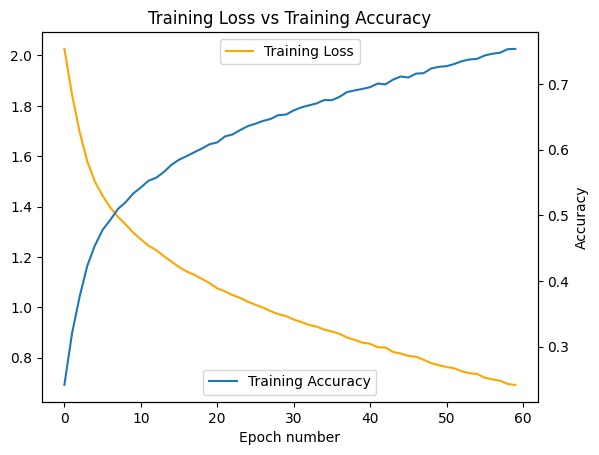

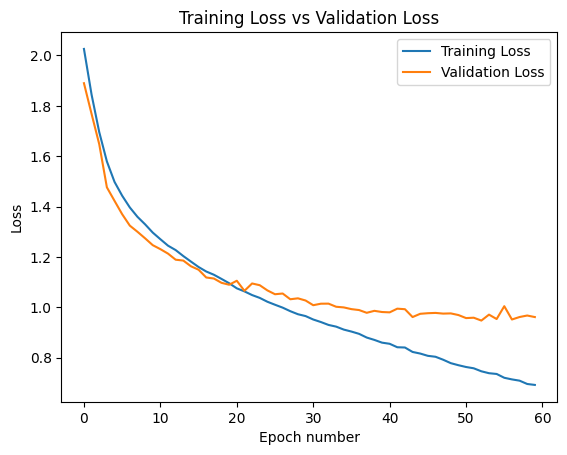

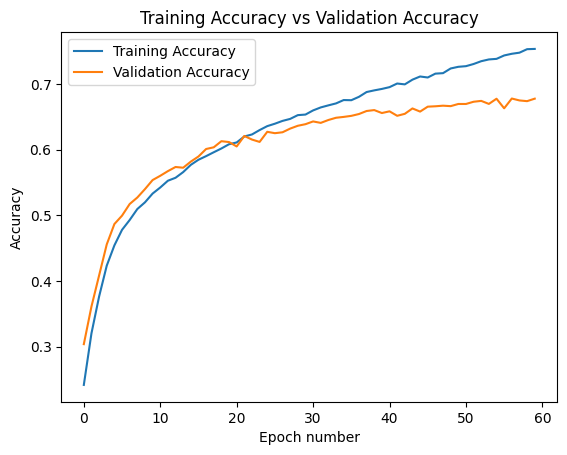

In [15]:
config_data = default_config_data.copy()
vit_model, train_loss_data, valid_loss_data, train_acc_data, valid_acc_data = train_test_model(train_dataset, test_dataset, config_data)
# saving the model so that can load it later and use it's attention weights for visulization purpose.
torch.save(vit_model.state_dict(), 'my_vit_model.pth')

train_length = 2500 validation_length = 47500


Validation Epoch 000: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 19.05it/s]


epoch = 0, Train Loss: 2.2012, Validation Loss: 2.2165, Train Accuracy: 14.20%, Validation Accuracy: 18.35%


Validation Epoch 001: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 19.06it/s]


epoch = 1, Train Loss: 2.0920, Validation Loss: 2.1448, Train Accuracy: 18.92%, Validation Accuracy: 19.46%


Validation Epoch 002: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 18.92it/s]


epoch = 2, Train Loss: 2.0356, Validation Loss: 2.0985, Train Accuracy: 21.44%, Validation Accuracy: 20.96%


Validation Epoch 003: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 18.91it/s]


epoch = 3, Train Loss: 1.9896, Validation Loss: 2.0523, Train Accuracy: 22.96%, Validation Accuracy: 22.75%


Validation Epoch 004: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 19.00it/s]


epoch = 4, Train Loss: 1.9457, Validation Loss: 2.0198, Train Accuracy: 24.68%, Validation Accuracy: 24.84%


Validation Epoch 005: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 19.03it/s]


epoch = 5, Train Loss: 1.9160, Validation Loss: 2.0021, Train Accuracy: 24.32%, Validation Accuracy: 25.51%


Validation Epoch 006: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 18.95it/s]


epoch = 6, Train Loss: 1.9006, Validation Loss: 1.9914, Train Accuracy: 26.84%, Validation Accuracy: 26.72%


Validation Epoch 007: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 18.97it/s]


epoch = 7, Train Loss: 1.8760, Validation Loss: 1.9733, Train Accuracy: 27.56%, Validation Accuracy: 26.88%


Validation Epoch 008: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 19.02it/s]


epoch = 8, Train Loss: 1.8571, Validation Loss: 1.9717, Train Accuracy: 28.76%, Validation Accuracy: 27.34%


Validation Epoch 009: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 18.96it/s]


epoch = 9, Train Loss: 1.8595, Validation Loss: 1.9696, Train Accuracy: 28.04%, Validation Accuracy: 27.41%


Validation Epoch 010: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 18.94it/s]


epoch = 10, Train Loss: 1.8285, Validation Loss: 1.9687, Train Accuracy: 29.56%, Validation Accuracy: 27.88%


Validation Epoch 011: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 19.08it/s]


epoch = 11, Train Loss: 1.8459, Validation Loss: 1.9539, Train Accuracy: 28.60%, Validation Accuracy: 28.12%


Validation Epoch 012: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 19.00it/s]


epoch = 12, Train Loss: 1.8235, Validation Loss: 1.9554, Train Accuracy: 29.60%, Validation Accuracy: 28.51%


Validation Epoch 013: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 19.05it/s]


epoch = 13, Train Loss: 1.8240, Validation Loss: 1.9506, Train Accuracy: 28.92%, Validation Accuracy: 29.03%


Validation Epoch 014: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 18.98it/s]


epoch = 14, Train Loss: 1.8176, Validation Loss: 1.9533, Train Accuracy: 29.92%, Validation Accuracy: 28.91%


Validation Epoch 015: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 19.02it/s]


epoch = 15, Train Loss: 1.8012, Validation Loss: 1.9231, Train Accuracy: 31.00%, Validation Accuracy: 30.26%


Validation Epoch 016: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 18.99it/s]


epoch = 16, Train Loss: 1.7938, Validation Loss: 1.9172, Train Accuracy: 31.32%, Validation Accuracy: 29.82%


Validation Epoch 017: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 18.95it/s]


epoch = 17, Train Loss: 1.7914, Validation Loss: 1.9111, Train Accuracy: 31.52%, Validation Accuracy: 30.44%


Validation Epoch 018: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 18.98it/s]


epoch = 18, Train Loss: 1.7832, Validation Loss: 1.9108, Train Accuracy: 30.48%, Validation Accuracy: 30.04%


Validation Epoch 019: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 19.03it/s]


epoch = 19, Train Loss: 1.7595, Validation Loss: 1.9058, Train Accuracy: 32.32%, Validation Accuracy: 30.79%


Validation Epoch 020: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 18.94it/s]


epoch = 20, Train Loss: 1.7595, Validation Loss: 1.8933, Train Accuracy: 33.00%, Validation Accuracy: 31.37%


Validation Epoch 021: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 19.06it/s]


epoch = 21, Train Loss: 1.7554, Validation Loss: 1.9025, Train Accuracy: 32.08%, Validation Accuracy: 30.89%


Validation Epoch 022: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 18.95it/s]


epoch = 22, Train Loss: 1.7325, Validation Loss: 1.8797, Train Accuracy: 33.72%, Validation Accuracy: 31.75%


Validation Epoch 023: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 19.06it/s]


epoch = 23, Train Loss: 1.7230, Validation Loss: 1.9033, Train Accuracy: 33.00%, Validation Accuracy: 31.67%


Validation Epoch 024: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 19.03it/s]


epoch = 24, Train Loss: 1.7294, Validation Loss: 1.8777, Train Accuracy: 34.20%, Validation Accuracy: 32.19%


Validation Epoch 025: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 19.07it/s]


epoch = 25, Train Loss: 1.7138, Validation Loss: 1.8697, Train Accuracy: 34.32%, Validation Accuracy: 33.10%


Validation Epoch 026: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 18.99it/s]


epoch = 26, Train Loss: 1.6955, Validation Loss: 1.8617, Train Accuracy: 35.68%, Validation Accuracy: 33.27%


Validation Epoch 027: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 18.94it/s]


epoch = 27, Train Loss: 1.6907, Validation Loss: 1.8527, Train Accuracy: 35.76%, Validation Accuracy: 33.74%


Validation Epoch 028: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 18.98it/s]


epoch = 28, Train Loss: 1.6776, Validation Loss: 1.8856, Train Accuracy: 36.20%, Validation Accuracy: 33.16%


Validation Epoch 029: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 18.99it/s]


epoch = 29, Train Loss: 1.6523, Validation Loss: 1.8480, Train Accuracy: 37.40%, Validation Accuracy: 34.54%


Validation Epoch 030: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 18.99it/s]


epoch = 30, Train Loss: 1.6484, Validation Loss: 1.8164, Train Accuracy: 37.36%, Validation Accuracy: 35.25%


Validation Epoch 031: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 18.98it/s]


epoch = 31, Train Loss: 1.6335, Validation Loss: 1.8089, Train Accuracy: 38.72%, Validation Accuracy: 35.71%


Validation Epoch 032: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 19.09it/s]


epoch = 32, Train Loss: 1.6138, Validation Loss: 1.8294, Train Accuracy: 38.04%, Validation Accuracy: 35.88%


Validation Epoch 033: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 19.04it/s]


epoch = 33, Train Loss: 1.6014, Validation Loss: 1.8643, Train Accuracy: 39.08%, Validation Accuracy: 35.71%


Validation Epoch 034: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 19.07it/s]


epoch = 34, Train Loss: 1.5951, Validation Loss: 1.8109, Train Accuracy: 38.52%, Validation Accuracy: 35.55%


Validation Epoch 035: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 19.06it/s]


epoch = 35, Train Loss: 1.5741, Validation Loss: 1.8009, Train Accuracy: 39.72%, Validation Accuracy: 36.86%


Validation Epoch 036: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 19.10it/s]


epoch = 36, Train Loss: 1.5583, Validation Loss: 1.7920, Train Accuracy: 40.76%, Validation Accuracy: 36.89%


Validation Epoch 037: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 19.04it/s]


epoch = 37, Train Loss: 1.5581, Validation Loss: 1.8007, Train Accuracy: 40.68%, Validation Accuracy: 36.81%


Validation Epoch 038: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 19.09it/s]


epoch = 38, Train Loss: 1.5529, Validation Loss: 1.8123, Train Accuracy: 39.32%, Validation Accuracy: 37.60%


Validation Epoch 039: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 19.01it/s]


epoch = 39, Train Loss: 1.5309, Validation Loss: 1.7875, Train Accuracy: 42.56%, Validation Accuracy: 37.78%


Validation Epoch 040: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 19.01it/s]


epoch = 40, Train Loss: 1.5115, Validation Loss: 1.7518, Train Accuracy: 41.88%, Validation Accuracy: 38.45%


Validation Epoch 041: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 19.10it/s]


epoch = 41, Train Loss: 1.5047, Validation Loss: 1.7718, Train Accuracy: 43.64%, Validation Accuracy: 38.60%


Validation Epoch 042: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 18.96it/s]


epoch = 42, Train Loss: 1.4872, Validation Loss: 1.7730, Train Accuracy: 42.88%, Validation Accuracy: 38.63%


Validation Epoch 043: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 18.99it/s]


epoch = 43, Train Loss: 1.4767, Validation Loss: 1.7790, Train Accuracy: 44.32%, Validation Accuracy: 38.18%


Validation Epoch 044: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 18.94it/s]


epoch = 44, Train Loss: 1.4669, Validation Loss: 1.7821, Train Accuracy: 43.32%, Validation Accuracy: 38.77%


Validation Epoch 045: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 18.96it/s]


epoch = 45, Train Loss: 1.4838, Validation Loss: 1.7812, Train Accuracy: 43.12%, Validation Accuracy: 38.76%


Validation Epoch 046: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 18.93it/s]


epoch = 46, Train Loss: 1.4761, Validation Loss: 1.8039, Train Accuracy: 43.80%, Validation Accuracy: 38.09%


Validation Epoch 047: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 18.97it/s]


epoch = 47, Train Loss: 1.4463, Validation Loss: 1.7326, Train Accuracy: 44.92%, Validation Accuracy: 39.82%


Validation Epoch 048: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 19.00it/s]


epoch = 48, Train Loss: 1.4157, Validation Loss: 1.7557, Train Accuracy: 47.00%, Validation Accuracy: 39.66%


Validation Epoch 049: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 18.93it/s]


epoch = 49, Train Loss: 1.4193, Validation Loss: 1.7307, Train Accuracy: 46.04%, Validation Accuracy: 40.13%


Validation Epoch 050: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 18.96it/s]


epoch = 50, Train Loss: 1.4006, Validation Loss: 1.7489, Train Accuracy: 46.56%, Validation Accuracy: 40.29%


Validation Epoch 051: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 19.00it/s]


epoch = 51, Train Loss: 1.3872, Validation Loss: 1.7332, Train Accuracy: 47.44%, Validation Accuracy: 40.57%


Validation Epoch 052: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 19.07it/s]


epoch = 52, Train Loss: 1.3734, Validation Loss: 1.7309, Train Accuracy: 47.80%, Validation Accuracy: 41.45%


Validation Epoch 053: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 19.08it/s]


epoch = 53, Train Loss: 1.3664, Validation Loss: 1.7388, Train Accuracy: 49.52%, Validation Accuracy: 41.17%


Validation Epoch 054: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 19.02it/s]


epoch = 54, Train Loss: 1.3451, Validation Loss: 1.7130, Train Accuracy: 51.00%, Validation Accuracy: 41.56%


Validation Epoch 055: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 19.05it/s]


epoch = 55, Train Loss: 1.3467, Validation Loss: 1.7156, Train Accuracy: 48.96%, Validation Accuracy: 42.24%


Validation Epoch 056: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 19.06it/s]


epoch = 56, Train Loss: 1.3206, Validation Loss: 1.7261, Train Accuracy: 51.08%, Validation Accuracy: 41.54%


Validation Epoch 057: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 18.98it/s]


epoch = 57, Train Loss: 1.3216, Validation Loss: 1.7008, Train Accuracy: 49.88%, Validation Accuracy: 42.49%


Validation Epoch 058: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 18.99it/s]


epoch = 58, Train Loss: 1.2980, Validation Loss: 1.7021, Train Accuracy: 51.60%, Validation Accuracy: 42.73%


Validation Epoch 059: 100%|████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:19<00:00, 19.02it/s]


epoch = 59, Train Loss: 1.3129, Validation Loss: 1.7322, Train Accuracy: 50.32%, Validation Accuracy: 42.43%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.62it/s]


For model trained on  5.00% data with 4 heads and 4 x 4 non-overlapping patches,
	Train Accuracy is  43.11%
	Test Accuracy is  42.81%


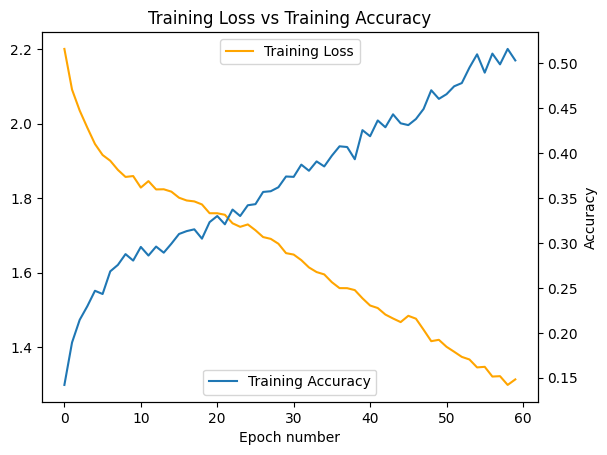

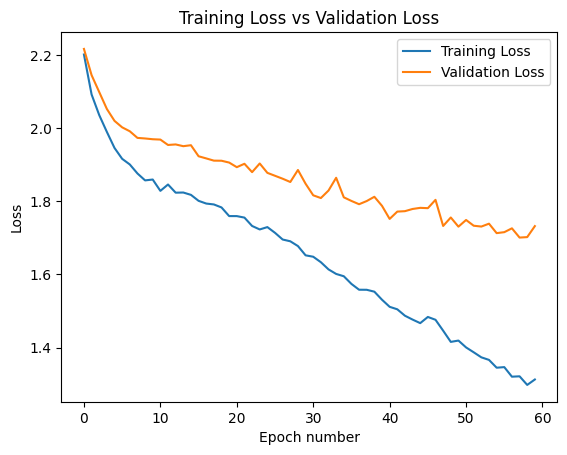

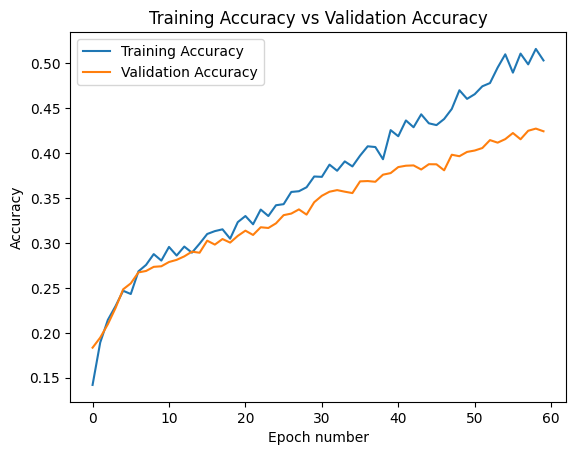

train_length = 5000 validation_length = 45000


Validation Epoch 000: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.65it/s]


epoch = 0, Train Loss: 2.1774, Validation Loss: 2.1175, Train Accuracy: 16.24%, Validation Accuracy: 21.28%


Validation Epoch 001: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.75it/s]


epoch = 1, Train Loss: 2.0554, Validation Loss: 2.0635, Train Accuracy: 21.56%, Validation Accuracy: 25.18%


Validation Epoch 002: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.80it/s]


epoch = 2, Train Loss: 1.9916, Validation Loss: 2.0201, Train Accuracy: 22.38%, Validation Accuracy: 25.24%


Validation Epoch 003: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.72it/s]


epoch = 3, Train Loss: 1.9606, Validation Loss: 1.9909, Train Accuracy: 25.40%, Validation Accuracy: 26.82%


Validation Epoch 004: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.69it/s]


epoch = 4, Train Loss: 1.9393, Validation Loss: 1.9585, Train Accuracy: 26.16%, Validation Accuracy: 28.54%


Validation Epoch 005: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.72it/s]


epoch = 5, Train Loss: 1.9247, Validation Loss: 1.9451, Train Accuracy: 26.82%, Validation Accuracy: 28.11%


Validation Epoch 006: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.67it/s]


epoch = 6, Train Loss: 1.9004, Validation Loss: 1.9501, Train Accuracy: 27.10%, Validation Accuracy: 28.54%


Validation Epoch 007: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.74it/s]


epoch = 7, Train Loss: 1.8797, Validation Loss: 1.9305, Train Accuracy: 28.90%, Validation Accuracy: 29.92%


Validation Epoch 008: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.70it/s]


epoch = 8, Train Loss: 1.8620, Validation Loss: 1.9056, Train Accuracy: 29.50%, Validation Accuracy: 30.32%


Validation Epoch 009: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.71it/s]


epoch = 9, Train Loss: 1.8549, Validation Loss: 1.9050, Train Accuracy: 29.86%, Validation Accuracy: 30.15%


Validation Epoch 010: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.74it/s]


epoch = 10, Train Loss: 1.8224, Validation Loss: 1.9055, Train Accuracy: 32.26%, Validation Accuracy: 31.12%


Validation Epoch 011: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.69it/s]


epoch = 11, Train Loss: 1.8296, Validation Loss: 1.8733, Train Accuracy: 31.94%, Validation Accuracy: 32.48%


Validation Epoch 012: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.69it/s]


epoch = 12, Train Loss: 1.7949, Validation Loss: 1.8788, Train Accuracy: 32.70%, Validation Accuracy: 32.08%


Validation Epoch 013: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.71it/s]


epoch = 13, Train Loss: 1.7848, Validation Loss: 1.8456, Train Accuracy: 34.38%, Validation Accuracy: 32.94%


Validation Epoch 014: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.67it/s]


epoch = 14, Train Loss: 1.7683, Validation Loss: 1.8412, Train Accuracy: 34.54%, Validation Accuracy: 33.54%


Validation Epoch 015: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.74it/s]


epoch = 15, Train Loss: 1.7413, Validation Loss: 1.8252, Train Accuracy: 35.28%, Validation Accuracy: 33.90%


Validation Epoch 016: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.74it/s]


epoch = 16, Train Loss: 1.7329, Validation Loss: 1.8061, Train Accuracy: 35.18%, Validation Accuracy: 34.62%


Validation Epoch 017: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.77it/s]


epoch = 17, Train Loss: 1.7097, Validation Loss: 1.7937, Train Accuracy: 36.00%, Validation Accuracy: 35.34%


Validation Epoch 018: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.72it/s]


epoch = 18, Train Loss: 1.6621, Validation Loss: 1.8142, Train Accuracy: 37.80%, Validation Accuracy: 35.25%


Validation Epoch 019: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.76it/s]


epoch = 19, Train Loss: 1.6645, Validation Loss: 1.8057, Train Accuracy: 37.38%, Validation Accuracy: 35.65%


Validation Epoch 020: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.72it/s]


epoch = 20, Train Loss: 1.6527, Validation Loss: 1.7325, Train Accuracy: 40.00%, Validation Accuracy: 38.05%


Validation Epoch 021: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.67it/s]


epoch = 21, Train Loss: 1.6391, Validation Loss: 1.7490, Train Accuracy: 38.54%, Validation Accuracy: 37.92%


Validation Epoch 022: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.72it/s]


epoch = 22, Train Loss: 1.6042, Validation Loss: 1.7442, Train Accuracy: 40.56%, Validation Accuracy: 37.92%


Validation Epoch 023: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.73it/s]


epoch = 23, Train Loss: 1.5994, Validation Loss: 1.7027, Train Accuracy: 40.06%, Validation Accuracy: 39.36%


Validation Epoch 024: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.76it/s]


epoch = 24, Train Loss: 1.5655, Validation Loss: 1.6822, Train Accuracy: 42.36%, Validation Accuracy: 41.04%


Validation Epoch 025: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.67it/s]


epoch = 25, Train Loss: 1.5592, Validation Loss: 1.6887, Train Accuracy: 42.20%, Validation Accuracy: 40.52%


Validation Epoch 026: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.72it/s]


epoch = 26, Train Loss: 1.5414, Validation Loss: 1.6667, Train Accuracy: 42.20%, Validation Accuracy: 41.26%


Validation Epoch 027: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.74it/s]


epoch = 27, Train Loss: 1.5241, Validation Loss: 1.7263, Train Accuracy: 43.36%, Validation Accuracy: 40.98%


Validation Epoch 028: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.73it/s]


epoch = 28, Train Loss: 1.4968, Validation Loss: 1.6647, Train Accuracy: 44.42%, Validation Accuracy: 41.66%


Validation Epoch 029: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.66it/s]


epoch = 29, Train Loss: 1.4848, Validation Loss: 1.6706, Train Accuracy: 44.82%, Validation Accuracy: 41.66%


Validation Epoch 030: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.71it/s]


epoch = 30, Train Loss: 1.4807, Validation Loss: 1.6349, Train Accuracy: 44.38%, Validation Accuracy: 43.36%


Validation Epoch 031: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.70it/s]


epoch = 31, Train Loss: 1.4586, Validation Loss: 1.5984, Train Accuracy: 46.14%, Validation Accuracy: 44.02%


Validation Epoch 032: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.75it/s]


epoch = 32, Train Loss: 1.4294, Validation Loss: 1.6151, Train Accuracy: 47.36%, Validation Accuracy: 43.73%


Validation Epoch 033: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.69it/s]


epoch = 33, Train Loss: 1.4348, Validation Loss: 1.6272, Train Accuracy: 48.06%, Validation Accuracy: 43.54%


Validation Epoch 034: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.69it/s]


epoch = 34, Train Loss: 1.4063, Validation Loss: 1.6127, Train Accuracy: 48.04%, Validation Accuracy: 44.24%


Validation Epoch 035: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.68it/s]


epoch = 35, Train Loss: 1.3889, Validation Loss: 1.5785, Train Accuracy: 48.78%, Validation Accuracy: 45.24%


Validation Epoch 036: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.77it/s]


epoch = 36, Train Loss: 1.3749, Validation Loss: 1.5884, Train Accuracy: 49.30%, Validation Accuracy: 45.22%


Validation Epoch 037: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.69it/s]


epoch = 37, Train Loss: 1.3729, Validation Loss: 1.6084, Train Accuracy: 50.12%, Validation Accuracy: 45.56%


Validation Epoch 038: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.80it/s]


epoch = 38, Train Loss: 1.3609, Validation Loss: 1.5651, Train Accuracy: 49.94%, Validation Accuracy: 46.10%


Validation Epoch 039: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.77it/s]


epoch = 39, Train Loss: 1.3465, Validation Loss: 1.5574, Train Accuracy: 50.04%, Validation Accuracy: 46.71%


Validation Epoch 040: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.72it/s]


epoch = 40, Train Loss: 1.3275, Validation Loss: 1.5778, Train Accuracy: 50.70%, Validation Accuracy: 45.70%


Validation Epoch 041: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.66it/s]


epoch = 41, Train Loss: 1.3368, Validation Loss: 1.5758, Train Accuracy: 50.18%, Validation Accuracy: 45.69%


Validation Epoch 042: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.73it/s]


epoch = 42, Train Loss: 1.3428, Validation Loss: 1.5583, Train Accuracy: 50.28%, Validation Accuracy: 46.50%


Validation Epoch 043: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.66it/s]


epoch = 43, Train Loss: 1.2975, Validation Loss: 1.5576, Train Accuracy: 51.92%, Validation Accuracy: 47.01%


Validation Epoch 044: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.66it/s]


epoch = 44, Train Loss: 1.2957, Validation Loss: 1.5492, Train Accuracy: 52.82%, Validation Accuracy: 47.12%


Validation Epoch 045: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.72it/s]


epoch = 45, Train Loss: 1.2921, Validation Loss: 1.5256, Train Accuracy: 51.80%, Validation Accuracy: 47.70%


Validation Epoch 046: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.78it/s]


epoch = 46, Train Loss: 1.2830, Validation Loss: 1.5468, Train Accuracy: 52.78%, Validation Accuracy: 47.08%


Validation Epoch 047: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.69it/s]


epoch = 47, Train Loss: 1.2803, Validation Loss: 1.5563, Train Accuracy: 52.96%, Validation Accuracy: 46.91%


Validation Epoch 048: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.69it/s]


epoch = 48, Train Loss: 1.2508, Validation Loss: 1.5290, Train Accuracy: 53.80%, Validation Accuracy: 47.91%


Validation Epoch 049: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.68it/s]


epoch = 49, Train Loss: 1.2474, Validation Loss: 1.5591, Train Accuracy: 54.36%, Validation Accuracy: 47.40%


Validation Epoch 050: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.73it/s]


epoch = 50, Train Loss: 1.2464, Validation Loss: 1.5374, Train Accuracy: 53.74%, Validation Accuracy: 48.19%


Validation Epoch 051: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.65it/s]


epoch = 51, Train Loss: 1.2351, Validation Loss: 1.5373, Train Accuracy: 54.56%, Validation Accuracy: 47.74%


Validation Epoch 052: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.68it/s]


epoch = 52, Train Loss: 1.2296, Validation Loss: 1.5432, Train Accuracy: 55.80%, Validation Accuracy: 47.58%


Validation Epoch 053: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.70it/s]


epoch = 53, Train Loss: 1.2169, Validation Loss: 1.5158, Train Accuracy: 55.12%, Validation Accuracy: 48.31%


Validation Epoch 054: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.74it/s]


epoch = 54, Train Loss: 1.1957, Validation Loss: 1.5027, Train Accuracy: 56.72%, Validation Accuracy: 49.02%


Validation Epoch 055: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.72it/s]


epoch = 55, Train Loss: 1.1727, Validation Loss: 1.5299, Train Accuracy: 57.20%, Validation Accuracy: 48.62%


Validation Epoch 056: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.77it/s]


epoch = 56, Train Loss: 1.1630, Validation Loss: 1.5195, Train Accuracy: 57.78%, Validation Accuracy: 48.70%


Validation Epoch 057: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.70it/s]


epoch = 57, Train Loss: 1.1648, Validation Loss: 1.5356, Train Accuracy: 57.70%, Validation Accuracy: 48.79%


Validation Epoch 058: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.69it/s]


epoch = 58, Train Loss: 1.1685, Validation Loss: 1.5028, Train Accuracy: 57.86%, Validation Accuracy: 49.28%


Validation Epoch 059: 100%|████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:18<00:00, 18.69it/s]


epoch = 59, Train Loss: 1.1594, Validation Loss: 1.4989, Train Accuracy: 57.28%, Validation Accuracy: 49.65%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.46it/s]


For model trained on  10.00% data with 4 heads and 4 x 4 non-overlapping patches,
	Train Accuracy is  51.14%
	Test Accuracy is  49.38%


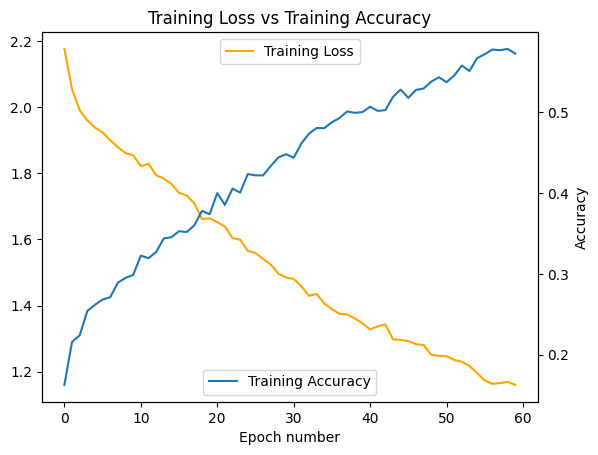

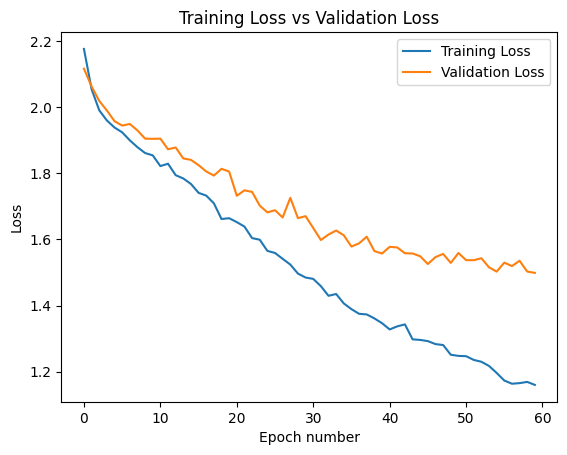

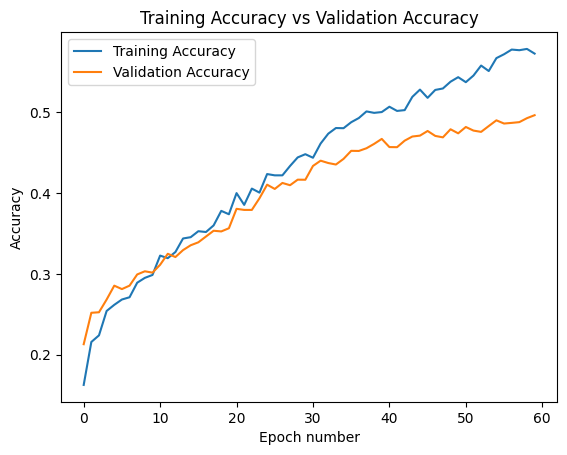

train_length = 12500 validation_length = 37500


Validation Epoch 000: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.85it/s]


epoch = 0, Train Loss: 2.1377, Validation Loss: 2.0415, Train Accuracy: 18.70%, Validation Accuracy: 23.16%


Validation Epoch 001: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.85it/s]


epoch = 1, Train Loss: 2.0100, Validation Loss: 1.9566, Train Accuracy: 24.47%, Validation Accuracy: 27.33%


Validation Epoch 002: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.89it/s]


epoch = 2, Train Loss: 1.9472, Validation Loss: 1.9208, Train Accuracy: 27.40%, Validation Accuracy: 27.85%


Validation Epoch 003: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.89it/s]


epoch = 3, Train Loss: 1.9032, Validation Loss: 1.8838, Train Accuracy: 29.18%, Validation Accuracy: 30.06%


Validation Epoch 004: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.85it/s]


epoch = 4, Train Loss: 1.8532, Validation Loss: 1.8831, Train Accuracy: 31.38%, Validation Accuracy: 30.71%


Validation Epoch 005: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.83it/s]


epoch = 5, Train Loss: 1.8055, Validation Loss: 1.7972, Train Accuracy: 33.28%, Validation Accuracy: 34.79%


Validation Epoch 006: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.83it/s]


epoch = 6, Train Loss: 1.7582, Validation Loss: 1.7685, Train Accuracy: 34.69%, Validation Accuracy: 36.29%


Validation Epoch 007: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.86it/s]


epoch = 7, Train Loss: 1.7188, Validation Loss: 1.7167, Train Accuracy: 36.38%, Validation Accuracy: 37.50%


Validation Epoch 008: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.86it/s]


epoch = 8, Train Loss: 1.6775, Validation Loss: 1.7054, Train Accuracy: 38.01%, Validation Accuracy: 37.86%


Validation Epoch 009: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.84it/s]


epoch = 9, Train Loss: 1.6389, Validation Loss: 1.6715, Train Accuracy: 39.31%, Validation Accuracy: 39.88%


Validation Epoch 010: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.91it/s]


epoch = 10, Train Loss: 1.6056, Validation Loss: 1.6129, Train Accuracy: 40.58%, Validation Accuracy: 42.32%


Validation Epoch 011: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.87it/s]


epoch = 11, Train Loss: 1.5772, Validation Loss: 1.5645, Train Accuracy: 41.94%, Validation Accuracy: 43.80%


Validation Epoch 012: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.90it/s]


epoch = 12, Train Loss: 1.5398, Validation Loss: 1.5806, Train Accuracy: 43.50%, Validation Accuracy: 43.94%


Validation Epoch 013: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.86it/s]


epoch = 13, Train Loss: 1.5176, Validation Loss: 1.5490, Train Accuracy: 44.41%, Validation Accuracy: 43.85%


Validation Epoch 014: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.92it/s]


epoch = 14, Train Loss: 1.4936, Validation Loss: 1.5111, Train Accuracy: 45.43%, Validation Accuracy: 46.19%


Validation Epoch 015: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.92it/s]


epoch = 15, Train Loss: 1.4652, Validation Loss: 1.5075, Train Accuracy: 47.11%, Validation Accuracy: 46.72%


Validation Epoch 016: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.88it/s]


epoch = 16, Train Loss: 1.4478, Validation Loss: 1.5417, Train Accuracy: 47.11%, Validation Accuracy: 45.54%


Validation Epoch 017: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.85it/s]


epoch = 17, Train Loss: 1.4336, Validation Loss: 1.4880, Train Accuracy: 47.51%, Validation Accuracy: 47.39%


Validation Epoch 018: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.82it/s]


epoch = 18, Train Loss: 1.4137, Validation Loss: 1.4839, Train Accuracy: 48.33%, Validation Accuracy: 47.71%


Validation Epoch 019: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.85it/s]


epoch = 19, Train Loss: 1.4000, Validation Loss: 1.4571, Train Accuracy: 48.66%, Validation Accuracy: 48.35%


Validation Epoch 020: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.88it/s]


epoch = 20, Train Loss: 1.3821, Validation Loss: 1.4682, Train Accuracy: 49.56%, Validation Accuracy: 48.64%


Validation Epoch 021: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.86it/s]


epoch = 21, Train Loss: 1.3678, Validation Loss: 1.4221, Train Accuracy: 50.17%, Validation Accuracy: 49.57%


Validation Epoch 022: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.85it/s]


epoch = 22, Train Loss: 1.3536, Validation Loss: 1.4009, Train Accuracy: 50.58%, Validation Accuracy: 50.50%


Validation Epoch 023: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.82it/s]


epoch = 23, Train Loss: 1.3272, Validation Loss: 1.3944, Train Accuracy: 52.27%, Validation Accuracy: 50.99%


Validation Epoch 024: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.87it/s]


epoch = 24, Train Loss: 1.3199, Validation Loss: 1.4054, Train Accuracy: 52.34%, Validation Accuracy: 50.55%


Validation Epoch 025: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.82it/s]


epoch = 25, Train Loss: 1.3067, Validation Loss: 1.4131, Train Accuracy: 53.01%, Validation Accuracy: 50.35%


Validation Epoch 026: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.87it/s]


epoch = 26, Train Loss: 1.2952, Validation Loss: 1.3555, Train Accuracy: 53.05%, Validation Accuracy: 52.57%


Validation Epoch 027: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.89it/s]


epoch = 27, Train Loss: 1.2885, Validation Loss: 1.3703, Train Accuracy: 53.16%, Validation Accuracy: 52.21%


Validation Epoch 028: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.93it/s]


epoch = 28, Train Loss: 1.2668, Validation Loss: 1.3504, Train Accuracy: 54.21%, Validation Accuracy: 52.72%


Validation Epoch 029: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.89it/s]


epoch = 29, Train Loss: 1.2508, Validation Loss: 1.3726, Train Accuracy: 54.69%, Validation Accuracy: 52.30%


Validation Epoch 030: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.85it/s]


epoch = 30, Train Loss: 1.2487, Validation Loss: 1.4039, Train Accuracy: 54.86%, Validation Accuracy: 51.56%


Validation Epoch 031: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.84it/s]


epoch = 31, Train Loss: 1.2464, Validation Loss: 1.3580, Train Accuracy: 54.86%, Validation Accuracy: 52.53%


Validation Epoch 032: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.87it/s]


epoch = 32, Train Loss: 1.2201, Validation Loss: 1.3491, Train Accuracy: 55.85%, Validation Accuracy: 52.63%


Validation Epoch 033: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.85it/s]


epoch = 33, Train Loss: 1.2134, Validation Loss: 1.3127, Train Accuracy: 55.98%, Validation Accuracy: 54.10%


Validation Epoch 034: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.84it/s]


epoch = 34, Train Loss: 1.2069, Validation Loss: 1.3169, Train Accuracy: 56.58%, Validation Accuracy: 53.99%


Validation Epoch 035: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.85it/s]


epoch = 35, Train Loss: 1.1837, Validation Loss: 1.3117, Train Accuracy: 57.16%, Validation Accuracy: 54.23%


Validation Epoch 036: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.93it/s]


epoch = 36, Train Loss: 1.1822, Validation Loss: 1.2854, Train Accuracy: 58.06%, Validation Accuracy: 55.04%


Validation Epoch 037: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.90it/s]


epoch = 37, Train Loss: 1.1661, Validation Loss: 1.3166, Train Accuracy: 57.62%, Validation Accuracy: 54.49%


Validation Epoch 038: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.87it/s]


epoch = 38, Train Loss: 1.1594, Validation Loss: 1.3110, Train Accuracy: 58.38%, Validation Accuracy: 54.68%


Validation Epoch 039: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.84it/s]


epoch = 39, Train Loss: 1.1500, Validation Loss: 1.3158, Train Accuracy: 59.14%, Validation Accuracy: 54.26%


Validation Epoch 040: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.88it/s]


epoch = 40, Train Loss: 1.1436, Validation Loss: 1.2997, Train Accuracy: 58.86%, Validation Accuracy: 55.16%


Validation Epoch 041: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.86it/s]


epoch = 41, Train Loss: 1.1208, Validation Loss: 1.2915, Train Accuracy: 60.03%, Validation Accuracy: 55.55%


Validation Epoch 042: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.94it/s]


epoch = 42, Train Loss: 1.1198, Validation Loss: 1.2958, Train Accuracy: 59.78%, Validation Accuracy: 55.31%


Validation Epoch 043: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.86it/s]


epoch = 43, Train Loss: 1.1118, Validation Loss: 1.3054, Train Accuracy: 60.17%, Validation Accuracy: 55.27%


Validation Epoch 044: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.84it/s]


epoch = 44, Train Loss: 1.1095, Validation Loss: 1.2897, Train Accuracy: 60.14%, Validation Accuracy: 55.58%


Validation Epoch 045: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.82it/s]


epoch = 45, Train Loss: 1.0902, Validation Loss: 1.3065, Train Accuracy: 60.93%, Validation Accuracy: 55.34%


Validation Epoch 046: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.86it/s]


epoch = 46, Train Loss: 1.0885, Validation Loss: 1.2755, Train Accuracy: 60.74%, Validation Accuracy: 56.14%


Validation Epoch 047: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.91it/s]


epoch = 47, Train Loss: 1.0818, Validation Loss: 1.2742, Train Accuracy: 61.22%, Validation Accuracy: 56.13%


Validation Epoch 048: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.87it/s]


epoch = 48, Train Loss: 1.0664, Validation Loss: 1.2952, Train Accuracy: 61.80%, Validation Accuracy: 55.86%


Validation Epoch 049: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.89it/s]


epoch = 49, Train Loss: 1.0637, Validation Loss: 1.2515, Train Accuracy: 62.11%, Validation Accuracy: 56.90%


Validation Epoch 050: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.75it/s]


epoch = 50, Train Loss: 1.0560, Validation Loss: 1.2604, Train Accuracy: 61.79%, Validation Accuracy: 56.61%


Validation Epoch 051: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.87it/s]


epoch = 51, Train Loss: 1.0433, Validation Loss: 1.2832, Train Accuracy: 62.57%, Validation Accuracy: 55.92%


Validation Epoch 052: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.87it/s]


epoch = 52, Train Loss: 1.0333, Validation Loss: 1.2712, Train Accuracy: 62.80%, Validation Accuracy: 56.32%


Validation Epoch 053: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.85it/s]


epoch = 53, Train Loss: 1.0184, Validation Loss: 1.2463, Train Accuracy: 63.59%, Validation Accuracy: 57.17%


Validation Epoch 054: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.86it/s]


epoch = 54, Train Loss: 1.0097, Validation Loss: 1.2646, Train Accuracy: 63.93%, Validation Accuracy: 57.08%


Validation Epoch 055: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.86it/s]


epoch = 55, Train Loss: 1.0000, Validation Loss: 1.2609, Train Accuracy: 64.22%, Validation Accuracy: 56.86%


Validation Epoch 056: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.91it/s]


epoch = 56, Train Loss: 1.0043, Validation Loss: 1.2542, Train Accuracy: 63.98%, Validation Accuracy: 57.27%


Validation Epoch 057: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.93it/s]


epoch = 57, Train Loss: 0.9785, Validation Loss: 1.2542, Train Accuracy: 65.07%, Validation Accuracy: 57.42%


Validation Epoch 058: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.86it/s]


epoch = 58, Train Loss: 0.9719, Validation Loss: 1.2730, Train Accuracy: 65.28%, Validation Accuracy: 56.68%


Validation Epoch 059: 100%|████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:15<00:00, 18.86it/s]


epoch = 59, Train Loss: 0.9628, Validation Loss: 1.2498, Train Accuracy: 65.77%, Validation Accuracy: 57.65%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.53it/s]


For model trained on  25.00% data with 4 heads and 4 x 4 non-overlapping patches,
	Train Accuracy is  61.58%
	Test Accuracy is  57.53%


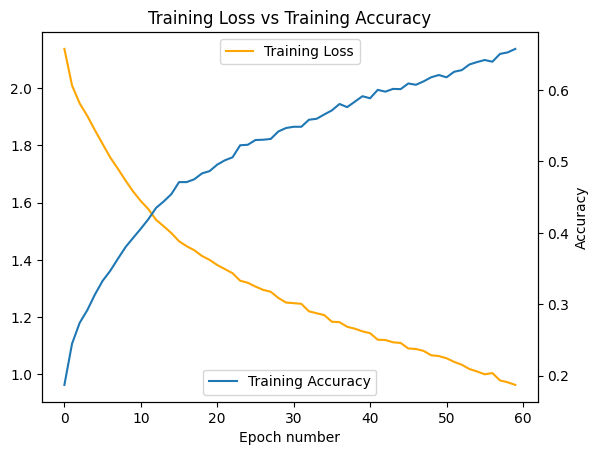

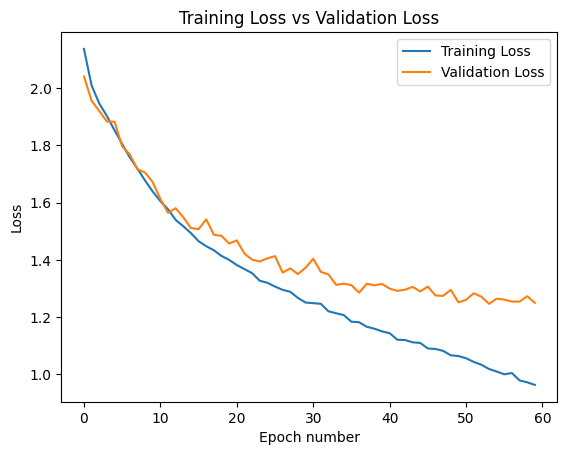

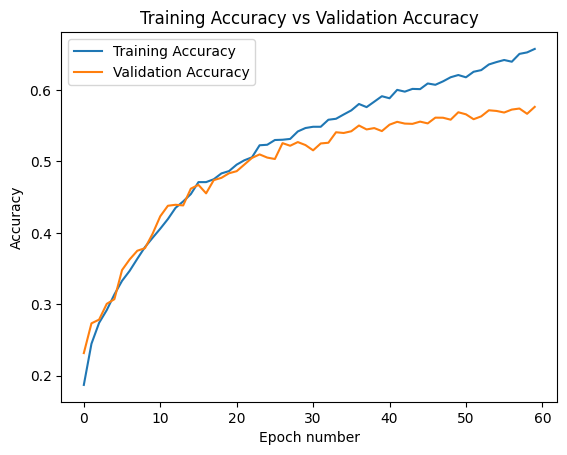

train_length = 25000 validation_length = 25000


Validation Epoch 000: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.73it/s]


epoch = 0, Train Loss: 2.0812, Validation Loss: 1.9586, Train Accuracy: 21.93%, Validation Accuracy: 27.35%


Validation Epoch 001: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.73it/s]


epoch = 1, Train Loss: 1.9402, Validation Loss: 1.8872, Train Accuracy: 28.06%, Validation Accuracy: 30.64%


Validation Epoch 002: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.74it/s]


epoch = 2, Train Loss: 1.8644, Validation Loss: 1.8054, Train Accuracy: 31.29%, Validation Accuracy: 34.45%


Validation Epoch 003: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.73it/s]


epoch = 3, Train Loss: 1.7556, Validation Loss: 1.7431, Train Accuracy: 35.93%, Validation Accuracy: 37.04%


Validation Epoch 004: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.70it/s]


epoch = 4, Train Loss: 1.6594, Validation Loss: 1.6832, Train Accuracy: 39.05%, Validation Accuracy: 39.39%


Validation Epoch 005: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.76it/s]


epoch = 5, Train Loss: 1.5917, Validation Loss: 1.5516, Train Accuracy: 41.44%, Validation Accuracy: 44.76%


Validation Epoch 006: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.86it/s]


epoch = 6, Train Loss: 1.5310, Validation Loss: 1.5604, Train Accuracy: 44.13%, Validation Accuracy: 45.27%


Validation Epoch 007: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.73it/s]


epoch = 7, Train Loss: 1.4939, Validation Loss: 1.4988, Train Accuracy: 45.56%, Validation Accuracy: 46.88%


Validation Epoch 008: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.66it/s]


epoch = 8, Train Loss: 1.4554, Validation Loss: 1.4779, Train Accuracy: 47.35%, Validation Accuracy: 47.73%


Validation Epoch 009: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.65it/s]


epoch = 9, Train Loss: 1.4232, Validation Loss: 1.4620, Train Accuracy: 48.26%, Validation Accuracy: 48.58%


Validation Epoch 010: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.70it/s]


epoch = 10, Train Loss: 1.4040, Validation Loss: 1.3820, Train Accuracy: 49.42%, Validation Accuracy: 51.13%


Validation Epoch 011: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.70it/s]


epoch = 11, Train Loss: 1.3662, Validation Loss: 1.3878, Train Accuracy: 50.59%, Validation Accuracy: 50.81%


Validation Epoch 012: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.70it/s]


epoch = 12, Train Loss: 1.3468, Validation Loss: 1.3536, Train Accuracy: 51.31%, Validation Accuracy: 52.01%


Validation Epoch 013: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.70it/s]


epoch = 13, Train Loss: 1.3294, Validation Loss: 1.3386, Train Accuracy: 51.72%, Validation Accuracy: 52.88%


Validation Epoch 014: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.70it/s]


epoch = 14, Train Loss: 1.3059, Validation Loss: 1.3503, Train Accuracy: 52.74%, Validation Accuracy: 52.61%


Validation Epoch 015: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.69it/s]


epoch = 15, Train Loss: 1.2893, Validation Loss: 1.3142, Train Accuracy: 53.54%, Validation Accuracy: 54.02%


Validation Epoch 016: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.66it/s]


epoch = 16, Train Loss: 1.2679, Validation Loss: 1.2987, Train Accuracy: 53.88%, Validation Accuracy: 54.20%


Validation Epoch 017: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.69it/s]


epoch = 17, Train Loss: 1.2505, Validation Loss: 1.2905, Train Accuracy: 54.91%, Validation Accuracy: 54.77%


Validation Epoch 018: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.69it/s]


epoch = 18, Train Loss: 1.2397, Validation Loss: 1.2678, Train Accuracy: 54.80%, Validation Accuracy: 55.35%


Validation Epoch 019: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.68it/s]


epoch = 19, Train Loss: 1.2192, Validation Loss: 1.2513, Train Accuracy: 55.91%, Validation Accuracy: 56.47%


Validation Epoch 020: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.75it/s]


epoch = 20, Train Loss: 1.2057, Validation Loss: 1.2637, Train Accuracy: 56.46%, Validation Accuracy: 55.94%


Validation Epoch 021: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.69it/s]


epoch = 21, Train Loss: 1.1936, Validation Loss: 1.2235, Train Accuracy: 56.76%, Validation Accuracy: 57.14%


Validation Epoch 022: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.67it/s]


epoch = 22, Train Loss: 1.1752, Validation Loss: 1.2305, Train Accuracy: 57.34%, Validation Accuracy: 57.10%


Validation Epoch 023: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.64it/s]


epoch = 23, Train Loss: 1.1623, Validation Loss: 1.2224, Train Accuracy: 58.58%, Validation Accuracy: 57.61%


Validation Epoch 024: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.62it/s]


epoch = 24, Train Loss: 1.1506, Validation Loss: 1.2063, Train Accuracy: 58.68%, Validation Accuracy: 58.20%


Validation Epoch 025: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.69it/s]


epoch = 25, Train Loss: 1.1419, Validation Loss: 1.2316, Train Accuracy: 59.07%, Validation Accuracy: 57.13%


Validation Epoch 026: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.70it/s]


epoch = 26, Train Loss: 1.1238, Validation Loss: 1.1723, Train Accuracy: 59.72%, Validation Accuracy: 59.18%


Validation Epoch 027: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.72it/s]


epoch = 27, Train Loss: 1.1137, Validation Loss: 1.1667, Train Accuracy: 60.04%, Validation Accuracy: 59.44%


Validation Epoch 028: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.71it/s]


epoch = 28, Train Loss: 1.0985, Validation Loss: 1.2206, Train Accuracy: 61.04%, Validation Accuracy: 57.98%


Validation Epoch 029: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.69it/s]


epoch = 29, Train Loss: 1.0927, Validation Loss: 1.1723, Train Accuracy: 60.88%, Validation Accuracy: 59.26%


Validation Epoch 030: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.65it/s]


epoch = 30, Train Loss: 1.0756, Validation Loss: 1.1718, Train Accuracy: 61.50%, Validation Accuracy: 59.28%


Validation Epoch 031: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.58it/s]


epoch = 31, Train Loss: 1.0689, Validation Loss: 1.1674, Train Accuracy: 61.81%, Validation Accuracy: 59.62%


Validation Epoch 032: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.75it/s]


epoch = 32, Train Loss: 1.0568, Validation Loss: 1.1417, Train Accuracy: 62.30%, Validation Accuracy: 60.58%


Validation Epoch 033: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.68it/s]


epoch = 33, Train Loss: 1.0395, Validation Loss: 1.1560, Train Accuracy: 62.92%, Validation Accuracy: 60.14%


Validation Epoch 034: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.74it/s]


epoch = 34, Train Loss: 1.0356, Validation Loss: 1.1424, Train Accuracy: 62.75%, Validation Accuracy: 60.60%


Validation Epoch 035: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.71it/s]


epoch = 35, Train Loss: 1.0195, Validation Loss: 1.1462, Train Accuracy: 63.24%, Validation Accuracy: 60.70%


Validation Epoch 036: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.73it/s]


epoch = 36, Train Loss: 1.0179, Validation Loss: 1.1197, Train Accuracy: 63.20%, Validation Accuracy: 61.13%


Validation Epoch 037: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.67it/s]


epoch = 37, Train Loss: 1.0120, Validation Loss: 1.1321, Train Accuracy: 63.99%, Validation Accuracy: 61.07%


Validation Epoch 038: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.74it/s]


epoch = 38, Train Loss: 0.9968, Validation Loss: 1.1093, Train Accuracy: 64.30%, Validation Accuracy: 61.84%


Validation Epoch 039: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.65it/s]


epoch = 39, Train Loss: 0.9879, Validation Loss: 1.1414, Train Accuracy: 64.45%, Validation Accuracy: 60.85%


Validation Epoch 040: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.68it/s]


epoch = 40, Train Loss: 0.9766, Validation Loss: 1.1269, Train Accuracy: 65.09%, Validation Accuracy: 61.52%


Validation Epoch 041: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.72it/s]


epoch = 41, Train Loss: 0.9673, Validation Loss: 1.1341, Train Accuracy: 65.45%, Validation Accuracy: 61.17%


Validation Epoch 042: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.75it/s]


epoch = 42, Train Loss: 0.9619, Validation Loss: 1.0989, Train Accuracy: 65.41%, Validation Accuracy: 62.58%


Validation Epoch 043: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.66it/s]


epoch = 43, Train Loss: 0.9498, Validation Loss: 1.1116, Train Accuracy: 65.87%, Validation Accuracy: 61.65%


Validation Epoch 044: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.63it/s]


epoch = 44, Train Loss: 0.9414, Validation Loss: 1.0880, Train Accuracy: 66.10%, Validation Accuracy: 62.84%


Validation Epoch 045: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.67it/s]


epoch = 45, Train Loss: 0.9318, Validation Loss: 1.1032, Train Accuracy: 66.39%, Validation Accuracy: 62.20%


Validation Epoch 046: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.68it/s]


epoch = 46, Train Loss: 0.9242, Validation Loss: 1.1049, Train Accuracy: 66.82%, Validation Accuracy: 62.48%


Validation Epoch 047: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.65it/s]


epoch = 47, Train Loss: 0.9151, Validation Loss: 1.1197, Train Accuracy: 66.98%, Validation Accuracy: 61.91%


Validation Epoch 048: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.63it/s]


epoch = 48, Train Loss: 0.9078, Validation Loss: 1.0959, Train Accuracy: 67.28%, Validation Accuracy: 62.78%


Validation Epoch 049: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.73it/s]


epoch = 49, Train Loss: 0.8898, Validation Loss: 1.0958, Train Accuracy: 67.94%, Validation Accuracy: 62.95%


Validation Epoch 050: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.69it/s]


epoch = 50, Train Loss: 0.8779, Validation Loss: 1.0853, Train Accuracy: 68.70%, Validation Accuracy: 63.36%


Validation Epoch 051: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.71it/s]


epoch = 51, Train Loss: 0.8759, Validation Loss: 1.1004, Train Accuracy: 68.82%, Validation Accuracy: 63.03%


Validation Epoch 052: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.77it/s]


epoch = 52, Train Loss: 0.8728, Validation Loss: 1.0942, Train Accuracy: 68.70%, Validation Accuracy: 63.14%


Validation Epoch 053: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.70it/s]


epoch = 53, Train Loss: 0.8573, Validation Loss: 1.0925, Train Accuracy: 69.27%, Validation Accuracy: 63.32%


Validation Epoch 054: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.69it/s]


epoch = 54, Train Loss: 0.8552, Validation Loss: 1.0715, Train Accuracy: 69.27%, Validation Accuracy: 63.89%


Validation Epoch 055: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.65it/s]


epoch = 55, Train Loss: 0.8490, Validation Loss: 1.0909, Train Accuracy: 69.68%, Validation Accuracy: 63.58%


Validation Epoch 056: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.68it/s]


epoch = 56, Train Loss: 0.8343, Validation Loss: 1.1170, Train Accuracy: 70.04%, Validation Accuracy: 62.92%


Validation Epoch 057: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.65it/s]


epoch = 57, Train Loss: 0.8269, Validation Loss: 1.0944, Train Accuracy: 70.36%, Validation Accuracy: 63.36%


Validation Epoch 058: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.74it/s]


epoch = 58, Train Loss: 0.8183, Validation Loss: 1.0748, Train Accuracy: 70.56%, Validation Accuracy: 63.96%


Validation Epoch 059: 100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:10<00:00, 18.77it/s]


epoch = 59, Train Loss: 0.8052, Validation Loss: 1.0797, Train Accuracy: 71.05%, Validation Accuracy: 64.10%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.43it/s]


For model trained on  50.00% data with 4 heads and 4 x 4 non-overlapping patches,
	Train Accuracy is  71.59%
	Test Accuracy is  63.28%


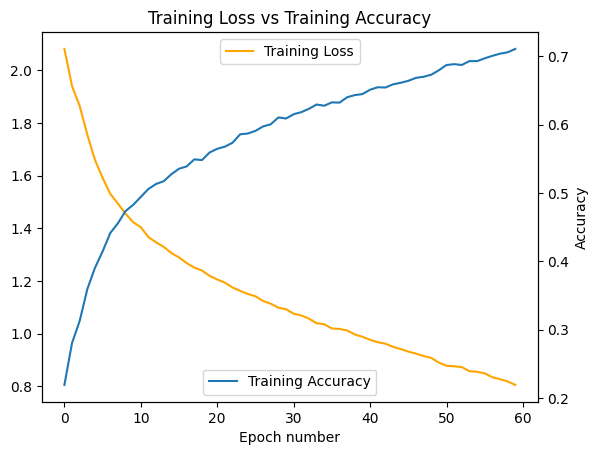

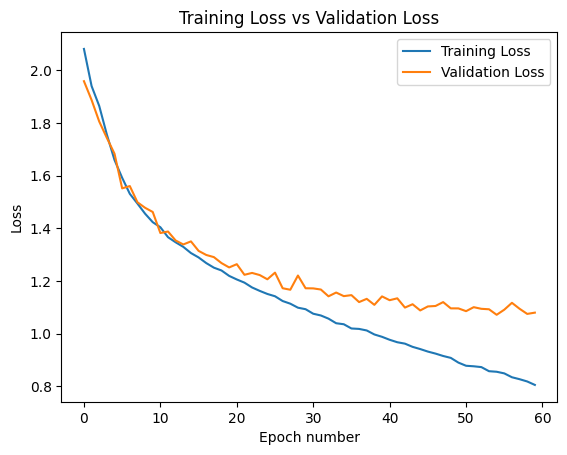

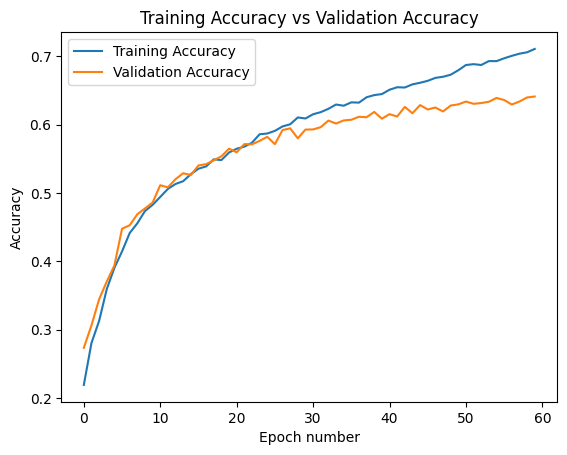

train_length = 50000 validation_length = 0


Validation Epoch 000: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.10it/s]


epoch = 0, Train Loss: 2.0157, Validation Loss: 1.6690, Train Accuracy: 24.67%, Validation Accuracy: 31.64%


Validation Epoch 001: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 13.70it/s]


epoch = 1, Train Loss: 1.8216, Validation Loss: 1.5092, Train Accuracy: 33.19%, Validation Accuracy: 38.18%


Validation Epoch 002: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.32it/s]


epoch = 2, Train Loss: 1.6476, Validation Loss: 1.3398, Train Accuracy: 39.60%, Validation Accuracy: 45.12%


Validation Epoch 003: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.54it/s]


epoch = 3, Train Loss: 1.5230, Validation Loss: 1.2574, Train Accuracy: 44.77%, Validation Accuracy: 49.61%


Validation Epoch 004: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.36it/s]


epoch = 4, Train Loss: 1.4496, Validation Loss: 1.1722, Train Accuracy: 47.47%, Validation Accuracy: 52.25%


Validation Epoch 005: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.04it/s]


epoch = 5, Train Loss: 1.3957, Validation Loss: 1.1736, Train Accuracy: 49.74%, Validation Accuracy: 51.37%


Validation Epoch 006: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 13.96it/s]


epoch = 6, Train Loss: 1.3564, Validation Loss: 1.0854, Train Accuracy: 51.30%, Validation Accuracy: 55.27%


Validation Epoch 007: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.40it/s]


epoch = 7, Train Loss: 1.3188, Validation Loss: 1.0505, Train Accuracy: 52.36%, Validation Accuracy: 57.13%


Validation Epoch 008: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.50it/s]


epoch = 8, Train Loss: 1.2875, Validation Loss: 1.0307, Train Accuracy: 53.44%, Validation Accuracy: 58.30%


Validation Epoch 009: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 13.37it/s]


epoch = 9, Train Loss: 1.2649, Validation Loss: 1.0095, Train Accuracy: 54.36%, Validation Accuracy: 60.35%


Validation Epoch 010: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 13.70it/s]


epoch = 10, Train Loss: 1.2356, Validation Loss: 0.9745, Train Accuracy: 55.45%, Validation Accuracy: 58.59%


Validation Epoch 011: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.01it/s]


epoch = 11, Train Loss: 1.2136, Validation Loss: 0.9717, Train Accuracy: 56.23%, Validation Accuracy: 60.25%


Validation Epoch 012: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 13.58it/s]


epoch = 12, Train Loss: 1.1915, Validation Loss: 0.9215, Train Accuracy: 57.26%, Validation Accuracy: 60.94%


Validation Epoch 013: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.32it/s]


epoch = 13, Train Loss: 1.1680, Validation Loss: 0.8979, Train Accuracy: 58.05%, Validation Accuracy: 63.57%


Validation Epoch 014: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.70it/s]


epoch = 14, Train Loss: 1.1505, Validation Loss: 0.8992, Train Accuracy: 58.68%, Validation Accuracy: 63.67%


Validation Epoch 015: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.05it/s]


epoch = 15, Train Loss: 1.1334, Validation Loss: 0.8627, Train Accuracy: 59.28%, Validation Accuracy: 63.77%


Validation Epoch 016: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.49it/s]


epoch = 16, Train Loss: 1.1163, Validation Loss: 0.8820, Train Accuracy: 59.93%, Validation Accuracy: 62.99%


Validation Epoch 017: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.45it/s]


epoch = 17, Train Loss: 1.0987, Validation Loss: 0.8318, Train Accuracy: 60.57%, Validation Accuracy: 66.50%


Validation Epoch 018: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.21it/s]


epoch = 18, Train Loss: 1.0839, Validation Loss: 0.8092, Train Accuracy: 61.13%, Validation Accuracy: 66.50%


Validation Epoch 019: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.08it/s]


epoch = 19, Train Loss: 1.0659, Validation Loss: 0.8074, Train Accuracy: 61.60%, Validation Accuracy: 66.31%


Validation Epoch 020: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 13.89it/s]


epoch = 20, Train Loss: 1.0515, Validation Loss: 0.7973, Train Accuracy: 62.32%, Validation Accuracy: 67.77%


Validation Epoch 021: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.18it/s]


epoch = 21, Train Loss: 1.0357, Validation Loss: 0.8057, Train Accuracy: 63.21%, Validation Accuracy: 67.68%


Validation Epoch 022: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 13.98it/s]


epoch = 22, Train Loss: 1.0206, Validation Loss: 0.7816, Train Accuracy: 63.64%, Validation Accuracy: 68.16%


Validation Epoch 023: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 13.90it/s]


epoch = 23, Train Loss: 1.0077, Validation Loss: 0.7544, Train Accuracy: 64.25%, Validation Accuracy: 69.43%


Validation Epoch 024: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.28it/s]


epoch = 24, Train Loss: 0.9964, Validation Loss: 0.7361, Train Accuracy: 64.41%, Validation Accuracy: 69.92%


Validation Epoch 025: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.13it/s]


epoch = 25, Train Loss: 0.9810, Validation Loss: 0.7253, Train Accuracy: 65.02%, Validation Accuracy: 69.92%


Validation Epoch 026: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.25it/s]


epoch = 26, Train Loss: 0.9667, Validation Loss: 0.6950, Train Accuracy: 65.54%, Validation Accuracy: 71.68%


Validation Epoch 027: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.22it/s]


epoch = 27, Train Loss: 0.9595, Validation Loss: 0.7050, Train Accuracy: 65.80%, Validation Accuracy: 70.61%


Validation Epoch 028: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.04it/s]


epoch = 28, Train Loss: 0.9432, Validation Loss: 0.6975, Train Accuracy: 66.46%, Validation Accuracy: 72.17%


Validation Epoch 029: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.38it/s]


epoch = 29, Train Loss: 0.9380, Validation Loss: 0.6704, Train Accuracy: 66.48%, Validation Accuracy: 72.95%


Validation Epoch 030: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.31it/s]


epoch = 30, Train Loss: 0.9233, Validation Loss: 0.6857, Train Accuracy: 66.98%, Validation Accuracy: 72.07%


Validation Epoch 031: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.12it/s]


epoch = 31, Train Loss: 0.9147, Validation Loss: 0.6651, Train Accuracy: 67.32%, Validation Accuracy: 72.17%


Validation Epoch 032: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.38it/s]


epoch = 32, Train Loss: 0.9008, Validation Loss: 0.6789, Train Accuracy: 67.98%, Validation Accuracy: 72.36%


Validation Epoch 033: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.03it/s]


epoch = 33, Train Loss: 0.8906, Validation Loss: 0.6372, Train Accuracy: 68.25%, Validation Accuracy: 73.83%


Validation Epoch 034: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.12it/s]


epoch = 34, Train Loss: 0.8799, Validation Loss: 0.6199, Train Accuracy: 68.81%, Validation Accuracy: 74.61%


Validation Epoch 035: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.54it/s]


epoch = 35, Train Loss: 0.8717, Validation Loss: 0.6286, Train Accuracy: 69.02%, Validation Accuracy: 74.22%


Validation Epoch 036: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.05it/s]


epoch = 36, Train Loss: 0.8569, Validation Loss: 0.6070, Train Accuracy: 69.59%, Validation Accuracy: 75.49%


Validation Epoch 037: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 13.99it/s]


epoch = 37, Train Loss: 0.8508, Validation Loss: 0.6168, Train Accuracy: 69.74%, Validation Accuracy: 73.73%


Validation Epoch 038: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 13.92it/s]


epoch = 38, Train Loss: 0.8435, Validation Loss: 0.6000, Train Accuracy: 70.15%, Validation Accuracy: 75.88%


Validation Epoch 039: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.48it/s]


epoch = 39, Train Loss: 0.8323, Validation Loss: 0.5780, Train Accuracy: 70.57%, Validation Accuracy: 76.76%


Validation Epoch 040: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.16it/s]


epoch = 40, Train Loss: 0.8208, Validation Loss: 0.6015, Train Accuracy: 70.86%, Validation Accuracy: 76.07%


Validation Epoch 041: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.15it/s]


epoch = 41, Train Loss: 0.8092, Validation Loss: 0.5801, Train Accuracy: 71.41%, Validation Accuracy: 77.15%


Validation Epoch 042: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.41it/s]


epoch = 42, Train Loss: 0.8027, Validation Loss: 0.5699, Train Accuracy: 71.66%, Validation Accuracy: 76.95%


Validation Epoch 043: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.06it/s]


epoch = 43, Train Loss: 0.7931, Validation Loss: 0.5525, Train Accuracy: 71.80%, Validation Accuracy: 77.15%


Validation Epoch 044: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.52it/s]


epoch = 44, Train Loss: 0.7795, Validation Loss: 0.5651, Train Accuracy: 72.25%, Validation Accuracy: 75.88%


Validation Epoch 045: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.25it/s]


epoch = 45, Train Loss: 0.7688, Validation Loss: 0.5541, Train Accuracy: 72.66%, Validation Accuracy: 77.05%


Validation Epoch 046: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.39it/s]


epoch = 46, Train Loss: 0.7614, Validation Loss: 0.5406, Train Accuracy: 72.90%, Validation Accuracy: 77.83%


Validation Epoch 047: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.31it/s]


epoch = 47, Train Loss: 0.7555, Validation Loss: 0.5474, Train Accuracy: 73.11%, Validation Accuracy: 77.05%


Validation Epoch 048: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.08it/s]


epoch = 48, Train Loss: 0.7493, Validation Loss: 0.5088, Train Accuracy: 73.20%, Validation Accuracy: 79.10%


Validation Epoch 049: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.28it/s]


epoch = 49, Train Loss: 0.7339, Validation Loss: 0.5172, Train Accuracy: 74.14%, Validation Accuracy: 78.91%


Validation Epoch 050: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 13.60it/s]


epoch = 50, Train Loss: 0.7300, Validation Loss: 0.5078, Train Accuracy: 74.12%, Validation Accuracy: 78.91%


Validation Epoch 051: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 13.54it/s]


epoch = 51, Train Loss: 0.7185, Validation Loss: 0.4860, Train Accuracy: 74.54%, Validation Accuracy: 80.57%


Validation Epoch 052: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.41it/s]


epoch = 52, Train Loss: 0.7105, Validation Loss: 0.4690, Train Accuracy: 74.56%, Validation Accuracy: 81.15%


Validation Epoch 053: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.03it/s]


epoch = 53, Train Loss: 0.7018, Validation Loss: 0.4921, Train Accuracy: 75.02%, Validation Accuracy: 80.37%


Validation Epoch 054: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 13.88it/s]


epoch = 54, Train Loss: 0.6959, Validation Loss: 0.4612, Train Accuracy: 75.10%, Validation Accuracy: 81.74%


Validation Epoch 055: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.09it/s]


epoch = 55, Train Loss: 0.6879, Validation Loss: 0.4632, Train Accuracy: 75.52%, Validation Accuracy: 81.74%


Validation Epoch 056: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.09it/s]


epoch = 56, Train Loss: 0.6818, Validation Loss: 0.4592, Train Accuracy: 75.72%, Validation Accuracy: 82.71%


Validation Epoch 057: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.03it/s]


epoch = 57, Train Loss: 0.6689, Validation Loss: 0.4369, Train Accuracy: 76.07%, Validation Accuracy: 81.74%


Validation Epoch 058: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.23it/s]


epoch = 58, Train Loss: 0.6642, Validation Loss: 0.4219, Train Accuracy: 76.41%, Validation Accuracy: 83.40%


Validation Epoch 059: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 13.87it/s]


epoch = 59, Train Loss: 0.6526, Validation Loss: 0.4199, Train Accuracy: 76.75%, Validation Accuracy: 83.59%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.48it/s]


For model trained on  100.00% data with 4 heads and 4 x 4 non-overlapping patches,
	Train Accuracy is  84.21%
	Test Accuracy is  68.56%


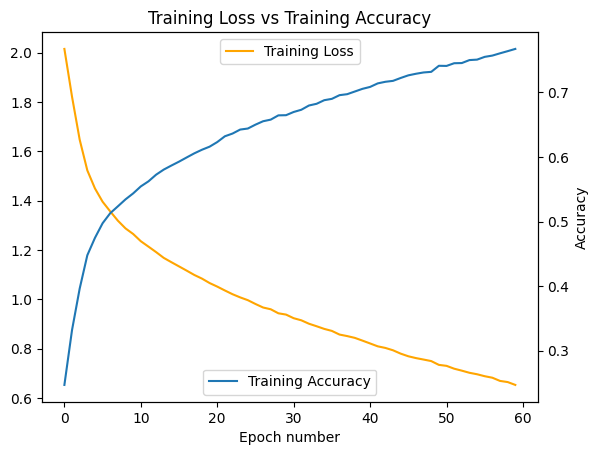

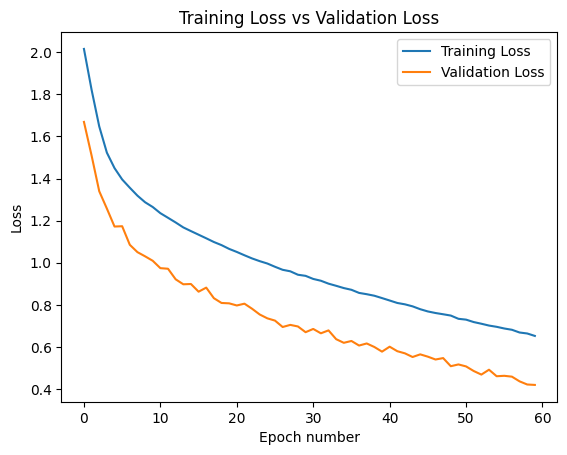

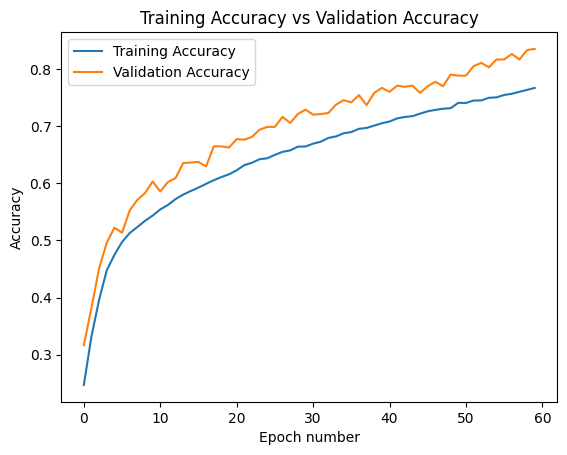

In [16]:
config_data = default_config_data.copy()
result_b_data = {}
for train_size in [0.05, 0.1, 0.25, 0.5, 1]:
    config_data['train_size'] = train_size
    _, train_loss_data, valid_loss_data, train_acc_data, valid_acc_data = train_test_model(train_dataset, test_dataset, config_data)
    result_b_data[f'train_loss_{train_size}'] = train_loss_data
    result_b_data[f'valid_loss_{train_size}'] = valid_loss_data
    result_b_data[f'train_acc_{train_size}'] = train_acc_data
    result_b_data[f'valid_acc_{train_size}'] = valid_acc_data
    

train_length = 40000 validation_length = 10000


Validation Epoch 000: 100%|████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.59it/s]


epoch = 0, Train Loss: 2.1450, Validation Loss: 1.9685, Train Accuracy: 19.74%, Validation Accuracy: 26.68%


Validation Epoch 001: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.39it/s]


epoch = 1, Train Loss: 1.9463, Validation Loss: 1.8756, Train Accuracy: 27.13%, Validation Accuracy: 30.54%


Validation Epoch 002: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.41it/s]


epoch = 2, Train Loss: 1.8258, Validation Loss: 1.7743, Train Accuracy: 31.87%, Validation Accuracy: 35.75%


Validation Epoch 003: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.37it/s]


epoch = 3, Train Loss: 1.7181, Validation Loss: 1.7143, Train Accuracy: 36.38%, Validation Accuracy: 39.20%


Validation Epoch 004: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.42it/s]


epoch = 4, Train Loss: 1.6518, Validation Loss: 1.6926, Train Accuracy: 39.05%, Validation Accuracy: 40.91%


Validation Epoch 005: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.32it/s]


epoch = 5, Train Loss: 1.6026, Validation Loss: 1.6190, Train Accuracy: 40.93%, Validation Accuracy: 43.32%


Validation Epoch 006: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.35it/s]


epoch = 6, Train Loss: 1.5576, Validation Loss: 1.5902, Train Accuracy: 43.04%, Validation Accuracy: 44.92%


Validation Epoch 007: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.36it/s]


epoch = 7, Train Loss: 1.5229, Validation Loss: 1.5363, Train Accuracy: 44.48%, Validation Accuracy: 46.49%


Validation Epoch 008: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.37it/s]


epoch = 8, Train Loss: 1.4939, Validation Loss: 1.5310, Train Accuracy: 45.70%, Validation Accuracy: 47.19%


Validation Epoch 009: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.34it/s]


epoch = 9, Train Loss: 1.4656, Validation Loss: 1.4743, Train Accuracy: 46.79%, Validation Accuracy: 48.22%


Validation Epoch 010: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.34it/s]


epoch = 10, Train Loss: 1.4392, Validation Loss: 1.4730, Train Accuracy: 47.75%, Validation Accuracy: 48.68%


Validation Epoch 011: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.38it/s]


epoch = 11, Train Loss: 1.4164, Validation Loss: 1.4191, Train Accuracy: 48.82%, Validation Accuracy: 49.74%


Validation Epoch 012: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.35it/s]


epoch = 12, Train Loss: 1.3949, Validation Loss: 1.4279, Train Accuracy: 49.37%, Validation Accuracy: 49.86%


Validation Epoch 013: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.36it/s]


epoch = 13, Train Loss: 1.3746, Validation Loss: 1.3984, Train Accuracy: 50.36%, Validation Accuracy: 51.02%


Validation Epoch 014: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.37it/s]


epoch = 14, Train Loss: 1.3545, Validation Loss: 1.3742, Train Accuracy: 51.27%, Validation Accuracy: 52.25%


Validation Epoch 015: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.35it/s]


epoch = 15, Train Loss: 1.3376, Validation Loss: 1.3516, Train Accuracy: 51.64%, Validation Accuracy: 52.33%


Validation Epoch 016: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.33it/s]


epoch = 16, Train Loss: 1.3227, Validation Loss: 1.3419, Train Accuracy: 52.22%, Validation Accuracy: 53.28%


Validation Epoch 017: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.34it/s]


epoch = 17, Train Loss: 1.3065, Validation Loss: 1.3313, Train Accuracy: 53.17%, Validation Accuracy: 53.54%


Validation Epoch 018: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.37it/s]


epoch = 18, Train Loss: 1.2962, Validation Loss: 1.3327, Train Accuracy: 52.98%, Validation Accuracy: 53.57%


Validation Epoch 019: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.36it/s]


epoch = 19, Train Loss: 1.2820, Validation Loss: 1.3035, Train Accuracy: 53.86%, Validation Accuracy: 54.72%


Validation Epoch 020: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.39it/s]


epoch = 20, Train Loss: 1.2736, Validation Loss: 1.3177, Train Accuracy: 53.97%, Validation Accuracy: 54.48%


Validation Epoch 021: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.34it/s]


epoch = 21, Train Loss: 1.2599, Validation Loss: 1.3017, Train Accuracy: 54.55%, Validation Accuracy: 54.88%


Validation Epoch 022: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.38it/s]


epoch = 22, Train Loss: 1.2474, Validation Loss: 1.2993, Train Accuracy: 55.10%, Validation Accuracy: 55.64%


Validation Epoch 023: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.38it/s]


epoch = 23, Train Loss: 1.2389, Validation Loss: 1.2817, Train Accuracy: 55.35%, Validation Accuracy: 55.54%


Validation Epoch 024: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.40it/s]


epoch = 24, Train Loss: 1.2240, Validation Loss: 1.2628, Train Accuracy: 55.89%, Validation Accuracy: 55.94%


Validation Epoch 025: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.38it/s]


epoch = 25, Train Loss: 1.2141, Validation Loss: 1.2589, Train Accuracy: 56.18%, Validation Accuracy: 56.44%


Validation Epoch 026: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.36it/s]


epoch = 26, Train Loss: 1.2064, Validation Loss: 1.2551, Train Accuracy: 56.67%, Validation Accuracy: 56.40%


Validation Epoch 027: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.39it/s]


epoch = 27, Train Loss: 1.1967, Validation Loss: 1.2437, Train Accuracy: 56.82%, Validation Accuracy: 56.99%


Validation Epoch 028: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.40it/s]


epoch = 28, Train Loss: 1.1846, Validation Loss: 1.2392, Train Accuracy: 57.53%, Validation Accuracy: 57.29%


Validation Epoch 029: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.40it/s]


epoch = 29, Train Loss: 1.1747, Validation Loss: 1.2373, Train Accuracy: 57.93%, Validation Accuracy: 57.54%


Validation Epoch 030: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.35it/s]


epoch = 30, Train Loss: 1.1686, Validation Loss: 1.2249, Train Accuracy: 58.33%, Validation Accuracy: 57.55%


Validation Epoch 031: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.31it/s]


epoch = 31, Train Loss: 1.1611, Validation Loss: 1.2268, Train Accuracy: 58.45%, Validation Accuracy: 57.96%


Validation Epoch 032: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.35it/s]


epoch = 32, Train Loss: 1.1508, Validation Loss: 1.2017, Train Accuracy: 58.58%, Validation Accuracy: 58.51%


Validation Epoch 033: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.31it/s]


epoch = 33, Train Loss: 1.1451, Validation Loss: 1.2183, Train Accuracy: 59.10%, Validation Accuracy: 58.09%


Validation Epoch 034: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.31it/s]


epoch = 34, Train Loss: 1.1429, Validation Loss: 1.1989, Train Accuracy: 59.09%, Validation Accuracy: 58.91%


Validation Epoch 035: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.36it/s]


epoch = 35, Train Loss: 1.1283, Validation Loss: 1.1984, Train Accuracy: 59.51%, Validation Accuracy: 58.49%


Validation Epoch 036: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.33it/s]


epoch = 36, Train Loss: 1.1276, Validation Loss: 1.1885, Train Accuracy: 59.51%, Validation Accuracy: 59.14%


Validation Epoch 037: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.40it/s]


epoch = 37, Train Loss: 1.1118, Validation Loss: 1.1954, Train Accuracy: 60.08%, Validation Accuracy: 59.20%


Validation Epoch 038: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.31it/s]


epoch = 38, Train Loss: 1.1047, Validation Loss: 1.2068, Train Accuracy: 60.38%, Validation Accuracy: 58.93%


Validation Epoch 039: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.39it/s]


epoch = 39, Train Loss: 1.1026, Validation Loss: 1.1775, Train Accuracy: 60.42%, Validation Accuracy: 59.61%


Validation Epoch 040: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.31it/s]


epoch = 40, Train Loss: 1.1007, Validation Loss: 1.1689, Train Accuracy: 60.34%, Validation Accuracy: 59.67%


Validation Epoch 041: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.43it/s]


epoch = 41, Train Loss: 1.0889, Validation Loss: 1.1771, Train Accuracy: 61.11%, Validation Accuracy: 59.59%


Validation Epoch 042: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.35it/s]


epoch = 42, Train Loss: 1.0820, Validation Loss: 1.1731, Train Accuracy: 61.17%, Validation Accuracy: 59.59%


Validation Epoch 043: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.37it/s]


epoch = 43, Train Loss: 1.0732, Validation Loss: 1.1619, Train Accuracy: 61.53%, Validation Accuracy: 60.22%


Validation Epoch 044: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.43it/s]


epoch = 44, Train Loss: 1.0690, Validation Loss: 1.1609, Train Accuracy: 61.67%, Validation Accuracy: 60.36%


Validation Epoch 045: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.37it/s]


epoch = 45, Train Loss: 1.0654, Validation Loss: 1.1567, Train Accuracy: 61.80%, Validation Accuracy: 60.08%


Validation Epoch 046: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.42it/s]


epoch = 46, Train Loss: 1.0582, Validation Loss: 1.1864, Train Accuracy: 61.99%, Validation Accuracy: 59.95%


Validation Epoch 047: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.31it/s]


epoch = 47, Train Loss: 1.0527, Validation Loss: 1.1617, Train Accuracy: 62.21%, Validation Accuracy: 60.25%


Validation Epoch 048: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.40it/s]


epoch = 48, Train Loss: 1.0460, Validation Loss: 1.1529, Train Accuracy: 62.59%, Validation Accuracy: 60.85%


Validation Epoch 049: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.36it/s]


epoch = 49, Train Loss: 1.0380, Validation Loss: 1.1533, Train Accuracy: 62.62%, Validation Accuracy: 60.77%


Validation Epoch 050: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.41it/s]


epoch = 50, Train Loss: 1.0379, Validation Loss: 1.1527, Train Accuracy: 62.84%, Validation Accuracy: 60.87%


Validation Epoch 051: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.35it/s]


epoch = 51, Train Loss: 1.0288, Validation Loss: 1.1365, Train Accuracy: 63.09%, Validation Accuracy: 61.06%


Validation Epoch 052: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.35it/s]


epoch = 52, Train Loss: 1.0244, Validation Loss: 1.1525, Train Accuracy: 63.12%, Validation Accuracy: 60.63%


Validation Epoch 053: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.41it/s]


epoch = 53, Train Loss: 1.0187, Validation Loss: 1.1337, Train Accuracy: 63.39%, Validation Accuracy: 61.38%


Validation Epoch 054: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.41it/s]


epoch = 54, Train Loss: 1.0136, Validation Loss: 1.1302, Train Accuracy: 63.83%, Validation Accuracy: 61.50%


Validation Epoch 055: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.40it/s]


epoch = 55, Train Loss: 1.0083, Validation Loss: 1.1149, Train Accuracy: 63.93%, Validation Accuracy: 61.57%


Validation Epoch 056: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.44it/s]


epoch = 56, Train Loss: 1.0046, Validation Loss: 1.1270, Train Accuracy: 63.93%, Validation Accuracy: 61.84%


Validation Epoch 057: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.36it/s]


epoch = 57, Train Loss: 1.0045, Validation Loss: 1.1392, Train Accuracy: 63.99%, Validation Accuracy: 61.85%


Validation Epoch 058: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.36it/s]


epoch = 58, Train Loss: 0.9977, Validation Loss: 1.1270, Train Accuracy: 64.22%, Validation Accuracy: 62.20%


Validation Epoch 059: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.37it/s]


epoch = 59, Train Loss: 0.9917, Validation Loss: 1.1391, Train Accuracy: 64.42%, Validation Accuracy: 61.72%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.34it/s]


For model trained on  80.00% data with 4 heads and 4 x 4 overlapping patches,
	Train Accuracy is  66.84%
	Test Accuracy is  62.71%


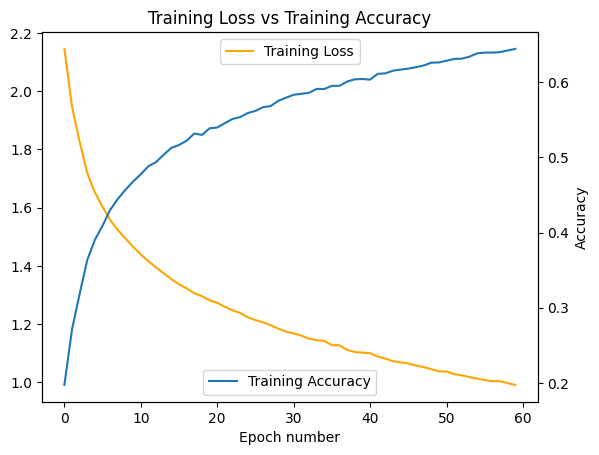

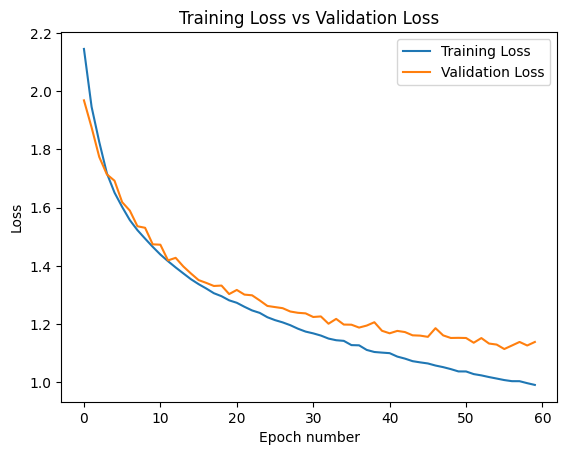

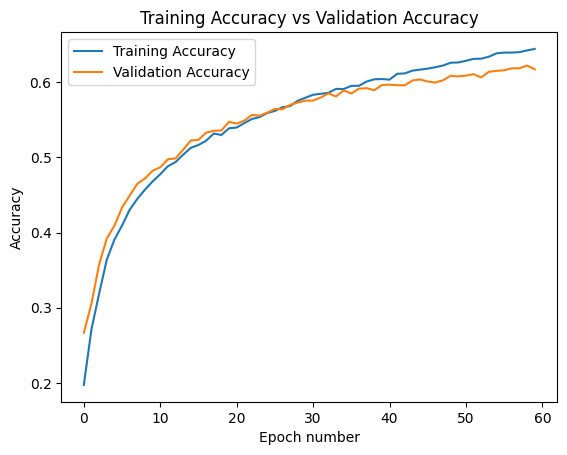

train_length = 40000 validation_length = 10000


Validation Epoch 000: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.62it/s]


epoch = 0, Train Loss: 2.1265, Validation Loss: 1.9576, Train Accuracy: 20.01%, Validation Accuracy: 27.27%


Validation Epoch 001: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.70it/s]


epoch = 1, Train Loss: 1.9420, Validation Loss: 1.8385, Train Accuracy: 27.96%, Validation Accuracy: 32.09%


Validation Epoch 002: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.74it/s]


epoch = 2, Train Loss: 1.8250, Validation Loss: 1.7499, Train Accuracy: 32.81%, Validation Accuracy: 36.17%


Validation Epoch 003: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 48.40it/s]


epoch = 3, Train Loss: 1.7303, Validation Loss: 1.6854, Train Accuracy: 36.58%, Validation Accuracy: 39.08%


Validation Epoch 004: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.40it/s]


epoch = 4, Train Loss: 1.6720, Validation Loss: 1.6266, Train Accuracy: 39.10%, Validation Accuracy: 41.56%


Validation Epoch 005: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 48.72it/s]


epoch = 5, Train Loss: 1.6230, Validation Loss: 1.6268, Train Accuracy: 41.06%, Validation Accuracy: 42.11%


Validation Epoch 006: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.67it/s]


epoch = 6, Train Loss: 1.5801, Validation Loss: 1.5785, Train Accuracy: 43.07%, Validation Accuracy: 44.21%


Validation Epoch 007: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.87it/s]


epoch = 7, Train Loss: 1.5470, Validation Loss: 1.5364, Train Accuracy: 44.11%, Validation Accuracy: 45.36%


Validation Epoch 008: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.25it/s]


epoch = 8, Train Loss: 1.5197, Validation Loss: 1.5085, Train Accuracy: 45.12%, Validation Accuracy: 46.72%


Validation Epoch 009: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.00it/s]


epoch = 9, Train Loss: 1.4968, Validation Loss: 1.5226, Train Accuracy: 45.71%, Validation Accuracy: 46.48%


Validation Epoch 010: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.49it/s]


epoch = 10, Train Loss: 1.4758, Validation Loss: 1.4717, Train Accuracy: 46.76%, Validation Accuracy: 48.07%


Validation Epoch 011: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.40it/s]


epoch = 11, Train Loss: 1.4543, Validation Loss: 1.4633, Train Accuracy: 47.85%, Validation Accuracy: 48.44%


Validation Epoch 012: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 48.75it/s]


epoch = 12, Train Loss: 1.4361, Validation Loss: 1.4480, Train Accuracy: 48.39%, Validation Accuracy: 49.45%


Validation Epoch 013: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.29it/s]


epoch = 13, Train Loss: 1.4238, Validation Loss: 1.4458, Train Accuracy: 49.06%, Validation Accuracy: 49.76%


Validation Epoch 014: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.07it/s]


epoch = 14, Train Loss: 1.4071, Validation Loss: 1.4113, Train Accuracy: 49.38%, Validation Accuracy: 50.42%


Validation Epoch 015: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.26it/s]


epoch = 15, Train Loss: 1.3872, Validation Loss: 1.3813, Train Accuracy: 49.96%, Validation Accuracy: 51.24%


Validation Epoch 016: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.20it/s]


epoch = 16, Train Loss: 1.3783, Validation Loss: 1.3968, Train Accuracy: 50.44%, Validation Accuracy: 50.99%


Validation Epoch 017: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.74it/s]


epoch = 17, Train Loss: 1.3663, Validation Loss: 1.3661, Train Accuracy: 50.60%, Validation Accuracy: 52.24%


Validation Epoch 018: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.53it/s]


epoch = 18, Train Loss: 1.3533, Validation Loss: 1.3565, Train Accuracy: 51.52%, Validation Accuracy: 52.15%


Validation Epoch 019: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 48.91it/s]


epoch = 19, Train Loss: 1.3398, Validation Loss: 1.3388, Train Accuracy: 51.77%, Validation Accuracy: 53.28%


Validation Epoch 020: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 48.92it/s]


epoch = 20, Train Loss: 1.3266, Validation Loss: 1.3492, Train Accuracy: 52.13%, Validation Accuracy: 53.19%


Validation Epoch 021: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.27it/s]


epoch = 21, Train Loss: 1.3205, Validation Loss: 1.3405, Train Accuracy: 52.55%, Validation Accuracy: 53.23%


Validation Epoch 022: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.57it/s]


epoch = 22, Train Loss: 1.3051, Validation Loss: 1.3133, Train Accuracy: 52.93%, Validation Accuracy: 53.85%


Validation Epoch 023: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.14it/s]


epoch = 23, Train Loss: 1.2979, Validation Loss: 1.3254, Train Accuracy: 53.79%, Validation Accuracy: 53.54%


Validation Epoch 024: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 48.93it/s]


epoch = 24, Train Loss: 1.2866, Validation Loss: 1.2987, Train Accuracy: 53.81%, Validation Accuracy: 54.78%


Validation Epoch 025: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.25it/s]


epoch = 25, Train Loss: 1.2825, Validation Loss: 1.2995, Train Accuracy: 54.20%, Validation Accuracy: 55.33%


Validation Epoch 026: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.15it/s]


epoch = 26, Train Loss: 1.2692, Validation Loss: 1.2872, Train Accuracy: 54.49%, Validation Accuracy: 55.19%


Validation Epoch 027: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.34it/s]


epoch = 27, Train Loss: 1.2563, Validation Loss: 1.2873, Train Accuracy: 54.91%, Validation Accuracy: 55.43%


Validation Epoch 028: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.83it/s]


epoch = 28, Train Loss: 1.2537, Validation Loss: 1.2515, Train Accuracy: 55.19%, Validation Accuracy: 56.16%


Validation Epoch 029: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 48.59it/s]


epoch = 29, Train Loss: 1.2416, Validation Loss: 1.2509, Train Accuracy: 55.47%, Validation Accuracy: 56.10%


Validation Epoch 030: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.40it/s]


epoch = 30, Train Loss: 1.2349, Validation Loss: 1.2405, Train Accuracy: 55.85%, Validation Accuracy: 56.34%


Validation Epoch 031: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 48.92it/s]


epoch = 31, Train Loss: 1.2266, Validation Loss: 1.2552, Train Accuracy: 56.02%, Validation Accuracy: 56.49%


Validation Epoch 032: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.59it/s]


epoch = 32, Train Loss: 1.2218, Validation Loss: 1.2347, Train Accuracy: 56.27%, Validation Accuracy: 56.54%


Validation Epoch 033: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 48.97it/s]


epoch = 33, Train Loss: 1.2089, Validation Loss: 1.2281, Train Accuracy: 56.55%, Validation Accuracy: 56.85%


Validation Epoch 034: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.86it/s]


epoch = 34, Train Loss: 1.2019, Validation Loss: 1.2249, Train Accuracy: 56.76%, Validation Accuracy: 57.02%


Validation Epoch 035: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 48.97it/s]


epoch = 35, Train Loss: 1.1950, Validation Loss: 1.2133, Train Accuracy: 56.87%, Validation Accuracy: 57.46%


Validation Epoch 036: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.22it/s]


epoch = 36, Train Loss: 1.1893, Validation Loss: 1.2112, Train Accuracy: 57.28%, Validation Accuracy: 57.64%


Validation Epoch 037: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 48.69it/s]


epoch = 37, Train Loss: 1.1799, Validation Loss: 1.2152, Train Accuracy: 57.49%, Validation Accuracy: 57.34%


Validation Epoch 038: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.56it/s]


epoch = 38, Train Loss: 1.1733, Validation Loss: 1.2022, Train Accuracy: 57.75%, Validation Accuracy: 58.07%


Validation Epoch 039: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.35it/s]


epoch = 39, Train Loss: 1.1708, Validation Loss: 1.1981, Train Accuracy: 58.03%, Validation Accuracy: 58.28%


Validation Epoch 040: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.90it/s]


epoch = 40, Train Loss: 1.1598, Validation Loss: 1.1905, Train Accuracy: 58.54%, Validation Accuracy: 58.21%


Validation Epoch 041: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.54it/s]


epoch = 41, Train Loss: 1.1542, Validation Loss: 1.1840, Train Accuracy: 58.39%, Validation Accuracy: 58.36%


Validation Epoch 042: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 48.42it/s]


epoch = 42, Train Loss: 1.1475, Validation Loss: 1.1791, Train Accuracy: 59.06%, Validation Accuracy: 59.30%


Validation Epoch 043: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.50it/s]


epoch = 43, Train Loss: 1.1430, Validation Loss: 1.1730, Train Accuracy: 58.96%, Validation Accuracy: 58.85%


Validation Epoch 044: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 48.95it/s]


epoch = 44, Train Loss: 1.1389, Validation Loss: 1.1738, Train Accuracy: 59.25%, Validation Accuracy: 58.70%


Validation Epoch 045: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.08it/s]


epoch = 45, Train Loss: 1.1300, Validation Loss: 1.1697, Train Accuracy: 59.44%, Validation Accuracy: 59.23%


Validation Epoch 046: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.59it/s]


epoch = 46, Train Loss: 1.1228, Validation Loss: 1.1635, Train Accuracy: 59.95%, Validation Accuracy: 59.32%


Validation Epoch 047: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.26it/s]


epoch = 47, Train Loss: 1.1213, Validation Loss: 1.1652, Train Accuracy: 59.74%, Validation Accuracy: 59.28%


Validation Epoch 048: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 48.87it/s]


epoch = 48, Train Loss: 1.1171, Validation Loss: 1.1640, Train Accuracy: 60.14%, Validation Accuracy: 59.61%


Validation Epoch 049: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.10it/s]


epoch = 49, Train Loss: 1.1075, Validation Loss: 1.1735, Train Accuracy: 60.38%, Validation Accuracy: 59.36%


Validation Epoch 050: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.27it/s]


epoch = 50, Train Loss: 1.1097, Validation Loss: 1.1567, Train Accuracy: 60.21%, Validation Accuracy: 59.76%


Validation Epoch 051: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.24it/s]


epoch = 51, Train Loss: 1.1012, Validation Loss: 1.1479, Train Accuracy: 60.35%, Validation Accuracy: 60.25%


Validation Epoch 052: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.47it/s]


epoch = 52, Train Loss: 1.0965, Validation Loss: 1.1442, Train Accuracy: 60.91%, Validation Accuracy: 59.85%


Validation Epoch 053: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.18it/s]


epoch = 53, Train Loss: 1.0839, Validation Loss: 1.1350, Train Accuracy: 61.10%, Validation Accuracy: 60.49%


Validation Epoch 054: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.50it/s]


epoch = 54, Train Loss: 1.0861, Validation Loss: 1.1299, Train Accuracy: 61.29%, Validation Accuracy: 60.17%


Validation Epoch 055: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.23it/s]


epoch = 55, Train Loss: 1.0798, Validation Loss: 1.1391, Train Accuracy: 61.20%, Validation Accuracy: 60.26%


Validation Epoch 056: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.40it/s]


epoch = 56, Train Loss: 1.0730, Validation Loss: 1.1311, Train Accuracy: 61.31%, Validation Accuracy: 60.61%


Validation Epoch 057: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.83it/s]


epoch = 57, Train Loss: 1.0693, Validation Loss: 1.1286, Train Accuracy: 61.84%, Validation Accuracy: 60.78%


Validation Epoch 058: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 48.95it/s]


epoch = 58, Train Loss: 1.0668, Validation Loss: 1.1328, Train Accuracy: 62.05%, Validation Accuracy: 60.54%


Validation Epoch 059: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 48.89it/s]


epoch = 59, Train Loss: 1.0586, Validation Loss: 1.1224, Train Accuracy: 62.08%, Validation Accuracy: 60.48%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.01it/s]


For model trained on  80.00% data with 4 heads and 4 x 4 non-overlapping patches,
	Train Accuracy is  65.36%
	Test Accuracy is  59.96%


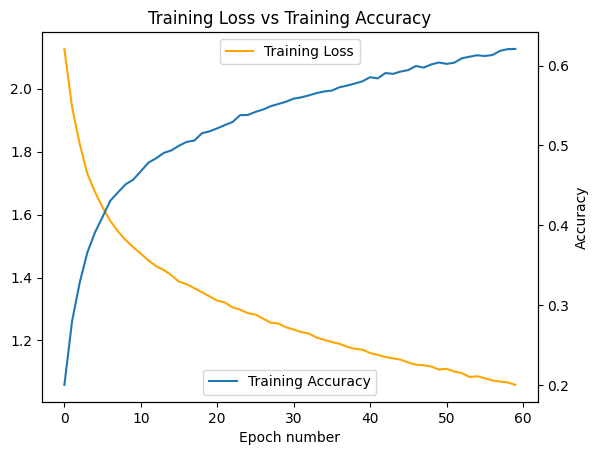

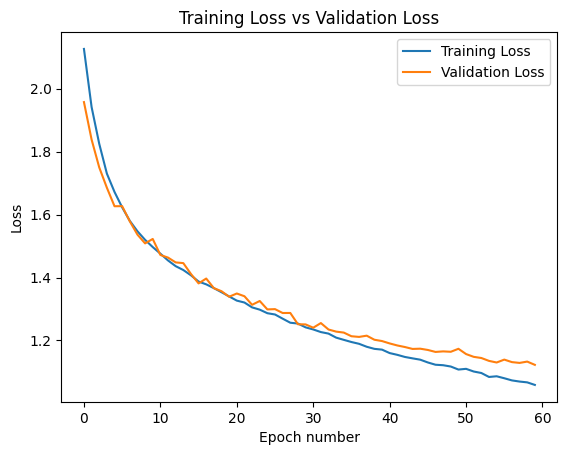

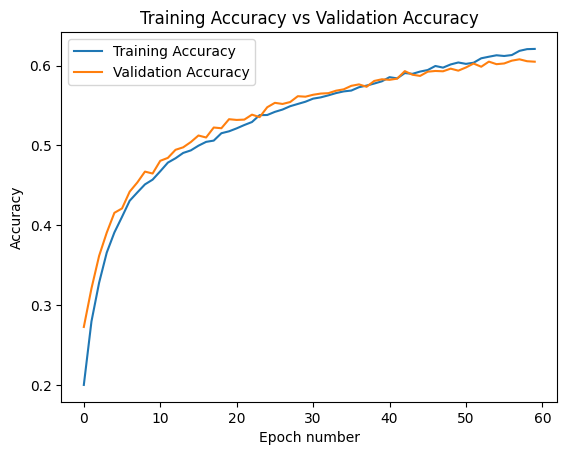

train_length = 40000 validation_length = 10000


Validation Epoch 000: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 59.48it/s]


epoch = 0, Train Loss: 2.1230, Validation Loss: 1.9325, Train Accuracy: 20.68%, Validation Accuracy: 27.45%


Validation Epoch 001: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 61.70it/s]


epoch = 1, Train Loss: 1.9054, Validation Loss: 1.7960, Train Accuracy: 29.43%, Validation Accuracy: 33.81%


Validation Epoch 002: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 60.51it/s]


epoch = 2, Train Loss: 1.7733, Validation Loss: 1.6945, Train Accuracy: 34.53%, Validation Accuracy: 37.82%


Validation Epoch 003: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 61.63it/s]


epoch = 3, Train Loss: 1.6808, Validation Loss: 1.6281, Train Accuracy: 38.37%, Validation Accuracy: 41.41%


Validation Epoch 004: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 61.12it/s]


epoch = 4, Train Loss: 1.6213, Validation Loss: 1.5654, Train Accuracy: 40.76%, Validation Accuracy: 43.95%


Validation Epoch 005: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 60.84it/s]


epoch = 5, Train Loss: 1.5705, Validation Loss: 1.5272, Train Accuracy: 42.45%, Validation Accuracy: 46.11%


Validation Epoch 006: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 60.81it/s]


epoch = 6, Train Loss: 1.5273, Validation Loss: 1.5115, Train Accuracy: 44.40%, Validation Accuracy: 46.80%


Validation Epoch 007: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 61.40it/s]


epoch = 7, Train Loss: 1.4966, Validation Loss: 1.4859, Train Accuracy: 45.62%, Validation Accuracy: 48.03%


Validation Epoch 008: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 59.83it/s]


epoch = 8, Train Loss: 1.4666, Validation Loss: 1.4674, Train Accuracy: 46.74%, Validation Accuracy: 48.87%


Validation Epoch 009: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 61.72it/s]


epoch = 9, Train Loss: 1.4392, Validation Loss: 1.4475, Train Accuracy: 47.89%, Validation Accuracy: 49.80%


Validation Epoch 010: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 60.14it/s]


epoch = 10, Train Loss: 1.4195, Validation Loss: 1.4185, Train Accuracy: 48.39%, Validation Accuracy: 50.14%


Validation Epoch 011: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 61.78it/s]


epoch = 11, Train Loss: 1.4041, Validation Loss: 1.4049, Train Accuracy: 49.25%, Validation Accuracy: 51.01%


Validation Epoch 012: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 60.69it/s]


epoch = 12, Train Loss: 1.3851, Validation Loss: 1.4068, Train Accuracy: 50.12%, Validation Accuracy: 51.28%


Validation Epoch 013: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 59.86it/s]


epoch = 13, Train Loss: 1.3688, Validation Loss: 1.3880, Train Accuracy: 50.56%, Validation Accuracy: 51.49%


Validation Epoch 014: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 61.72it/s]


epoch = 14, Train Loss: 1.3557, Validation Loss: 1.3768, Train Accuracy: 50.95%, Validation Accuracy: 52.42%


Validation Epoch 015: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 61.40it/s]


epoch = 15, Train Loss: 1.3406, Validation Loss: 1.3694, Train Accuracy: 51.81%, Validation Accuracy: 52.02%


Validation Epoch 016: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 60.51it/s]


epoch = 16, Train Loss: 1.3299, Validation Loss: 1.3598, Train Accuracy: 52.19%, Validation Accuracy: 52.79%


Validation Epoch 017: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 60.82it/s]


epoch = 17, Train Loss: 1.3178, Validation Loss: 1.3412, Train Accuracy: 52.66%, Validation Accuracy: 53.39%


Validation Epoch 018: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 61.55it/s]


epoch = 18, Train Loss: 1.3035, Validation Loss: 1.3308, Train Accuracy: 52.86%, Validation Accuracy: 53.51%


Validation Epoch 019: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 60.58it/s]


epoch = 19, Train Loss: 1.2939, Validation Loss: 1.3408, Train Accuracy: 53.33%, Validation Accuracy: 53.30%


Validation Epoch 020: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 61.63it/s]


epoch = 20, Train Loss: 1.2864, Validation Loss: 1.3234, Train Accuracy: 53.57%, Validation Accuracy: 54.29%


Validation Epoch 021: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 61.83it/s]


epoch = 21, Train Loss: 1.2689, Validation Loss: 1.3085, Train Accuracy: 54.26%, Validation Accuracy: 54.62%


Validation Epoch 022: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 61.46it/s]


epoch = 22, Train Loss: 1.2672, Validation Loss: 1.2937, Train Accuracy: 54.15%, Validation Accuracy: 55.32%


Validation Epoch 023: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 61.33it/s]


epoch = 23, Train Loss: 1.2478, Validation Loss: 1.3086, Train Accuracy: 55.01%, Validation Accuracy: 54.58%


Validation Epoch 024: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 61.08it/s]


epoch = 24, Train Loss: 1.2425, Validation Loss: 1.2743, Train Accuracy: 55.18%, Validation Accuracy: 55.88%


Validation Epoch 025: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 61.52it/s]


epoch = 25, Train Loss: 1.2313, Validation Loss: 1.2920, Train Accuracy: 55.99%, Validation Accuracy: 55.86%


Validation Epoch 026: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 60.96it/s]


epoch = 26, Train Loss: 1.2232, Validation Loss: 1.2605, Train Accuracy: 55.93%, Validation Accuracy: 56.63%


Validation Epoch 027: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 60.52it/s]


epoch = 27, Train Loss: 1.2166, Validation Loss: 1.2611, Train Accuracy: 56.52%, Validation Accuracy: 56.33%


Validation Epoch 028: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 60.16it/s]


epoch = 28, Train Loss: 1.2057, Validation Loss: 1.2573, Train Accuracy: 56.83%, Validation Accuracy: 56.60%


Validation Epoch 029: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 60.87it/s]


epoch = 29, Train Loss: 1.1991, Validation Loss: 1.2598, Train Accuracy: 56.80%, Validation Accuracy: 56.70%


Validation Epoch 030: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 60.72it/s]


epoch = 30, Train Loss: 1.1919, Validation Loss: 1.2439, Train Accuracy: 57.21%, Validation Accuracy: 57.36%


Validation Epoch 031: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 61.12it/s]


epoch = 31, Train Loss: 1.1831, Validation Loss: 1.2400, Train Accuracy: 57.62%, Validation Accuracy: 57.63%


Validation Epoch 032: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 61.16it/s]


epoch = 32, Train Loss: 1.1771, Validation Loss: 1.2353, Train Accuracy: 57.65%, Validation Accuracy: 57.85%


Validation Epoch 033: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 60.95it/s]


epoch = 33, Train Loss: 1.1664, Validation Loss: 1.2227, Train Accuracy: 58.25%, Validation Accuracy: 57.98%


Validation Epoch 034: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 60.85it/s]


epoch = 34, Train Loss: 1.1631, Validation Loss: 1.2164, Train Accuracy: 58.21%, Validation Accuracy: 58.30%


Validation Epoch 035: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 60.62it/s]


epoch = 35, Train Loss: 1.1549, Validation Loss: 1.2128, Train Accuracy: 58.60%, Validation Accuracy: 58.54%


Validation Epoch 036: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 61.46it/s]


epoch = 36, Train Loss: 1.1482, Validation Loss: 1.2079, Train Accuracy: 58.85%, Validation Accuracy: 58.59%


Validation Epoch 037: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 60.41it/s]


epoch = 37, Train Loss: 1.1411, Validation Loss: 1.2023, Train Accuracy: 58.88%, Validation Accuracy: 58.97%


Validation Epoch 038: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 60.72it/s]


epoch = 38, Train Loss: 1.1291, Validation Loss: 1.2102, Train Accuracy: 59.38%, Validation Accuracy: 59.09%


Validation Epoch 039: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 60.32it/s]


epoch = 39, Train Loss: 1.1248, Validation Loss: 1.2038, Train Accuracy: 59.87%, Validation Accuracy: 59.01%


Validation Epoch 040: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 61.15it/s]


epoch = 40, Train Loss: 1.1193, Validation Loss: 1.2018, Train Accuracy: 59.71%, Validation Accuracy: 59.11%


Validation Epoch 041: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 61.78it/s]


epoch = 41, Train Loss: 1.1120, Validation Loss: 1.1871, Train Accuracy: 60.16%, Validation Accuracy: 59.32%


Validation Epoch 042: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 61.86it/s]


epoch = 42, Train Loss: 1.1023, Validation Loss: 1.1814, Train Accuracy: 60.49%, Validation Accuracy: 59.82%


Validation Epoch 043: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 60.65it/s]


epoch = 43, Train Loss: 1.1049, Validation Loss: 1.1667, Train Accuracy: 60.50%, Validation Accuracy: 60.16%


Validation Epoch 044: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 61.61it/s]


epoch = 44, Train Loss: 1.0904, Validation Loss: 1.1798, Train Accuracy: 60.99%, Validation Accuracy: 59.77%


Validation Epoch 045: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 60.68it/s]


epoch = 45, Train Loss: 1.0897, Validation Loss: 1.1949, Train Accuracy: 61.00%, Validation Accuracy: 59.47%


Validation Epoch 046: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 60.42it/s]


epoch = 46, Train Loss: 1.0821, Validation Loss: 1.1726, Train Accuracy: 61.11%, Validation Accuracy: 59.66%


Validation Epoch 047: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 60.58it/s]


epoch = 47, Train Loss: 1.0778, Validation Loss: 1.1583, Train Accuracy: 61.33%, Validation Accuracy: 60.44%


Validation Epoch 048: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 61.23it/s]


epoch = 48, Train Loss: 1.0683, Validation Loss: 1.1578, Train Accuracy: 61.62%, Validation Accuracy: 60.46%


Validation Epoch 049: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 60.84it/s]


epoch = 49, Train Loss: 1.0640, Validation Loss: 1.1557, Train Accuracy: 61.96%, Validation Accuracy: 60.31%


Validation Epoch 050: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 59.59it/s]


epoch = 50, Train Loss: 1.0591, Validation Loss: 1.1610, Train Accuracy: 62.00%, Validation Accuracy: 60.56%


Validation Epoch 051: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 61.73it/s]


epoch = 51, Train Loss: 1.0545, Validation Loss: 1.1450, Train Accuracy: 62.15%, Validation Accuracy: 60.71%


Validation Epoch 052: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 61.15it/s]


epoch = 52, Train Loss: 1.0498, Validation Loss: 1.1589, Train Accuracy: 62.47%, Validation Accuracy: 60.31%


Validation Epoch 053: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 59.77it/s]


epoch = 53, Train Loss: 1.0444, Validation Loss: 1.1498, Train Accuracy: 62.45%, Validation Accuracy: 61.07%


Validation Epoch 054: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 61.50it/s]


epoch = 54, Train Loss: 1.0394, Validation Loss: 1.1346, Train Accuracy: 62.72%, Validation Accuracy: 60.95%


Validation Epoch 055: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 60.93it/s]


epoch = 55, Train Loss: 1.0336, Validation Loss: 1.1297, Train Accuracy: 62.96%, Validation Accuracy: 61.51%


Validation Epoch 056: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 60.57it/s]


epoch = 56, Train Loss: 1.0260, Validation Loss: 1.1383, Train Accuracy: 63.04%, Validation Accuracy: 61.22%


Validation Epoch 057: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 61.78it/s]


epoch = 57, Train Loss: 1.0243, Validation Loss: 1.1390, Train Accuracy: 63.12%, Validation Accuracy: 60.87%


Validation Epoch 058: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 61.35it/s]


epoch = 58, Train Loss: 1.0219, Validation Loss: 1.1399, Train Accuracy: 63.35%, Validation Accuracy: 61.59%


Validation Epoch 059: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 61.18it/s]


epoch = 59, Train Loss: 1.0128, Validation Loss: 1.1330, Train Accuracy: 63.62%, Validation Accuracy: 61.53%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 60.88it/s]


For model trained on  80.00% data with 4 heads and 8 x 8 overlapping patches,
	Train Accuracy is  66.88%
	Test Accuracy is  60.75%


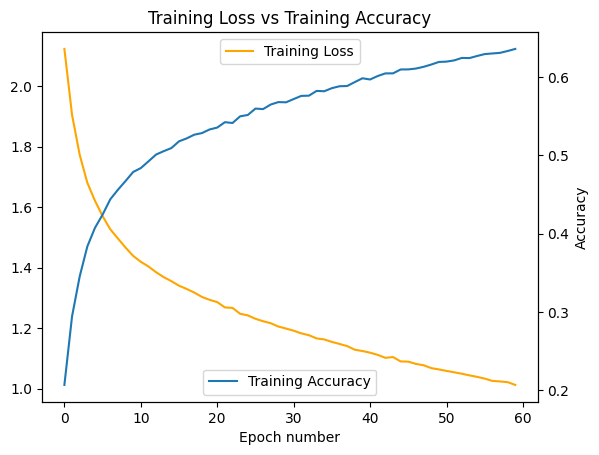

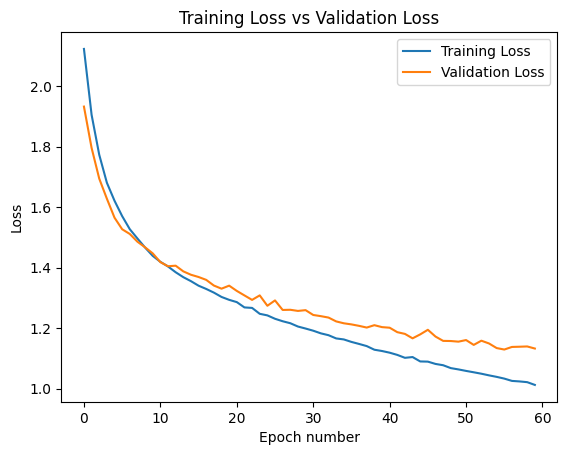

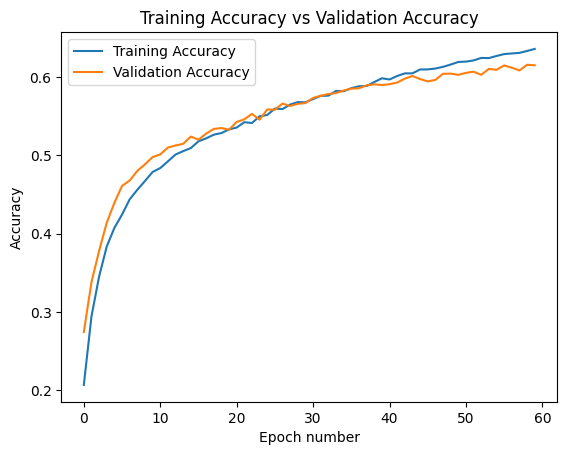

train_length = 40000 validation_length = 10000


Validation Epoch 000: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 78.13it/s]


epoch = 0, Train Loss: 2.1204, Validation Loss: 1.9211, Train Accuracy: 20.56%, Validation Accuracy: 29.29%


Validation Epoch 001: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.82it/s]


epoch = 1, Train Loss: 1.9012, Validation Loss: 1.7578, Train Accuracy: 30.36%, Validation Accuracy: 36.14%


Validation Epoch 002: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.44it/s]


epoch = 2, Train Loss: 1.7860, Validation Loss: 1.6806, Train Accuracy: 35.56%, Validation Accuracy: 39.03%


Validation Epoch 003: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 77.20it/s]


epoch = 3, Train Loss: 1.7139, Validation Loss: 1.6343, Train Accuracy: 37.92%, Validation Accuracy: 40.79%


Validation Epoch 004: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 66.34it/s]


epoch = 4, Train Loss: 1.6579, Validation Loss: 1.5824, Train Accuracy: 40.06%, Validation Accuracy: 43.52%


Validation Epoch 005: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.23it/s]


epoch = 5, Train Loss: 1.6085, Validation Loss: 1.5463, Train Accuracy: 41.84%, Validation Accuracy: 44.40%


Validation Epoch 006: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 81.31it/s]


epoch = 6, Train Loss: 1.5710, Validation Loss: 1.5179, Train Accuracy: 43.61%, Validation Accuracy: 45.85%


Validation Epoch 007: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 75.60it/s]


epoch = 7, Train Loss: 1.5397, Validation Loss: 1.5063, Train Accuracy: 44.60%, Validation Accuracy: 46.14%


Validation Epoch 008: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 81.88it/s]


epoch = 8, Train Loss: 1.5132, Validation Loss: 1.4762, Train Accuracy: 45.37%, Validation Accuracy: 47.44%


Validation Epoch 009: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 80.96it/s]


epoch = 9, Train Loss: 1.4974, Validation Loss: 1.4523, Train Accuracy: 46.14%, Validation Accuracy: 47.89%


Validation Epoch 010: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 78.05it/s]


epoch = 10, Train Loss: 1.4759, Validation Loss: 1.4622, Train Accuracy: 46.77%, Validation Accuracy: 48.16%


Validation Epoch 011: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 79.47it/s]


epoch = 11, Train Loss: 1.4613, Validation Loss: 1.4423, Train Accuracy: 47.23%, Validation Accuracy: 48.40%


Validation Epoch 012: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 75.14it/s]


epoch = 12, Train Loss: 1.4438, Validation Loss: 1.4278, Train Accuracy: 48.15%, Validation Accuracy: 48.86%


Validation Epoch 013: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.67it/s]


epoch = 13, Train Loss: 1.4320, Validation Loss: 1.4197, Train Accuracy: 48.34%, Validation Accuracy: 49.34%


Validation Epoch 014: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 81.69it/s]


epoch = 14, Train Loss: 1.4197, Validation Loss: 1.4042, Train Accuracy: 48.70%, Validation Accuracy: 50.09%


Validation Epoch 015: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 65.80it/s]


epoch = 15, Train Loss: 1.4111, Validation Loss: 1.3956, Train Accuracy: 49.20%, Validation Accuracy: 50.28%


Validation Epoch 016: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 65.02it/s]


epoch = 16, Train Loss: 1.3967, Validation Loss: 1.4027, Train Accuracy: 49.81%, Validation Accuracy: 50.28%


Validation Epoch 017: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.52it/s]


epoch = 17, Train Loss: 1.3917, Validation Loss: 1.3699, Train Accuracy: 50.10%, Validation Accuracy: 51.20%


Validation Epoch 018: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.26it/s]


epoch = 18, Train Loss: 1.3784, Validation Loss: 1.3589, Train Accuracy: 50.48%, Validation Accuracy: 51.18%


Validation Epoch 019: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 79.64it/s]


epoch = 19, Train Loss: 1.3654, Validation Loss: 1.3563, Train Accuracy: 51.03%, Validation Accuracy: 51.63%


Validation Epoch 020: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 71.21it/s]


epoch = 20, Train Loss: 1.3585, Validation Loss: 1.3596, Train Accuracy: 51.16%, Validation Accuracy: 51.95%


Validation Epoch 021: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.83it/s]


epoch = 21, Train Loss: 1.3520, Validation Loss: 1.3424, Train Accuracy: 51.45%, Validation Accuracy: 52.18%


Validation Epoch 022: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 80.23it/s]


epoch = 22, Train Loss: 1.3396, Validation Loss: 1.3409, Train Accuracy: 52.01%, Validation Accuracy: 52.45%


Validation Epoch 023: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 65.95it/s]


epoch = 23, Train Loss: 1.3333, Validation Loss: 1.3226, Train Accuracy: 51.92%, Validation Accuracy: 53.00%


Validation Epoch 024: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 76.70it/s]


epoch = 24, Train Loss: 1.3233, Validation Loss: 1.3481, Train Accuracy: 52.25%, Validation Accuracy: 52.39%


Validation Epoch 025: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 70.31it/s]


epoch = 25, Train Loss: 1.3167, Validation Loss: 1.3245, Train Accuracy: 52.70%, Validation Accuracy: 52.94%


Validation Epoch 026: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 72.50it/s]


epoch = 26, Train Loss: 1.3102, Validation Loss: 1.3235, Train Accuracy: 52.80%, Validation Accuracy: 53.19%


Validation Epoch 027: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.38it/s]


epoch = 27, Train Loss: 1.3031, Validation Loss: 1.3114, Train Accuracy: 53.18%, Validation Accuracy: 53.19%


Validation Epoch 028: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 79.66it/s]


epoch = 28, Train Loss: 1.2924, Validation Loss: 1.3131, Train Accuracy: 53.67%, Validation Accuracy: 53.27%


Validation Epoch 029: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.40it/s]


epoch = 29, Train Loss: 1.2874, Validation Loss: 1.2965, Train Accuracy: 53.44%, Validation Accuracy: 54.07%


Validation Epoch 030: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 73.90it/s]


epoch = 30, Train Loss: 1.2803, Validation Loss: 1.2978, Train Accuracy: 54.04%, Validation Accuracy: 53.86%


Validation Epoch 031: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 69.52it/s]


epoch = 31, Train Loss: 1.2746, Validation Loss: 1.2855, Train Accuracy: 54.23%, Validation Accuracy: 54.20%


Validation Epoch 032: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.36it/s]


epoch = 32, Train Loss: 1.2625, Validation Loss: 1.2897, Train Accuracy: 54.40%, Validation Accuracy: 54.50%


Validation Epoch 033: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 80.61it/s]


epoch = 33, Train Loss: 1.2552, Validation Loss: 1.2983, Train Accuracy: 54.57%, Validation Accuracy: 54.51%


Validation Epoch 034: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.46it/s]


epoch = 34, Train Loss: 1.2526, Validation Loss: 1.2811, Train Accuracy: 54.84%, Validation Accuracy: 54.89%


Validation Epoch 035: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 77.83it/s]


epoch = 35, Train Loss: 1.2431, Validation Loss: 1.2681, Train Accuracy: 55.35%, Validation Accuracy: 55.23%


Validation Epoch 036: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.10it/s]


epoch = 36, Train Loss: 1.2373, Validation Loss: 1.2892, Train Accuracy: 55.53%, Validation Accuracy: 54.64%


Validation Epoch 037: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.01it/s]


epoch = 37, Train Loss: 1.2282, Validation Loss: 1.2805, Train Accuracy: 55.99%, Validation Accuracy: 55.22%


Validation Epoch 038: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 77.67it/s]


epoch = 38, Train Loss: 1.2231, Validation Loss: 1.2767, Train Accuracy: 56.00%, Validation Accuracy: 55.30%


Validation Epoch 039: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.87it/s]


epoch = 39, Train Loss: 1.2188, Validation Loss: 1.2812, Train Accuracy: 56.08%, Validation Accuracy: 55.41%


Validation Epoch 040: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.70it/s]


epoch = 40, Train Loss: 1.2098, Validation Loss: 1.2819, Train Accuracy: 56.62%, Validation Accuracy: 55.32%


Validation Epoch 041: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 80.48it/s]


epoch = 41, Train Loss: 1.2067, Validation Loss: 1.2781, Train Accuracy: 56.55%, Validation Accuracy: 55.37%


Validation Epoch 042: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.81it/s]


epoch = 42, Train Loss: 1.2011, Validation Loss: 1.2633, Train Accuracy: 56.73%, Validation Accuracy: 55.97%


Validation Epoch 043: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.58it/s]


epoch = 43, Train Loss: 1.1956, Validation Loss: 1.2552, Train Accuracy: 56.90%, Validation Accuracy: 56.37%


Validation Epoch 044: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.54it/s]


epoch = 44, Train Loss: 1.1895, Validation Loss: 1.2569, Train Accuracy: 57.27%, Validation Accuracy: 56.11%


Validation Epoch 045: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 77.41it/s]


epoch = 45, Train Loss: 1.1866, Validation Loss: 1.2507, Train Accuracy: 57.34%, Validation Accuracy: 56.50%


Validation Epoch 046: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.62it/s]


epoch = 46, Train Loss: 1.1781, Validation Loss: 1.2394, Train Accuracy: 57.30%, Validation Accuracy: 56.66%


Validation Epoch 047: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.52it/s]


epoch = 47, Train Loss: 1.1730, Validation Loss: 1.2599, Train Accuracy: 57.70%, Validation Accuracy: 56.31%


Validation Epoch 048: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 80.68it/s]


epoch = 48, Train Loss: 1.1661, Validation Loss: 1.2521, Train Accuracy: 58.11%, Validation Accuracy: 56.34%


Validation Epoch 049: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 65.95it/s]


epoch = 49, Train Loss: 1.1644, Validation Loss: 1.2573, Train Accuracy: 58.09%, Validation Accuracy: 56.21%


Validation Epoch 050: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 73.60it/s]


epoch = 50, Train Loss: 1.1559, Validation Loss: 1.2560, Train Accuracy: 58.58%, Validation Accuracy: 56.26%


Validation Epoch 051: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 77.57it/s]


epoch = 51, Train Loss: 1.1538, Validation Loss: 1.2489, Train Accuracy: 58.51%, Validation Accuracy: 56.62%


Validation Epoch 052: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 79.06it/s]


epoch = 52, Train Loss: 1.1426, Validation Loss: 1.2548, Train Accuracy: 58.94%, Validation Accuracy: 56.20%


Validation Epoch 053: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 81.72it/s]


epoch = 53, Train Loss: 1.1391, Validation Loss: 1.2334, Train Accuracy: 59.05%, Validation Accuracy: 57.01%


Validation Epoch 054: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 81.46it/s]


epoch = 54, Train Loss: 1.1362, Validation Loss: 1.2344, Train Accuracy: 59.04%, Validation Accuracy: 56.92%


Validation Epoch 055: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.76it/s]


epoch = 55, Train Loss: 1.1326, Validation Loss: 1.2268, Train Accuracy: 59.37%, Validation Accuracy: 57.35%


Validation Epoch 056: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 76.92it/s]


epoch = 56, Train Loss: 1.1283, Validation Loss: 1.2414, Train Accuracy: 59.43%, Validation Accuracy: 56.76%


Validation Epoch 057: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 75.71it/s]


epoch = 57, Train Loss: 1.1243, Validation Loss: 1.2436, Train Accuracy: 59.70%, Validation Accuracy: 56.65%


Validation Epoch 058: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.19it/s]


epoch = 58, Train Loss: 1.1155, Validation Loss: 1.2295, Train Accuracy: 60.04%, Validation Accuracy: 57.54%


Validation Epoch 059: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 74.40it/s]


epoch = 59, Train Loss: 1.1052, Validation Loss: 1.2425, Train Accuracy: 60.42%, Validation Accuracy: 56.92%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 69.56it/s]


For model trained on  80.00% data with 4 heads and 8 x 8 non-overlapping patches,
	Train Accuracy is  62.89%
	Test Accuracy is  57.43%


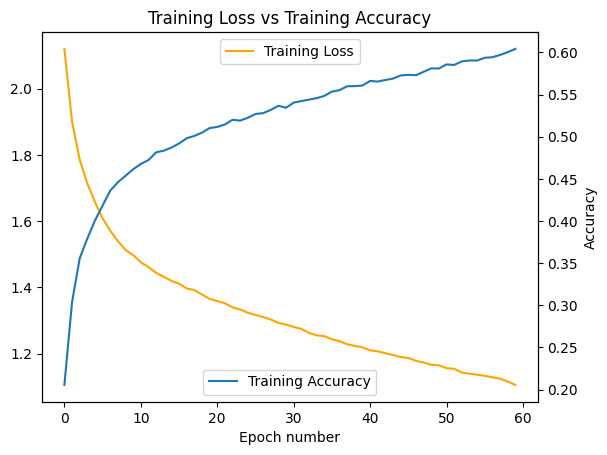

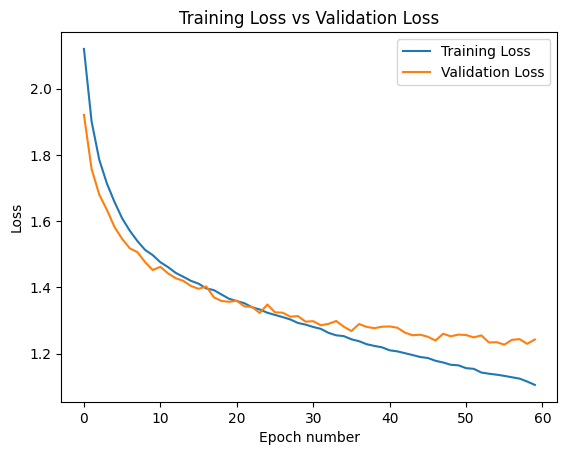

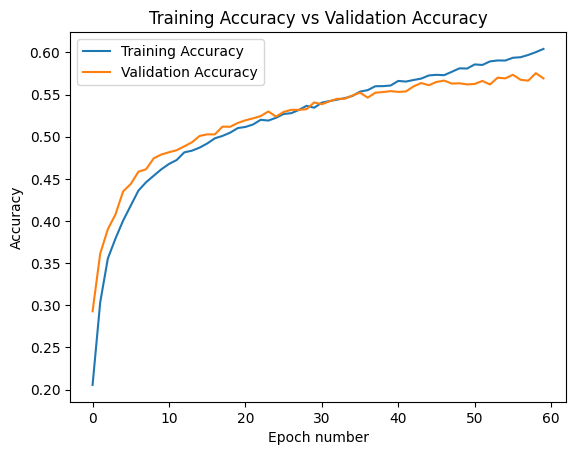

train_length = 40000 validation_length = 10000


Validation Epoch 000: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.73it/s]


epoch = 0, Train Loss: 2.0868, Validation Loss: 1.9142, Train Accuracy: 22.31%, Validation Accuracy: 29.69%


Validation Epoch 001: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.46it/s]


epoch = 1, Train Loss: 1.8659, Validation Loss: 1.7732, Train Accuracy: 31.70%, Validation Accuracy: 34.97%


Validation Epoch 002: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 81.24it/s]


epoch = 2, Train Loss: 1.7552, Validation Loss: 1.6913, Train Accuracy: 36.26%, Validation Accuracy: 38.46%


Validation Epoch 003: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 80.35it/s]


epoch = 3, Train Loss: 1.6864, Validation Loss: 1.6348, Train Accuracy: 39.06%, Validation Accuracy: 41.20%


Validation Epoch 004: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.36it/s]


epoch = 4, Train Loss: 1.6392, Validation Loss: 1.6171, Train Accuracy: 40.97%, Validation Accuracy: 41.96%


Validation Epoch 005: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 72.94it/s]


epoch = 5, Train Loss: 1.5979, Validation Loss: 1.5732, Train Accuracy: 42.58%, Validation Accuracy: 43.99%


Validation Epoch 006: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.99it/s]


epoch = 6, Train Loss: 1.5673, Validation Loss: 1.5401, Train Accuracy: 43.61%, Validation Accuracy: 44.86%


Validation Epoch 007: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.63it/s]


epoch = 7, Train Loss: 1.5390, Validation Loss: 1.5174, Train Accuracy: 44.80%, Validation Accuracy: 46.27%


Validation Epoch 008: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 80.53it/s]


epoch = 8, Train Loss: 1.5127, Validation Loss: 1.5035, Train Accuracy: 45.61%, Validation Accuracy: 46.91%


Validation Epoch 009: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 74.64it/s]


epoch = 9, Train Loss: 1.4933, Validation Loss: 1.4999, Train Accuracy: 46.12%, Validation Accuracy: 47.49%


Validation Epoch 010: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 79.45it/s]


epoch = 10, Train Loss: 1.4736, Validation Loss: 1.4666, Train Accuracy: 47.13%, Validation Accuracy: 48.31%


Validation Epoch 011: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 79.22it/s]


epoch = 11, Train Loss: 1.4555, Validation Loss: 1.4506, Train Accuracy: 47.70%, Validation Accuracy: 49.42%


Validation Epoch 012: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.76it/s]


epoch = 12, Train Loss: 1.4430, Validation Loss: 1.4564, Train Accuracy: 48.41%, Validation Accuracy: 48.45%


Validation Epoch 013: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 79.88it/s]


epoch = 13, Train Loss: 1.4259, Validation Loss: 1.4241, Train Accuracy: 48.78%, Validation Accuracy: 49.48%


Validation Epoch 014: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 69.20it/s]


epoch = 14, Train Loss: 1.4139, Validation Loss: 1.4142, Train Accuracy: 49.25%, Validation Accuracy: 50.22%


Validation Epoch 015: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.74it/s]


epoch = 15, Train Loss: 1.4035, Validation Loss: 1.4062, Train Accuracy: 49.62%, Validation Accuracy: 50.62%


Validation Epoch 016: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 80.15it/s]


epoch = 16, Train Loss: 1.3951, Validation Loss: 1.4165, Train Accuracy: 50.06%, Validation Accuracy: 50.51%


Validation Epoch 017: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 78.99it/s]


epoch = 17, Train Loss: 1.3814, Validation Loss: 1.3932, Train Accuracy: 50.32%, Validation Accuracy: 51.40%


Validation Epoch 018: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 80.42it/s]


epoch = 18, Train Loss: 1.3711, Validation Loss: 1.3875, Train Accuracy: 50.70%, Validation Accuracy: 51.25%


Validation Epoch 019: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 74.50it/s]


epoch = 19, Train Loss: 1.3623, Validation Loss: 1.3862, Train Accuracy: 51.09%, Validation Accuracy: 51.56%


Validation Epoch 020: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 76.47it/s]


epoch = 20, Train Loss: 1.3542, Validation Loss: 1.3683, Train Accuracy: 51.46%, Validation Accuracy: 52.52%


Validation Epoch 021: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 72.15it/s]


epoch = 21, Train Loss: 1.3442, Validation Loss: 1.3602, Train Accuracy: 51.64%, Validation Accuracy: 52.54%


Validation Epoch 022: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 79.83it/s]


epoch = 22, Train Loss: 1.3309, Validation Loss: 1.3570, Train Accuracy: 52.12%, Validation Accuracy: 52.67%


Validation Epoch 023: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.29it/s]


epoch = 23, Train Loss: 1.3260, Validation Loss: 1.3660, Train Accuracy: 52.55%, Validation Accuracy: 52.34%


Validation Epoch 024: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 78.98it/s]


epoch = 24, Train Loss: 1.3183, Validation Loss: 1.3578, Train Accuracy: 52.98%, Validation Accuracy: 52.89%


Validation Epoch 025: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.14it/s]


epoch = 25, Train Loss: 1.3080, Validation Loss: 1.3491, Train Accuracy: 53.20%, Validation Accuracy: 52.70%


Validation Epoch 026: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.13it/s]


epoch = 26, Train Loss: 1.3002, Validation Loss: 1.3535, Train Accuracy: 53.45%, Validation Accuracy: 53.15%


Validation Epoch 027: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.48it/s]


epoch = 27, Train Loss: 1.2914, Validation Loss: 1.3386, Train Accuracy: 53.98%, Validation Accuracy: 53.81%


Validation Epoch 028: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.10it/s]


epoch = 28, Train Loss: 1.2861, Validation Loss: 1.3327, Train Accuracy: 54.01%, Validation Accuracy: 53.61%


Validation Epoch 029: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 61.73it/s]


epoch = 29, Train Loss: 1.2777, Validation Loss: 1.3154, Train Accuracy: 54.18%, Validation Accuracy: 54.26%


Validation Epoch 030: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 80.79it/s]


epoch = 30, Train Loss: 1.2690, Validation Loss: 1.3274, Train Accuracy: 54.66%, Validation Accuracy: 54.09%


Validation Epoch 031: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 81.34it/s]


epoch = 31, Train Loss: 1.2593, Validation Loss: 1.3219, Train Accuracy: 55.10%, Validation Accuracy: 54.58%


Validation Epoch 032: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 73.69it/s]


epoch = 32, Train Loss: 1.2555, Validation Loss: 1.3084, Train Accuracy: 54.74%, Validation Accuracy: 54.47%


Validation Epoch 033: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 81.87it/s]


epoch = 33, Train Loss: 1.2468, Validation Loss: 1.3122, Train Accuracy: 55.40%, Validation Accuracy: 54.49%


Validation Epoch 034: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.41it/s]


epoch = 34, Train Loss: 1.2440, Validation Loss: 1.3045, Train Accuracy: 55.67%, Validation Accuracy: 54.75%


Validation Epoch 035: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.32it/s]


epoch = 35, Train Loss: 1.2313, Validation Loss: 1.2995, Train Accuracy: 55.88%, Validation Accuracy: 55.10%


Validation Epoch 036: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 80.10it/s]


epoch = 36, Train Loss: 1.2261, Validation Loss: 1.2975, Train Accuracy: 55.99%, Validation Accuracy: 55.15%


Validation Epoch 037: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 65.01it/s]


epoch = 37, Train Loss: 1.2168, Validation Loss: 1.2959, Train Accuracy: 56.42%, Validation Accuracy: 55.10%


Validation Epoch 038: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.12it/s]


epoch = 38, Train Loss: 1.2122, Validation Loss: 1.2855, Train Accuracy: 56.66%, Validation Accuracy: 55.34%


Validation Epoch 039: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.22it/s]


epoch = 39, Train Loss: 1.2059, Validation Loss: 1.2853, Train Accuracy: 57.02%, Validation Accuracy: 55.48%


Validation Epoch 040: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 69.93it/s]


epoch = 40, Train Loss: 1.1981, Validation Loss: 1.2929, Train Accuracy: 57.10%, Validation Accuracy: 55.44%


Validation Epoch 041: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 78.81it/s]


epoch = 41, Train Loss: 1.1982, Validation Loss: 1.2762, Train Accuracy: 57.28%, Validation Accuracy: 55.64%


Validation Epoch 042: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 79.21it/s]


epoch = 42, Train Loss: 1.1886, Validation Loss: 1.2626, Train Accuracy: 57.47%, Validation Accuracy: 56.27%


Validation Epoch 043: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.46it/s]


epoch = 43, Train Loss: 1.1795, Validation Loss: 1.2631, Train Accuracy: 57.90%, Validation Accuracy: 56.33%


Validation Epoch 044: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 77.52it/s]


epoch = 44, Train Loss: 1.1751, Validation Loss: 1.2758, Train Accuracy: 58.09%, Validation Accuracy: 55.97%


Validation Epoch 045: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 79.77it/s]


epoch = 45, Train Loss: 1.1711, Validation Loss: 1.2710, Train Accuracy: 57.88%, Validation Accuracy: 56.29%


Validation Epoch 046: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.47it/s]


epoch = 46, Train Loss: 1.1654, Validation Loss: 1.2687, Train Accuracy: 58.03%, Validation Accuracy: 56.47%


Validation Epoch 047: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.24it/s]


epoch = 47, Train Loss: 1.1606, Validation Loss: 1.2735, Train Accuracy: 58.54%, Validation Accuracy: 56.33%


Validation Epoch 048: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.48it/s]


epoch = 48, Train Loss: 1.1529, Validation Loss: 1.2590, Train Accuracy: 58.80%, Validation Accuracy: 56.44%


Validation Epoch 049: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.41it/s]


epoch = 49, Train Loss: 1.1498, Validation Loss: 1.2694, Train Accuracy: 58.97%, Validation Accuracy: 56.41%


Validation Epoch 050: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.70it/s]


epoch = 50, Train Loss: 1.1365, Validation Loss: 1.2536, Train Accuracy: 59.45%, Validation Accuracy: 57.23%


Validation Epoch 051: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 78.18it/s]


epoch = 51, Train Loss: 1.1365, Validation Loss: 1.2834, Train Accuracy: 59.33%, Validation Accuracy: 55.56%


Validation Epoch 052: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 81.43it/s]


epoch = 52, Train Loss: 1.1314, Validation Loss: 1.2455, Train Accuracy: 59.53%, Validation Accuracy: 57.20%


Validation Epoch 053: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 80.20it/s]


epoch = 53, Train Loss: 1.1230, Validation Loss: 1.2514, Train Accuracy: 59.95%, Validation Accuracy: 57.12%


Validation Epoch 054: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.11it/s]


epoch = 54, Train Loss: 1.1176, Validation Loss: 1.2385, Train Accuracy: 59.88%, Validation Accuracy: 57.32%


Validation Epoch 055: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 64.39it/s]


epoch = 55, Train Loss: 1.1145, Validation Loss: 1.2537, Train Accuracy: 60.35%, Validation Accuracy: 57.14%


Validation Epoch 056: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 81.91it/s]


epoch = 56, Train Loss: 1.1059, Validation Loss: 1.2371, Train Accuracy: 60.60%, Validation Accuracy: 57.47%


Validation Epoch 057: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 74.52it/s]


epoch = 57, Train Loss: 1.1027, Validation Loss: 1.2448, Train Accuracy: 60.78%, Validation Accuracy: 57.78%


Validation Epoch 058: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.72it/s]


epoch = 58, Train Loss: 1.0959, Validation Loss: 1.2362, Train Accuracy: 60.54%, Validation Accuracy: 57.83%


Validation Epoch 059: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.61it/s]


epoch = 59, Train Loss: 1.0912, Validation Loss: 1.2388, Train Accuracy: 61.18%, Validation Accuracy: 58.06%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 77.99it/s]


For model trained on  80.00% data with 4 heads and 16 x 16 overlapping patches,
	Train Accuracy is  64.66%
	Test Accuracy is  57.61%


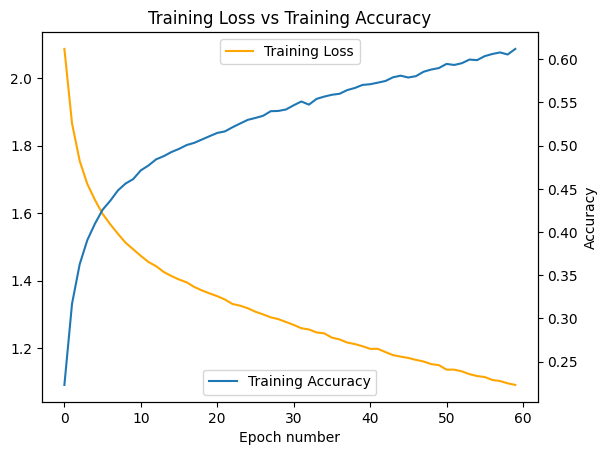

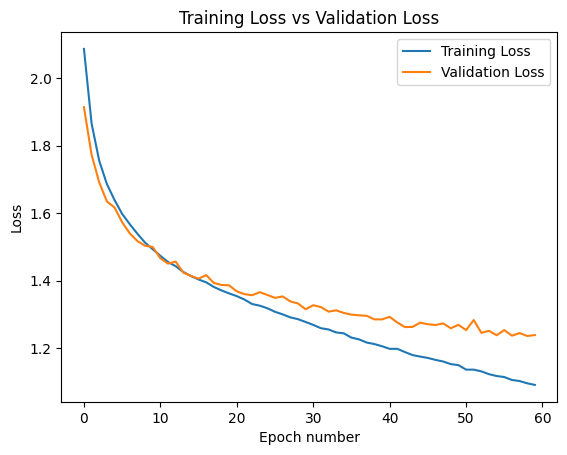

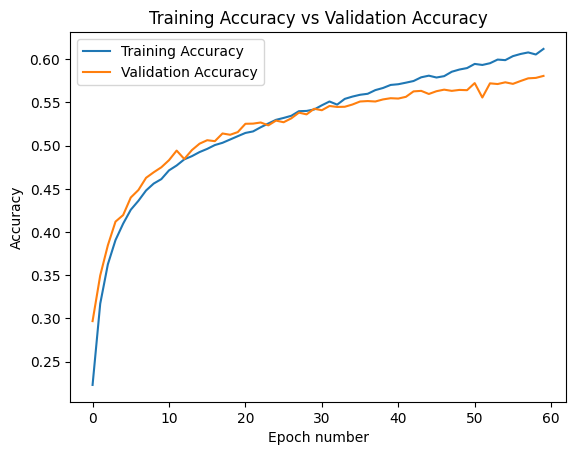

train_length = 40000 validation_length = 10000


Validation Epoch 000: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 80.68it/s]


epoch = 0, Train Loss: 2.0833, Validation Loss: 1.8581, Train Accuracy: 23.11%, Validation Accuracy: 32.85%


Validation Epoch 001: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 72.95it/s]


epoch = 1, Train Loss: 1.8524, Validation Loss: 1.7621, Train Accuracy: 33.27%, Validation Accuracy: 36.78%


Validation Epoch 002: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.95it/s]


epoch = 2, Train Loss: 1.7690, Validation Loss: 1.7046, Train Accuracy: 36.15%, Validation Accuracy: 38.68%


Validation Epoch 003: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.88it/s]


epoch = 3, Train Loss: 1.7127, Validation Loss: 1.6865, Train Accuracy: 38.29%, Validation Accuracy: 40.17%


Validation Epoch 004: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.95it/s]


epoch = 4, Train Loss: 1.6755, Validation Loss: 1.6529, Train Accuracy: 39.72%, Validation Accuracy: 41.11%


Validation Epoch 005: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.80it/s]


epoch = 5, Train Loss: 1.6386, Validation Loss: 1.6202, Train Accuracy: 41.18%, Validation Accuracy: 42.04%


Validation Epoch 006: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.30it/s]


epoch = 6, Train Loss: 1.6114, Validation Loss: 1.6085, Train Accuracy: 42.12%, Validation Accuracy: 43.39%


Validation Epoch 007: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 81.82it/s]


epoch = 7, Train Loss: 1.5837, Validation Loss: 1.5923, Train Accuracy: 43.16%, Validation Accuracy: 44.23%


Validation Epoch 008: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 78.05it/s]


epoch = 8, Train Loss: 1.5652, Validation Loss: 1.5858, Train Accuracy: 43.54%, Validation Accuracy: 44.52%


Validation Epoch 009: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.86it/s]


epoch = 9, Train Loss: 1.5429, Validation Loss: 1.5416, Train Accuracy: 44.52%, Validation Accuracy: 45.51%


Validation Epoch 010: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 79.81it/s]


epoch = 10, Train Loss: 1.5201, Validation Loss: 1.5364, Train Accuracy: 45.38%, Validation Accuracy: 46.06%


Validation Epoch 011: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 79.52it/s]


epoch = 11, Train Loss: 1.5058, Validation Loss: 1.5174, Train Accuracy: 45.91%, Validation Accuracy: 46.65%


Validation Epoch 012: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 76.97it/s]


epoch = 12, Train Loss: 1.4895, Validation Loss: 1.5329, Train Accuracy: 46.82%, Validation Accuracy: 46.70%


Validation Epoch 013: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.90it/s]


epoch = 13, Train Loss: 1.4758, Validation Loss: 1.4947, Train Accuracy: 46.96%, Validation Accuracy: 47.34%


Validation Epoch 014: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 74.94it/s]


epoch = 14, Train Loss: 1.4610, Validation Loss: 1.4969, Train Accuracy: 47.47%, Validation Accuracy: 47.62%


Validation Epoch 015: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 77.95it/s]


epoch = 15, Train Loss: 1.4492, Validation Loss: 1.4913, Train Accuracy: 48.06%, Validation Accuracy: 47.60%


Validation Epoch 016: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 80.73it/s]


epoch = 16, Train Loss: 1.4360, Validation Loss: 1.4936, Train Accuracy: 48.21%, Validation Accuracy: 48.29%


Validation Epoch 017: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.11it/s]


epoch = 17, Train Loss: 1.4232, Validation Loss: 1.4754, Train Accuracy: 49.11%, Validation Accuracy: 48.66%


Validation Epoch 018: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.09it/s]


epoch = 18, Train Loss: 1.4125, Validation Loss: 1.4588, Train Accuracy: 49.45%, Validation Accuracy: 49.02%


Validation Epoch 019: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.35it/s]


epoch = 19, Train Loss: 1.4013, Validation Loss: 1.4653, Train Accuracy: 49.76%, Validation Accuracy: 49.39%


Validation Epoch 020: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.92it/s]


epoch = 20, Train Loss: 1.3869, Validation Loss: 1.4708, Train Accuracy: 50.57%, Validation Accuracy: 49.18%


Validation Epoch 021: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 73.17it/s]


epoch = 21, Train Loss: 1.3803, Validation Loss: 1.4499, Train Accuracy: 50.59%, Validation Accuracy: 49.81%


Validation Epoch 022: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 73.57it/s]


epoch = 22, Train Loss: 1.3703, Validation Loss: 1.4547, Train Accuracy: 51.02%, Validation Accuracy: 50.00%


Validation Epoch 023: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 78.33it/s]


epoch = 23, Train Loss: 1.3624, Validation Loss: 1.4481, Train Accuracy: 51.22%, Validation Accuracy: 50.21%


Validation Epoch 024: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.67it/s]


epoch = 24, Train Loss: 1.3557, Validation Loss: 1.4452, Train Accuracy: 51.25%, Validation Accuracy: 50.13%


Validation Epoch 025: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 72.77it/s]


epoch = 25, Train Loss: 1.3433, Validation Loss: 1.4277, Train Accuracy: 51.82%, Validation Accuracy: 50.50%


Validation Epoch 026: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 72.73it/s]


epoch = 26, Train Loss: 1.3365, Validation Loss: 1.4242, Train Accuracy: 51.96%, Validation Accuracy: 50.96%


Validation Epoch 027: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.52it/s]


epoch = 27, Train Loss: 1.3285, Validation Loss: 1.4234, Train Accuracy: 52.35%, Validation Accuracy: 50.98%


Validation Epoch 028: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.25it/s]


epoch = 28, Train Loss: 1.3221, Validation Loss: 1.4134, Train Accuracy: 52.46%, Validation Accuracy: 50.91%


Validation Epoch 029: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.74it/s]


epoch = 29, Train Loss: 1.3114, Validation Loss: 1.3978, Train Accuracy: 52.92%, Validation Accuracy: 51.67%


Validation Epoch 030: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 72.68it/s]


epoch = 30, Train Loss: 1.3074, Validation Loss: 1.4060, Train Accuracy: 53.24%, Validation Accuracy: 51.38%


Validation Epoch 031: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.05it/s]


epoch = 31, Train Loss: 1.2959, Validation Loss: 1.4149, Train Accuracy: 53.61%, Validation Accuracy: 51.74%


Validation Epoch 032: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 66.46it/s]


epoch = 32, Train Loss: 1.2906, Validation Loss: 1.4098, Train Accuracy: 53.73%, Validation Accuracy: 51.34%


Validation Epoch 033: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 77.83it/s]


epoch = 33, Train Loss: 1.2847, Validation Loss: 1.4195, Train Accuracy: 54.06%, Validation Accuracy: 51.54%


Validation Epoch 034: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 76.08it/s]


epoch = 34, Train Loss: 1.2755, Validation Loss: 1.3986, Train Accuracy: 54.16%, Validation Accuracy: 51.69%


Validation Epoch 035: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 75.87it/s]


epoch = 35, Train Loss: 1.2700, Validation Loss: 1.4087, Train Accuracy: 54.64%, Validation Accuracy: 52.02%


Validation Epoch 036: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.62it/s]


epoch = 36, Train Loss: 1.2682, Validation Loss: 1.3915, Train Accuracy: 54.59%, Validation Accuracy: 52.13%


Validation Epoch 037: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 80.92it/s]


epoch = 37, Train Loss: 1.2583, Validation Loss: 1.3762, Train Accuracy: 54.70%, Validation Accuracy: 52.90%


Validation Epoch 038: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.96it/s]


epoch = 38, Train Loss: 1.2512, Validation Loss: 1.3730, Train Accuracy: 55.22%, Validation Accuracy: 53.02%


Validation Epoch 039: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.66it/s]


epoch = 39, Train Loss: 1.2462, Validation Loss: 1.3811, Train Accuracy: 55.53%, Validation Accuracy: 52.56%


Validation Epoch 040: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.14it/s]


epoch = 40, Train Loss: 1.2408, Validation Loss: 1.3741, Train Accuracy: 55.34%, Validation Accuracy: 53.08%


Validation Epoch 041: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 72.35it/s]


epoch = 41, Train Loss: 1.2333, Validation Loss: 1.3763, Train Accuracy: 55.80%, Validation Accuracy: 52.95%


Validation Epoch 042: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 69.73it/s]


epoch = 42, Train Loss: 1.2259, Validation Loss: 1.3703, Train Accuracy: 55.84%, Validation Accuracy: 53.57%


Validation Epoch 043: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 63.43it/s]


epoch = 43, Train Loss: 1.2204, Validation Loss: 1.3765, Train Accuracy: 56.22%, Validation Accuracy: 53.11%


Validation Epoch 044: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.17it/s]


epoch = 44, Train Loss: 1.2132, Validation Loss: 1.3576, Train Accuracy: 56.61%, Validation Accuracy: 53.64%


Validation Epoch 045: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.70it/s]


epoch = 45, Train Loss: 1.2093, Validation Loss: 1.3661, Train Accuracy: 56.39%, Validation Accuracy: 53.49%


Validation Epoch 046: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 77.39it/s]


epoch = 46, Train Loss: 1.2016, Validation Loss: 1.3649, Train Accuracy: 57.03%, Validation Accuracy: 53.30%


Validation Epoch 047: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 79.95it/s]


epoch = 47, Train Loss: 1.1965, Validation Loss: 1.3718, Train Accuracy: 57.21%, Validation Accuracy: 53.22%


Validation Epoch 048: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 81.81it/s]


epoch = 48, Train Loss: 1.1907, Validation Loss: 1.3538, Train Accuracy: 57.36%, Validation Accuracy: 53.84%


Validation Epoch 049: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 75.57it/s]


epoch = 49, Train Loss: 1.1839, Validation Loss: 1.3620, Train Accuracy: 57.77%, Validation Accuracy: 53.59%


Validation Epoch 050: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.79it/s]


epoch = 50, Train Loss: 1.1830, Validation Loss: 1.3631, Train Accuracy: 57.65%, Validation Accuracy: 53.93%


Validation Epoch 051: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 62.66it/s]


epoch = 51, Train Loss: 1.1740, Validation Loss: 1.3453, Train Accuracy: 58.02%, Validation Accuracy: 54.35%


Validation Epoch 052: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 75.43it/s]


epoch = 52, Train Loss: 1.1623, Validation Loss: 1.3629, Train Accuracy: 58.42%, Validation Accuracy: 53.98%


Validation Epoch 053: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.36it/s]


epoch = 53, Train Loss: 1.1594, Validation Loss: 1.3399, Train Accuracy: 58.38%, Validation Accuracy: 54.72%


Validation Epoch 054: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.39it/s]


epoch = 54, Train Loss: 1.1570, Validation Loss: 1.3453, Train Accuracy: 58.45%, Validation Accuracy: 54.78%


Validation Epoch 055: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.80it/s]


epoch = 55, Train Loss: 1.1512, Validation Loss: 1.3476, Train Accuracy: 58.65%, Validation Accuracy: 54.54%


Validation Epoch 056: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 80.58it/s]


epoch = 56, Train Loss: 1.1451, Validation Loss: 1.3537, Train Accuracy: 58.94%, Validation Accuracy: 54.48%


Validation Epoch 057: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 81.49it/s]


epoch = 57, Train Loss: 1.1398, Validation Loss: 1.3554, Train Accuracy: 59.31%, Validation Accuracy: 54.54%


Validation Epoch 058: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 69.05it/s]


epoch = 58, Train Loss: 1.1405, Validation Loss: 1.3485, Train Accuracy: 59.35%, Validation Accuracy: 54.36%


Validation Epoch 059: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.30it/s]


epoch = 59, Train Loss: 1.1321, Validation Loss: 1.3351, Train Accuracy: 59.16%, Validation Accuracy: 55.04%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 81.62it/s]


For model trained on  80.00% data with 4 heads and 16 x 16 non-overlapping patches,
	Train Accuracy is  62.68%
	Test Accuracy is  55.10%


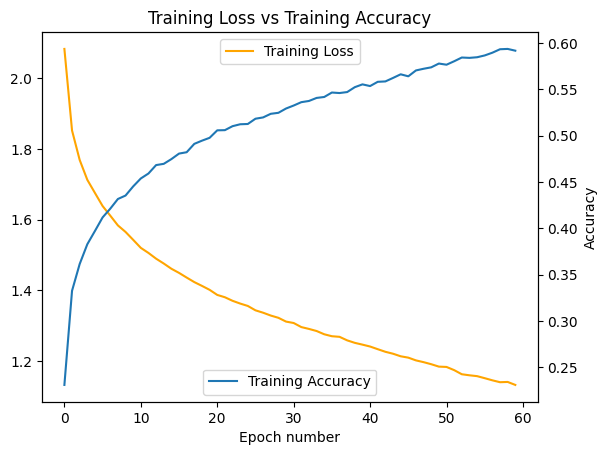

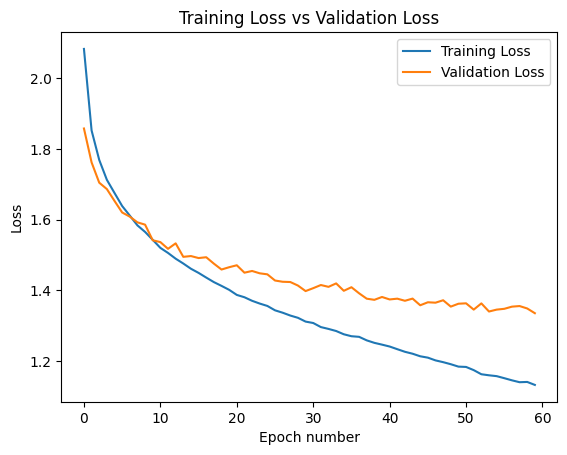

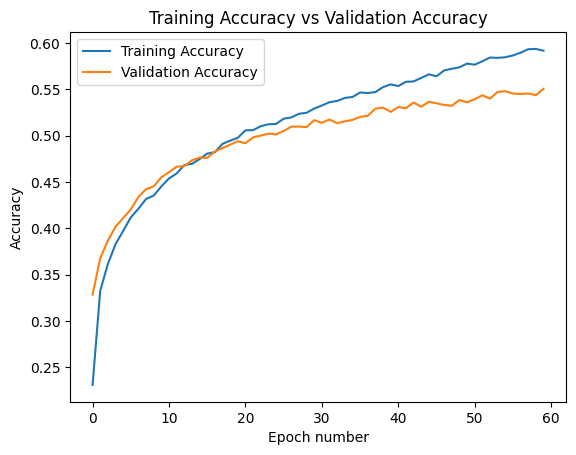

In [15]:
config_data = default_config_data.copy()
config_data['num_of_encoders'] = 4
result_c_data = {}
for patch_size in [4, 8, 16]:
    for patch_type in [True, False]:
        config_data['patch_size'] = patch_size
        config_data['overlap_patches'] = patch_type
        _, train_loss_data, valid_loss_data, train_acc_data, valid_acc_data = train_test_model(train_dataset, test_dataset, config_data)
        result_c_data[f'train_loss_{patch_size}_{patch_type}'] = train_loss_data
        result_c_data[f'valid_loss_{patch_size}_{patch_type}'] = valid_loss_data
        result_c_data[f'train_acc_{patch_size}_{patch_type}'] = train_acc_data
        result_c_data[f'valid_acc_{patch_size}_{patch_type}'] = valid_acc_data
        

train_length = 40000 validation_length = 10000


Validation Epoch 000: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:03<00:00, 20.28it/s]


epoch = 0, Train Loss: 2.0401, Validation Loss: 1.9048, Train Accuracy: 23.66%, Validation Accuracy: 29.12%


Validation Epoch 001: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.87it/s]


epoch = 1, Train Loss: 1.8666, Validation Loss: 1.7704, Train Accuracy: 31.14%, Validation Accuracy: 34.69%


Validation Epoch 002: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.54it/s]


epoch = 2, Train Loss: 1.7345, Validation Loss: 1.6828, Train Accuracy: 36.30%, Validation Accuracy: 39.74%


Validation Epoch 003: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.52it/s]


epoch = 3, Train Loss: 1.6271, Validation Loss: 1.5276, Train Accuracy: 40.32%, Validation Accuracy: 45.32%


Validation Epoch 004: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.49it/s]


epoch = 4, Train Loss: 1.5343, Validation Loss: 1.4723, Train Accuracy: 44.12%, Validation Accuracy: 47.25%


Validation Epoch 005: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.43it/s]


epoch = 5, Train Loss: 1.4760, Validation Loss: 1.4037, Train Accuracy: 46.25%, Validation Accuracy: 49.33%


Validation Epoch 006: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.43it/s]


epoch = 6, Train Loss: 1.4232, Validation Loss: 1.3635, Train Accuracy: 48.25%, Validation Accuracy: 50.85%


Validation Epoch 007: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.65it/s]


epoch = 7, Train Loss: 1.3889, Validation Loss: 1.3761, Train Accuracy: 49.58%, Validation Accuracy: 51.76%


Validation Epoch 008: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.37it/s]


epoch = 8, Train Loss: 1.3532, Validation Loss: 1.3110, Train Accuracy: 51.20%, Validation Accuracy: 52.72%


Validation Epoch 009: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.31it/s]


epoch = 9, Train Loss: 1.3256, Validation Loss: 1.2963, Train Accuracy: 52.16%, Validation Accuracy: 53.50%


Validation Epoch 010: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.51it/s]


epoch = 10, Train Loss: 1.2965, Validation Loss: 1.2843, Train Accuracy: 53.41%, Validation Accuracy: 54.29%


Validation Epoch 011: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.56it/s]


epoch = 11, Train Loss: 1.2685, Validation Loss: 1.2274, Train Accuracy: 54.02%, Validation Accuracy: 56.09%


Validation Epoch 012: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.45it/s]


epoch = 12, Train Loss: 1.2477, Validation Loss: 1.2403, Train Accuracy: 54.94%, Validation Accuracy: 55.87%


Validation Epoch 013: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.61it/s]


epoch = 13, Train Loss: 1.2291, Validation Loss: 1.2152, Train Accuracy: 55.79%, Validation Accuracy: 56.73%


Validation Epoch 014: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.55it/s]


epoch = 14, Train Loss: 1.2070, Validation Loss: 1.1943, Train Accuracy: 56.49%, Validation Accuracy: 57.60%


Validation Epoch 015: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.51it/s]


epoch = 15, Train Loss: 1.1858, Validation Loss: 1.1817, Train Accuracy: 57.21%, Validation Accuracy: 57.97%


Validation Epoch 016: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.57it/s]


epoch = 16, Train Loss: 1.1691, Validation Loss: 1.1792, Train Accuracy: 58.17%, Validation Accuracy: 58.51%


Validation Epoch 017: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.57it/s]


epoch = 17, Train Loss: 1.1524, Validation Loss: 1.1547, Train Accuracy: 58.77%, Validation Accuracy: 59.23%


Validation Epoch 018: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.53it/s]


epoch = 18, Train Loss: 1.1359, Validation Loss: 1.1452, Train Accuracy: 59.18%, Validation Accuracy: 59.47%


Validation Epoch 019: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.44it/s]


epoch = 19, Train Loss: 1.1189, Validation Loss: 1.1441, Train Accuracy: 59.62%, Validation Accuracy: 59.65%


Validation Epoch 020: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.54it/s]


epoch = 20, Train Loss: 1.1015, Validation Loss: 1.1421, Train Accuracy: 60.56%, Validation Accuracy: 59.85%


Validation Epoch 021: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.52it/s]


epoch = 21, Train Loss: 1.0894, Validation Loss: 1.1378, Train Accuracy: 60.88%, Validation Accuracy: 60.38%


Validation Epoch 022: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.47it/s]


epoch = 22, Train Loss: 1.0811, Validation Loss: 1.1069, Train Accuracy: 61.24%, Validation Accuracy: 61.01%


Validation Epoch 023: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.51it/s]


epoch = 23, Train Loss: 1.0646, Validation Loss: 1.0764, Train Accuracy: 61.83%, Validation Accuracy: 61.88%


Validation Epoch 024: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.40it/s]


epoch = 24, Train Loss: 1.0499, Validation Loss: 1.0968, Train Accuracy: 62.35%, Validation Accuracy: 61.64%


Validation Epoch 025: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.51it/s]


epoch = 25, Train Loss: 1.0352, Validation Loss: 1.0847, Train Accuracy: 62.99%, Validation Accuracy: 61.57%


Validation Epoch 026: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.56it/s]


epoch = 26, Train Loss: 1.0194, Validation Loss: 1.0826, Train Accuracy: 63.72%, Validation Accuracy: 61.69%


Validation Epoch 027: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.50it/s]


epoch = 27, Train Loss: 1.0094, Validation Loss: 1.0708, Train Accuracy: 63.85%, Validation Accuracy: 62.76%


Validation Epoch 028: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.51it/s]


epoch = 28, Train Loss: 1.0015, Validation Loss: 1.0609, Train Accuracy: 64.42%, Validation Accuracy: 62.94%


Validation Epoch 029: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.52it/s]


epoch = 29, Train Loss: 0.9883, Validation Loss: 1.0674, Train Accuracy: 64.63%, Validation Accuracy: 62.92%


Validation Epoch 030: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.34it/s]


epoch = 30, Train Loss: 0.9762, Validation Loss: 1.0542, Train Accuracy: 65.15%, Validation Accuracy: 63.06%


Validation Epoch 031: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.38it/s]


epoch = 31, Train Loss: 0.9648, Validation Loss: 1.0302, Train Accuracy: 65.56%, Validation Accuracy: 63.88%


Validation Epoch 032: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.49it/s]


epoch = 32, Train Loss: 0.9518, Validation Loss: 1.0426, Train Accuracy: 65.89%, Validation Accuracy: 64.43%


Validation Epoch 033: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.51it/s]


epoch = 33, Train Loss: 0.9446, Validation Loss: 1.0352, Train Accuracy: 66.19%, Validation Accuracy: 63.62%


Validation Epoch 034: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.46it/s]


epoch = 34, Train Loss: 0.9336, Validation Loss: 1.0459, Train Accuracy: 66.65%, Validation Accuracy: 64.18%


Validation Epoch 035: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.52it/s]


epoch = 35, Train Loss: 0.9192, Validation Loss: 1.0393, Train Accuracy: 66.98%, Validation Accuracy: 64.62%


Validation Epoch 036: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.52it/s]


epoch = 36, Train Loss: 0.9120, Validation Loss: 1.0556, Train Accuracy: 67.46%, Validation Accuracy: 63.69%


Validation Epoch 037: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.39it/s]


epoch = 37, Train Loss: 0.9035, Validation Loss: 1.0325, Train Accuracy: 67.78%, Validation Accuracy: 64.48%


Validation Epoch 038: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.50it/s]


epoch = 38, Train Loss: 0.8952, Validation Loss: 1.0272, Train Accuracy: 67.99%, Validation Accuracy: 64.61%


Validation Epoch 039: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.46it/s]


epoch = 39, Train Loss: 0.8829, Validation Loss: 1.0293, Train Accuracy: 68.44%, Validation Accuracy: 64.81%


Validation Epoch 040: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.39it/s]


epoch = 40, Train Loss: 0.8732, Validation Loss: 1.0248, Train Accuracy: 68.95%, Validation Accuracy: 64.74%


Validation Epoch 041: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.55it/s]


epoch = 41, Train Loss: 0.8633, Validation Loss: 1.0065, Train Accuracy: 69.39%, Validation Accuracy: 65.68%


Validation Epoch 042: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.48it/s]


epoch = 42, Train Loss: 0.8549, Validation Loss: 1.0353, Train Accuracy: 69.64%, Validation Accuracy: 64.92%


Validation Epoch 043: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.39it/s]


epoch = 43, Train Loss: 0.8452, Validation Loss: 1.0115, Train Accuracy: 69.97%, Validation Accuracy: 65.12%


Validation Epoch 044: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.52it/s]


epoch = 44, Train Loss: 0.8352, Validation Loss: 1.0240, Train Accuracy: 70.38%, Validation Accuracy: 65.23%


Validation Epoch 045: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.39it/s]


epoch = 45, Train Loss: 0.8297, Validation Loss: 1.0085, Train Accuracy: 70.36%, Validation Accuracy: 66.00%


Validation Epoch 046: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.47it/s]


epoch = 46, Train Loss: 0.8221, Validation Loss: 1.0199, Train Accuracy: 70.61%, Validation Accuracy: 65.49%


Validation Epoch 047: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.48it/s]


epoch = 47, Train Loss: 0.8099, Validation Loss: 1.0038, Train Accuracy: 71.09%, Validation Accuracy: 65.97%


Validation Epoch 048: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.44it/s]


epoch = 48, Train Loss: 0.8032, Validation Loss: 1.0040, Train Accuracy: 71.38%, Validation Accuracy: 66.05%


Validation Epoch 049: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.46it/s]


epoch = 49, Train Loss: 0.7949, Validation Loss: 0.9794, Train Accuracy: 71.71%, Validation Accuracy: 66.57%


Validation Epoch 050: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.52it/s]


epoch = 50, Train Loss: 0.7837, Validation Loss: 0.9937, Train Accuracy: 72.07%, Validation Accuracy: 66.67%


Validation Epoch 051: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.54it/s]


epoch = 51, Train Loss: 0.7753, Validation Loss: 1.0036, Train Accuracy: 72.45%, Validation Accuracy: 66.63%


Validation Epoch 052: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.42it/s]


epoch = 52, Train Loss: 0.7703, Validation Loss: 0.9950, Train Accuracy: 72.61%, Validation Accuracy: 66.09%


Validation Epoch 053: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.48it/s]


epoch = 53, Train Loss: 0.7575, Validation Loss: 0.9799, Train Accuracy: 73.08%, Validation Accuracy: 67.01%


Validation Epoch 054: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.38it/s]


epoch = 54, Train Loss: 0.7463, Validation Loss: 0.9956, Train Accuracy: 73.50%, Validation Accuracy: 66.31%


Validation Epoch 055: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.43it/s]


epoch = 55, Train Loss: 0.7434, Validation Loss: 0.9896, Train Accuracy: 73.52%, Validation Accuracy: 66.89%


Validation Epoch 056: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.43it/s]


epoch = 56, Train Loss: 0.7321, Validation Loss: 0.9894, Train Accuracy: 74.01%, Validation Accuracy: 67.03%


Validation Epoch 057: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.54it/s]


epoch = 57, Train Loss: 0.7267, Validation Loss: 0.9865, Train Accuracy: 74.26%, Validation Accuracy: 67.31%


Validation Epoch 058: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.50it/s]


epoch = 58, Train Loss: 0.7184, Validation Loss: 0.9888, Train Accuracy: 74.44%, Validation Accuracy: 66.98%


Validation Epoch 059: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.42it/s]


epoch = 59, Train Loss: 0.7103, Validation Loss: 0.9829, Train Accuracy: 74.63%, Validation Accuracy: 67.23%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.49it/s]


For model trained on  80.00% data with 4 heads and 4 x 4 non-overlapping patches,
	Train Accuracy is  79.71%
	Test Accuracy is  67.62%


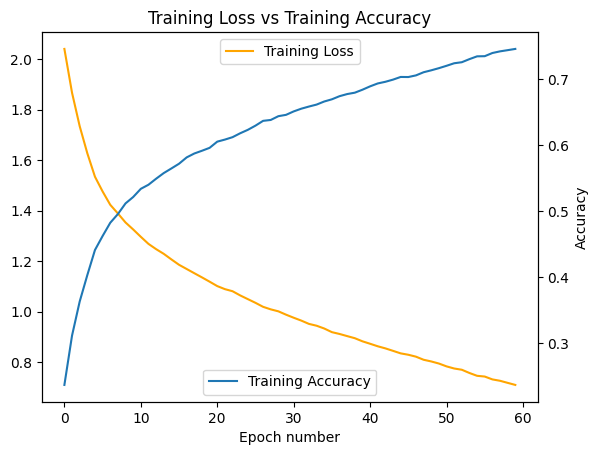

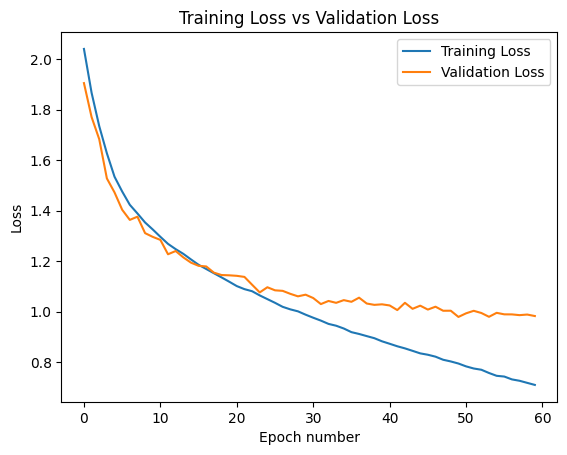

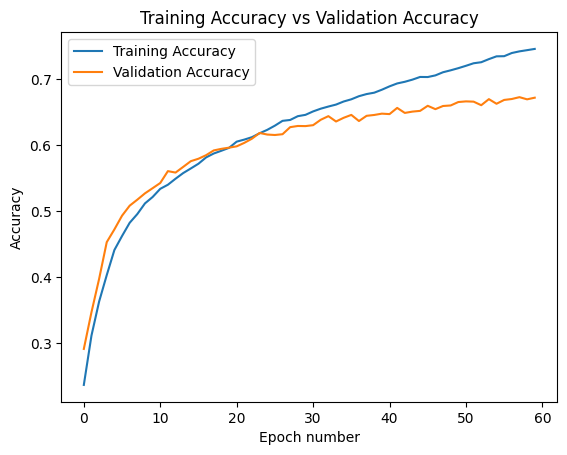

train_length = 40000 validation_length = 10000


Validation Epoch 000: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.78it/s]


epoch = 0, Train Loss: 2.0401, Validation Loss: 1.9097, Train Accuracy: 23.62%, Validation Accuracy: 28.75%


Validation Epoch 001: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.88it/s]


epoch = 1, Train Loss: 1.8742, Validation Loss: 1.7554, Train Accuracy: 30.82%, Validation Accuracy: 35.12%


Validation Epoch 002: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.91it/s]


epoch = 2, Train Loss: 1.7308, Validation Loss: 1.6663, Train Accuracy: 36.23%, Validation Accuracy: 39.62%


Validation Epoch 003: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.93it/s]


epoch = 3, Train Loss: 1.6134, Validation Loss: 1.5889, Train Accuracy: 41.05%, Validation Accuracy: 42.87%


Validation Epoch 004: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.81it/s]


epoch = 4, Train Loss: 1.5334, Validation Loss: 1.5093, Train Accuracy: 44.23%, Validation Accuracy: 46.22%


Validation Epoch 005: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.80it/s]


epoch = 5, Train Loss: 1.4733, Validation Loss: 1.4491, Train Accuracy: 46.56%, Validation Accuracy: 48.74%


Validation Epoch 006: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.75it/s]


epoch = 6, Train Loss: 1.4277, Validation Loss: 1.3923, Train Accuracy: 48.28%, Validation Accuracy: 50.61%


Validation Epoch 007: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.93it/s]


epoch = 7, Train Loss: 1.3856, Validation Loss: 1.3983, Train Accuracy: 50.13%, Validation Accuracy: 50.57%


Validation Epoch 008: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.93it/s]


epoch = 8, Train Loss: 1.3535, Validation Loss: 1.3429, Train Accuracy: 51.25%, Validation Accuracy: 51.96%


Validation Epoch 009: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.76it/s]


epoch = 9, Train Loss: 1.3295, Validation Loss: 1.2910, Train Accuracy: 51.94%, Validation Accuracy: 53.54%


Validation Epoch 010: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.81it/s]


epoch = 10, Train Loss: 1.2987, Validation Loss: 1.2880, Train Accuracy: 53.06%, Validation Accuracy: 53.99%


Validation Epoch 011: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.88it/s]


epoch = 11, Train Loss: 1.2741, Validation Loss: 1.3436, Train Accuracy: 54.13%, Validation Accuracy: 52.58%


Validation Epoch 012: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.81it/s]


epoch = 12, Train Loss: 1.2508, Validation Loss: 1.2464, Train Accuracy: 54.92%, Validation Accuracy: 55.20%


Validation Epoch 013: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.86it/s]


epoch = 13, Train Loss: 1.2258, Validation Loss: 1.2587, Train Accuracy: 55.85%, Validation Accuracy: 55.38%


Validation Epoch 014: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.88it/s]


epoch = 14, Train Loss: 1.2033, Validation Loss: 1.2228, Train Accuracy: 56.66%, Validation Accuracy: 56.06%


Validation Epoch 015: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.85it/s]


epoch = 15, Train Loss: 1.1851, Validation Loss: 1.2104, Train Accuracy: 57.29%, Validation Accuracy: 56.94%


Validation Epoch 016: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.70it/s]


epoch = 16, Train Loss: 1.1673, Validation Loss: 1.1826, Train Accuracy: 58.06%, Validation Accuracy: 57.73%


Validation Epoch 017: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.78it/s]


epoch = 17, Train Loss: 1.1478, Validation Loss: 1.1622, Train Accuracy: 58.93%, Validation Accuracy: 58.48%


Validation Epoch 018: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.92it/s]


epoch = 18, Train Loss: 1.1268, Validation Loss: 1.1417, Train Accuracy: 59.59%, Validation Accuracy: 59.11%


Validation Epoch 019: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.85it/s]


epoch = 19, Train Loss: 1.1135, Validation Loss: 1.1370, Train Accuracy: 59.98%, Validation Accuracy: 59.35%


Validation Epoch 020: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.82it/s]


epoch = 20, Train Loss: 1.0992, Validation Loss: 1.0986, Train Accuracy: 60.57%, Validation Accuracy: 61.02%


Validation Epoch 021: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.88it/s]


epoch = 21, Train Loss: 1.0758, Validation Loss: 1.0899, Train Accuracy: 61.36%, Validation Accuracy: 61.18%


Validation Epoch 022: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.79it/s]


epoch = 22, Train Loss: 1.0653, Validation Loss: 1.0936, Train Accuracy: 62.10%, Validation Accuracy: 61.79%


Validation Epoch 023: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.77it/s]


epoch = 23, Train Loss: 1.0468, Validation Loss: 1.0920, Train Accuracy: 62.45%, Validation Accuracy: 61.37%


Validation Epoch 024: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.80it/s]


epoch = 24, Train Loss: 1.0314, Validation Loss: 1.0754, Train Accuracy: 63.18%, Validation Accuracy: 62.14%


Validation Epoch 025: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.84it/s]


epoch = 25, Train Loss: 1.0237, Validation Loss: 1.0701, Train Accuracy: 63.61%, Validation Accuracy: 62.32%


Validation Epoch 026: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.86it/s]


epoch = 26, Train Loss: 1.0082, Validation Loss: 1.0887, Train Accuracy: 64.06%, Validation Accuracy: 62.08%


Validation Epoch 027: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.81it/s]


epoch = 27, Train Loss: 1.0014, Validation Loss: 1.0643, Train Accuracy: 64.28%, Validation Accuracy: 62.51%


Validation Epoch 028: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.85it/s]


epoch = 28, Train Loss: 0.9795, Validation Loss: 1.0548, Train Accuracy: 65.15%, Validation Accuracy: 62.63%


Validation Epoch 029: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.84it/s]


epoch = 29, Train Loss: 0.9706, Validation Loss: 1.0411, Train Accuracy: 65.32%, Validation Accuracy: 63.17%


Validation Epoch 030: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.91it/s]


epoch = 30, Train Loss: 0.9602, Validation Loss: 1.0431, Train Accuracy: 65.91%, Validation Accuracy: 63.52%


Validation Epoch 031: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.82it/s]


epoch = 31, Train Loss: 0.9485, Validation Loss: 1.0557, Train Accuracy: 66.22%, Validation Accuracy: 63.29%


Validation Epoch 032: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.82it/s]


epoch = 32, Train Loss: 0.9361, Validation Loss: 1.0412, Train Accuracy: 66.79%, Validation Accuracy: 64.01%


Validation Epoch 033: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.82it/s]


epoch = 33, Train Loss: 0.9253, Validation Loss: 1.0242, Train Accuracy: 66.94%, Validation Accuracy: 64.05%


Validation Epoch 034: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.85it/s]


epoch = 34, Train Loss: 0.9153, Validation Loss: 1.0376, Train Accuracy: 67.42%, Validation Accuracy: 63.46%


Validation Epoch 035: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.88it/s]


epoch = 35, Train Loss: 0.9065, Validation Loss: 1.0091, Train Accuracy: 67.80%, Validation Accuracy: 64.86%


Validation Epoch 036: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.90it/s]


epoch = 36, Train Loss: 0.8958, Validation Loss: 0.9987, Train Accuracy: 68.36%, Validation Accuracy: 64.95%


Validation Epoch 037: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.86it/s]


epoch = 37, Train Loss: 0.8869, Validation Loss: 1.0323, Train Accuracy: 68.50%, Validation Accuracy: 64.08%


Validation Epoch 038: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.89it/s]


epoch = 38, Train Loss: 0.8751, Validation Loss: 1.0006, Train Accuracy: 68.94%, Validation Accuracy: 64.81%


Validation Epoch 039: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.87it/s]


epoch = 39, Train Loss: 0.8630, Validation Loss: 1.0108, Train Accuracy: 69.41%, Validation Accuracy: 64.70%


Validation Epoch 040: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.94it/s]


epoch = 40, Train Loss: 0.8535, Validation Loss: 0.9826, Train Accuracy: 69.61%, Validation Accuracy: 66.12%


Validation Epoch 041: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.81it/s]


epoch = 41, Train Loss: 0.8447, Validation Loss: 0.9867, Train Accuracy: 70.10%, Validation Accuracy: 65.89%


Validation Epoch 042: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.90it/s]


epoch = 42, Train Loss: 0.8355, Validation Loss: 1.0013, Train Accuracy: 70.54%, Validation Accuracy: 65.80%


Validation Epoch 043: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.81it/s]


epoch = 43, Train Loss: 0.8229, Validation Loss: 0.9926, Train Accuracy: 70.74%, Validation Accuracy: 65.62%


Validation Epoch 044: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.84it/s]


epoch = 44, Train Loss: 0.8156, Validation Loss: 0.9993, Train Accuracy: 70.98%, Validation Accuracy: 66.24%


Validation Epoch 045: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.79it/s]


epoch = 45, Train Loss: 0.8107, Validation Loss: 0.9743, Train Accuracy: 71.11%, Validation Accuracy: 66.59%


Validation Epoch 046: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.88it/s]


epoch = 46, Train Loss: 0.7958, Validation Loss: 0.9837, Train Accuracy: 71.86%, Validation Accuracy: 66.53%


Validation Epoch 047: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.86it/s]


epoch = 47, Train Loss: 0.7897, Validation Loss: 0.9682, Train Accuracy: 71.95%, Validation Accuracy: 66.83%


Validation Epoch 048: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.92it/s]


epoch = 48, Train Loss: 0.7799, Validation Loss: 0.9676, Train Accuracy: 72.25%, Validation Accuracy: 66.59%


Validation Epoch 049: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.87it/s]


epoch = 49, Train Loss: 0.7705, Validation Loss: 0.9886, Train Accuracy: 72.49%, Validation Accuracy: 66.78%


Validation Epoch 050: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.85it/s]


epoch = 50, Train Loss: 0.7616, Validation Loss: 0.9618, Train Accuracy: 73.06%, Validation Accuracy: 67.16%


Validation Epoch 051: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.89it/s]


epoch = 51, Train Loss: 0.7508, Validation Loss: 0.9592, Train Accuracy: 73.42%, Validation Accuracy: 67.37%


Validation Epoch 052: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.87it/s]


epoch = 52, Train Loss: 0.7451, Validation Loss: 0.9566, Train Accuracy: 73.62%, Validation Accuracy: 68.11%


Validation Epoch 053: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.85it/s]


epoch = 53, Train Loss: 0.7352, Validation Loss: 0.9677, Train Accuracy: 73.88%, Validation Accuracy: 67.02%


Validation Epoch 054: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.77it/s]


epoch = 54, Train Loss: 0.7281, Validation Loss: 0.9544, Train Accuracy: 74.03%, Validation Accuracy: 67.83%


Validation Epoch 055: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.69it/s]


epoch = 55, Train Loss: 0.7132, Validation Loss: 0.9512, Train Accuracy: 74.80%, Validation Accuracy: 68.22%


Validation Epoch 056: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.82it/s]


epoch = 56, Train Loss: 0.7086, Validation Loss: 0.9578, Train Accuracy: 74.85%, Validation Accuracy: 68.50%


Validation Epoch 057: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.88it/s]


epoch = 57, Train Loss: 0.7013, Validation Loss: 0.9693, Train Accuracy: 75.24%, Validation Accuracy: 67.50%


Validation Epoch 058: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.85it/s]


epoch = 58, Train Loss: 0.6920, Validation Loss: 0.9605, Train Accuracy: 75.65%, Validation Accuracy: 67.82%


Validation Epoch 059: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.80it/s]


epoch = 59, Train Loss: 0.6856, Validation Loss: 0.9558, Train Accuracy: 75.59%, Validation Accuracy: 67.92%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.78it/s]


For model trained on  80.00% data with 8 heads and 4 x 4 non-overlapping patches,
	Train Accuracy is  79.97%
	Test Accuracy is  67.89%


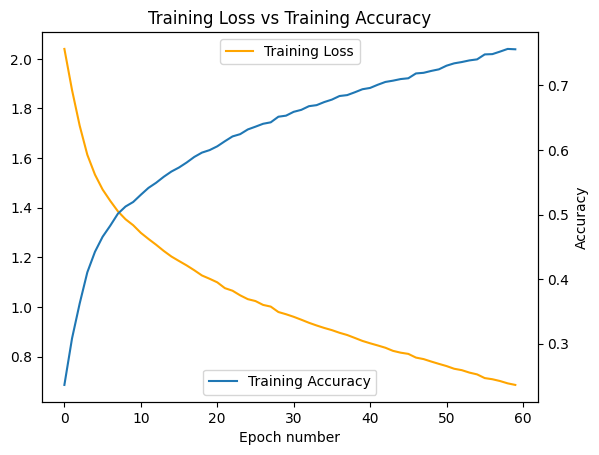

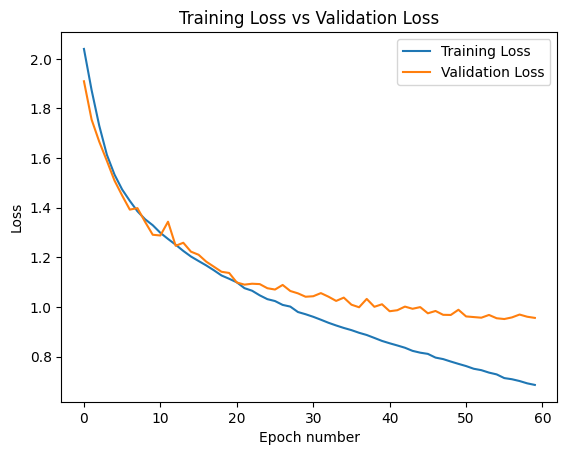

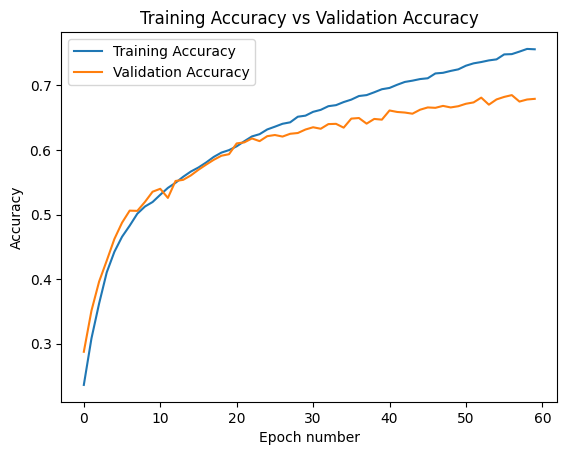

train_length = 40000 validation_length = 10000


Validation Epoch 000: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 16.64it/s]


epoch = 0, Train Loss: 2.0510, Validation Loss: 1.9207, Train Accuracy: 22.82%, Validation Accuracy: 28.05%


Validation Epoch 001: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 16.72it/s]


epoch = 1, Train Loss: 1.8993, Validation Loss: 1.7966, Train Accuracy: 29.85%, Validation Accuracy: 34.37%


Validation Epoch 002: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 16.73it/s]


epoch = 2, Train Loss: 1.7670, Validation Loss: 1.6757, Train Accuracy: 35.25%, Validation Accuracy: 38.95%


Validation Epoch 003: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 16.70it/s]


epoch = 3, Train Loss: 1.6515, Validation Loss: 1.6028, Train Accuracy: 39.09%, Validation Accuracy: 42.33%


Validation Epoch 004: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 16.75it/s]


epoch = 4, Train Loss: 1.5655, Validation Loss: 1.5307, Train Accuracy: 42.70%, Validation Accuracy: 44.95%


Validation Epoch 005: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 16.72it/s]


epoch = 5, Train Loss: 1.5015, Validation Loss: 1.4628, Train Accuracy: 45.34%, Validation Accuracy: 47.64%


Validation Epoch 006: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 16.73it/s]


epoch = 6, Train Loss: 1.4474, Validation Loss: 1.4308, Train Accuracy: 47.85%, Validation Accuracy: 49.29%


Validation Epoch 007: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 16.76it/s]


epoch = 7, Train Loss: 1.4073, Validation Loss: 1.3882, Train Accuracy: 48.91%, Validation Accuracy: 50.98%


Validation Epoch 008: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 16.77it/s]


epoch = 8, Train Loss: 1.3724, Validation Loss: 1.3398, Train Accuracy: 50.47%, Validation Accuracy: 52.44%


Validation Epoch 009: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 16.74it/s]


epoch = 9, Train Loss: 1.3400, Validation Loss: 1.3244, Train Accuracy: 51.62%, Validation Accuracy: 52.79%


Validation Epoch 010: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 16.70it/s]


epoch = 10, Train Loss: 1.3119, Validation Loss: 1.3131, Train Accuracy: 52.52%, Validation Accuracy: 53.36%


Validation Epoch 011: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 16.77it/s]


epoch = 11, Train Loss: 1.2819, Validation Loss: 1.2720, Train Accuracy: 53.50%, Validation Accuracy: 54.96%


Validation Epoch 012: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 16.65it/s]


epoch = 12, Train Loss: 1.2607, Validation Loss: 1.2656, Train Accuracy: 54.53%, Validation Accuracy: 55.27%


Validation Epoch 013: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 16.68it/s]


epoch = 13, Train Loss: 1.2399, Validation Loss: 1.2476, Train Accuracy: 55.25%, Validation Accuracy: 56.08%


Validation Epoch 014: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 16.71it/s]


epoch = 14, Train Loss: 1.2130, Validation Loss: 1.2183, Train Accuracy: 56.53%, Validation Accuracy: 57.30%


Validation Epoch 015: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 16.60it/s]


epoch = 15, Train Loss: 1.1959, Validation Loss: 1.1941, Train Accuracy: 56.96%, Validation Accuracy: 57.64%


Validation Epoch 016: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 16.73it/s]


epoch = 16, Train Loss: 1.1766, Validation Loss: 1.1891, Train Accuracy: 57.83%, Validation Accuracy: 57.97%


Validation Epoch 017: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 16.67it/s]


epoch = 17, Train Loss: 1.1581, Validation Loss: 1.1689, Train Accuracy: 58.74%, Validation Accuracy: 59.07%


Validation Epoch 018: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 16.56it/s]


epoch = 18, Train Loss: 1.1381, Validation Loss: 1.1365, Train Accuracy: 59.15%, Validation Accuracy: 59.67%


Validation Epoch 019: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.27it/s]


epoch = 19, Train Loss: 1.1241, Validation Loss: 1.1208, Train Accuracy: 59.66%, Validation Accuracy: 60.54%


Validation Epoch 020: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 16.64it/s]


epoch = 20, Train Loss: 1.1077, Validation Loss: 1.1466, Train Accuracy: 60.46%, Validation Accuracy: 60.21%


Validation Epoch 021: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 16.67it/s]


epoch = 21, Train Loss: 1.0927, Validation Loss: 1.0968, Train Accuracy: 60.75%, Validation Accuracy: 61.65%


Validation Epoch 022: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 16.71it/s]


epoch = 22, Train Loss: 1.0759, Validation Loss: 1.0919, Train Accuracy: 61.73%, Validation Accuracy: 61.68%


Validation Epoch 023: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 16.52it/s]


epoch = 23, Train Loss: 1.0594, Validation Loss: 1.0905, Train Accuracy: 62.28%, Validation Accuracy: 61.95%


Validation Epoch 024: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.05it/s]


epoch = 24, Train Loss: 1.0442, Validation Loss: 1.0822, Train Accuracy: 62.70%, Validation Accuracy: 62.03%


Validation Epoch 025: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.30it/s]


epoch = 25, Train Loss: 1.0351, Validation Loss: 1.0646, Train Accuracy: 62.98%, Validation Accuracy: 62.92%


Validation Epoch 026: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.26it/s]


epoch = 26, Train Loss: 1.0230, Validation Loss: 1.0603, Train Accuracy: 63.30%, Validation Accuracy: 63.11%


Validation Epoch 027: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.31it/s]


epoch = 27, Train Loss: 1.0039, Validation Loss: 1.0540, Train Accuracy: 64.25%, Validation Accuracy: 63.58%


Validation Epoch 028: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.29it/s]


epoch = 28, Train Loss: 0.9935, Validation Loss: 1.0386, Train Accuracy: 64.52%, Validation Accuracy: 63.83%


Validation Epoch 029: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.28it/s]


epoch = 29, Train Loss: 0.9831, Validation Loss: 1.0595, Train Accuracy: 64.77%, Validation Accuracy: 63.46%


Validation Epoch 030: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.30it/s]


epoch = 30, Train Loss: 0.9750, Validation Loss: 1.0254, Train Accuracy: 65.18%, Validation Accuracy: 64.59%


Validation Epoch 031: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.31it/s]


epoch = 31, Train Loss: 0.9582, Validation Loss: 1.0236, Train Accuracy: 65.83%, Validation Accuracy: 64.61%


Validation Epoch 032: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.32it/s]


epoch = 32, Train Loss: 0.9413, Validation Loss: 1.0267, Train Accuracy: 66.34%, Validation Accuracy: 64.46%


Validation Epoch 033: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.32it/s]


epoch = 33, Train Loss: 0.9347, Validation Loss: 1.0157, Train Accuracy: 66.74%, Validation Accuracy: 64.86%


Validation Epoch 034: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.28it/s]


epoch = 34, Train Loss: 0.9244, Validation Loss: 1.0104, Train Accuracy: 66.81%, Validation Accuracy: 65.41%


Validation Epoch 035: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.09it/s]


epoch = 35, Train Loss: 0.9110, Validation Loss: 1.0046, Train Accuracy: 67.47%, Validation Accuracy: 65.70%


Validation Epoch 036: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 16.55it/s]


epoch = 36, Train Loss: 0.9051, Validation Loss: 0.9956, Train Accuracy: 67.79%, Validation Accuracy: 66.50%


Validation Epoch 037: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 16.67it/s]


epoch = 37, Train Loss: 0.8943, Validation Loss: 0.9920, Train Accuracy: 68.27%, Validation Accuracy: 65.98%


Validation Epoch 038: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 16.67it/s]


epoch = 38, Train Loss: 0.8836, Validation Loss: 0.9829, Train Accuracy: 68.43%, Validation Accuracy: 66.36%


Validation Epoch 039: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 16.60it/s]


epoch = 39, Train Loss: 0.8720, Validation Loss: 0.9870, Train Accuracy: 69.08%, Validation Accuracy: 66.30%


Validation Epoch 040: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 16.70it/s]


epoch = 40, Train Loss: 0.8655, Validation Loss: 0.9947, Train Accuracy: 69.15%, Validation Accuracy: 66.15%


Validation Epoch 041: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 16.75it/s]


epoch = 41, Train Loss: 0.8552, Validation Loss: 0.9753, Train Accuracy: 69.36%, Validation Accuracy: 66.48%


Validation Epoch 042: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 16.70it/s]


epoch = 42, Train Loss: 0.8486, Validation Loss: 0.9787, Train Accuracy: 70.02%, Validation Accuracy: 66.92%


Validation Epoch 043: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 16.67it/s]


epoch = 43, Train Loss: 0.8325, Validation Loss: 0.9658, Train Accuracy: 70.43%, Validation Accuracy: 66.62%


Validation Epoch 044: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 16.64it/s]


epoch = 44, Train Loss: 0.8247, Validation Loss: 0.9647, Train Accuracy: 70.78%, Validation Accuracy: 67.31%


Validation Epoch 045: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 16.74it/s]


epoch = 45, Train Loss: 0.8205, Validation Loss: 0.9711, Train Accuracy: 70.80%, Validation Accuracy: 67.20%


Validation Epoch 046: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 16.67it/s]


epoch = 46, Train Loss: 0.8045, Validation Loss: 0.9559, Train Accuracy: 71.42%, Validation Accuracy: 67.50%


Validation Epoch 047: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.37it/s]


epoch = 47, Train Loss: 0.7993, Validation Loss: 0.9466, Train Accuracy: 71.56%, Validation Accuracy: 68.00%


Validation Epoch 048: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.30it/s]


epoch = 48, Train Loss: 0.7919, Validation Loss: 0.9482, Train Accuracy: 71.94%, Validation Accuracy: 67.98%


Validation Epoch 049: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.16it/s]


epoch = 49, Train Loss: 0.7755, Validation Loss: 0.9710, Train Accuracy: 72.52%, Validation Accuracy: 67.38%


Validation Epoch 050: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.29it/s]


epoch = 50, Train Loss: 0.7706, Validation Loss: 0.9544, Train Accuracy: 72.61%, Validation Accuracy: 67.77%


Validation Epoch 051: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.54it/s]


epoch = 51, Train Loss: 0.7655, Validation Loss: 0.9785, Train Accuracy: 72.80%, Validation Accuracy: 67.19%


Validation Epoch 052: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.12it/s]


epoch = 52, Train Loss: 0.7611, Validation Loss: 0.9497, Train Accuracy: 73.07%, Validation Accuracy: 67.87%


Validation Epoch 053: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  7.96it/s]


epoch = 53, Train Loss: 0.7497, Validation Loss: 0.9440, Train Accuracy: 73.41%, Validation Accuracy: 68.04%


Validation Epoch 054: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:10<00:00,  7.75it/s]


epoch = 54, Train Loss: 0.7387, Validation Loss: 0.9441, Train Accuracy: 73.85%, Validation Accuracy: 68.76%


Validation Epoch 055: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:10<00:00,  7.77it/s]


epoch = 55, Train Loss: 0.7288, Validation Loss: 0.9434, Train Accuracy: 74.00%, Validation Accuracy: 68.32%


Validation Epoch 056: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:10<00:00,  7.75it/s]


epoch = 56, Train Loss: 0.7271, Validation Loss: 0.9602, Train Accuracy: 74.21%, Validation Accuracy: 68.27%


Validation Epoch 057: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 16.69it/s]


epoch = 57, Train Loss: 0.7117, Validation Loss: 0.9363, Train Accuracy: 74.77%, Validation Accuracy: 69.23%


Validation Epoch 058: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 16.66it/s]


epoch = 58, Train Loss: 0.7089, Validation Loss: 0.9277, Train Accuracy: 74.91%, Validation Accuracy: 69.48%


Validation Epoch 059: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 16.67it/s]


epoch = 59, Train Loss: 0.6990, Validation Loss: 0.9314, Train Accuracy: 75.20%, Validation Accuracy: 69.00%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 16.58it/s]


For model trained on  80.00% data with 16 heads and 4 x 4 non-overlapping patches,
	Train Accuracy is  79.69%
	Test Accuracy is  67.31%


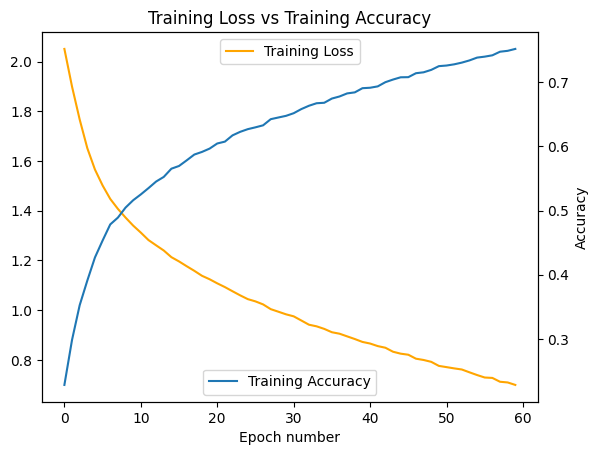

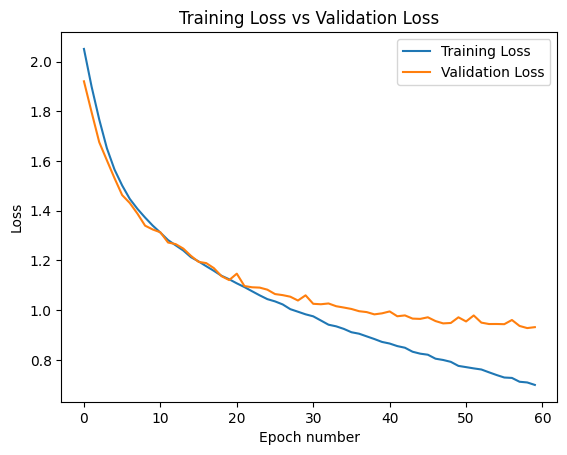

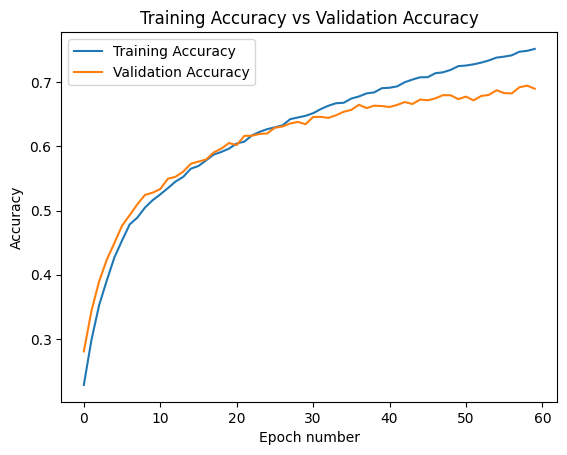

In [16]:
config_data = default_config_data.copy()
result_d_data = {}
for num_of_heads in [4, 8, 16]:
    config_data['num_of_heads'] = num_of_heads
    _, train_loss_data, valid_loss_data, train_acc_data, valid_acc_data = train_test_model(train_dataset, test_dataset, config_data)
    result_d_data[f'train_loss_{num_of_heads}'] = train_loss_data
    result_d_data[f'train_acc_{num_of_heads}'] = train_acc_data
    result_d_data[f'valid_loss_{num_of_heads}'] = valid_loss_data
    result_d_data[f'valid_acc_{num_of_heads}'] = valid_acc_data
    

train_length = 40000 validation_length = 10000


Validation Epoch 000: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.48it/s]


epoch = 0, Train Loss: 2.0787, Validation Loss: 1.9209, Train Accuracy: 22.13%, Validation Accuracy: 28.46%


Validation Epoch 001: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.57it/s]


epoch = 1, Train Loss: 1.8957, Validation Loss: 1.8155, Train Accuracy: 29.95%, Validation Accuracy: 32.77%


Validation Epoch 002: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.53it/s]


epoch = 2, Train Loss: 1.7627, Validation Loss: 1.6825, Train Accuracy: 35.37%, Validation Accuracy: 38.75%


Validation Epoch 003: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.54it/s]


epoch = 3, Train Loss: 1.6587, Validation Loss: 1.5876, Train Accuracy: 39.19%, Validation Accuracy: 42.59%


Validation Epoch 004: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.47it/s]


epoch = 4, Train Loss: 1.5693, Validation Loss: 1.5099, Train Accuracy: 42.81%, Validation Accuracy: 46.04%


Validation Epoch 005: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.50it/s]


epoch = 5, Train Loss: 1.5021, Validation Loss: 1.4513, Train Accuracy: 45.40%, Validation Accuracy: 47.65%


Validation Epoch 006: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.59it/s]


epoch = 6, Train Loss: 1.4533, Validation Loss: 1.3984, Train Accuracy: 47.16%, Validation Accuracy: 50.05%


Validation Epoch 007: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.54it/s]


epoch = 7, Train Loss: 1.4148, Validation Loss: 1.3740, Train Accuracy: 48.73%, Validation Accuracy: 50.48%


Validation Epoch 008: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.55it/s]


epoch = 8, Train Loss: 1.3831, Validation Loss: 1.3689, Train Accuracy: 49.83%, Validation Accuracy: 50.86%


Validation Epoch 009: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.49it/s]


epoch = 9, Train Loss: 1.3542, Validation Loss: 1.3178, Train Accuracy: 51.02%, Validation Accuracy: 52.72%


Validation Epoch 010: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.54it/s]


epoch = 10, Train Loss: 1.3266, Validation Loss: 1.3033, Train Accuracy: 51.70%, Validation Accuracy: 53.59%


Validation Epoch 011: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.65it/s]


epoch = 11, Train Loss: 1.3002, Validation Loss: 1.2920, Train Accuracy: 53.08%, Validation Accuracy: 54.40%


Validation Epoch 012: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.44it/s]


epoch = 12, Train Loss: 1.2805, Validation Loss: 1.2616, Train Accuracy: 53.42%, Validation Accuracy: 55.44%


Validation Epoch 013: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.55it/s]


epoch = 13, Train Loss: 1.2597, Validation Loss: 1.2657, Train Accuracy: 54.27%, Validation Accuracy: 55.25%


Validation Epoch 014: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.35it/s]


epoch = 14, Train Loss: 1.2405, Validation Loss: 1.2369, Train Accuracy: 55.24%, Validation Accuracy: 55.71%


Validation Epoch 015: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.51it/s]


epoch = 15, Train Loss: 1.2243, Validation Loss: 1.2356, Train Accuracy: 55.70%, Validation Accuracy: 55.73%


Validation Epoch 016: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.47it/s]


epoch = 16, Train Loss: 1.2061, Validation Loss: 1.2358, Train Accuracy: 56.38%, Validation Accuracy: 56.57%


Validation Epoch 017: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.37it/s]


epoch = 17, Train Loss: 1.1901, Validation Loss: 1.2064, Train Accuracy: 57.16%, Validation Accuracy: 57.21%


Validation Epoch 018: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.52it/s]


epoch = 18, Train Loss: 1.1741, Validation Loss: 1.1954, Train Accuracy: 57.57%, Validation Accuracy: 57.83%


Validation Epoch 019: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.58it/s]


epoch = 19, Train Loss: 1.1594, Validation Loss: 1.1804, Train Accuracy: 58.24%, Validation Accuracy: 58.16%


Validation Epoch 020: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.54it/s]


epoch = 20, Train Loss: 1.1428, Validation Loss: 1.1599, Train Accuracy: 58.90%, Validation Accuracy: 58.95%


Validation Epoch 021: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.39it/s]


epoch = 21, Train Loss: 1.1284, Validation Loss: 1.1750, Train Accuracy: 59.36%, Validation Accuracy: 58.88%


Validation Epoch 022: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.50it/s]


epoch = 22, Train Loss: 1.1169, Validation Loss: 1.1456, Train Accuracy: 59.85%, Validation Accuracy: 59.88%


Validation Epoch 023: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.44it/s]


epoch = 23, Train Loss: 1.1031, Validation Loss: 1.1384, Train Accuracy: 60.13%, Validation Accuracy: 59.91%


Validation Epoch 024: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.52it/s]


epoch = 24, Train Loss: 1.0871, Validation Loss: 1.1382, Train Accuracy: 61.17%, Validation Accuracy: 60.11%


Validation Epoch 025: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.55it/s]


epoch = 25, Train Loss: 1.0761, Validation Loss: 1.1162, Train Accuracy: 61.31%, Validation Accuracy: 60.52%


Validation Epoch 026: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.42it/s]


epoch = 26, Train Loss: 1.0668, Validation Loss: 1.1072, Train Accuracy: 61.81%, Validation Accuracy: 60.86%


Validation Epoch 027: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.54it/s]


epoch = 27, Train Loss: 1.0533, Validation Loss: 1.1089, Train Accuracy: 62.33%, Validation Accuracy: 60.77%


Validation Epoch 028: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.61it/s]


epoch = 28, Train Loss: 1.0408, Validation Loss: 1.1026, Train Accuracy: 62.76%, Validation Accuracy: 61.32%


Validation Epoch 029: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.46it/s]


epoch = 29, Train Loss: 1.0304, Validation Loss: 1.0938, Train Accuracy: 63.02%, Validation Accuracy: 61.81%


Validation Epoch 030: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.37it/s]


epoch = 30, Train Loss: 1.0201, Validation Loss: 1.0811, Train Accuracy: 63.28%, Validation Accuracy: 62.18%


Validation Epoch 031: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.41it/s]


epoch = 31, Train Loss: 1.0095, Validation Loss: 1.0975, Train Accuracy: 64.03%, Validation Accuracy: 62.01%


Validation Epoch 032: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.58it/s]


epoch = 32, Train Loss: 0.9971, Validation Loss: 1.0796, Train Accuracy: 64.26%, Validation Accuracy: 62.40%


Validation Epoch 033: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.49it/s]


epoch = 33, Train Loss: 0.9909, Validation Loss: 1.0860, Train Accuracy: 64.52%, Validation Accuracy: 62.18%


Validation Epoch 034: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.46it/s]


epoch = 34, Train Loss: 0.9798, Validation Loss: 1.0877, Train Accuracy: 65.11%, Validation Accuracy: 62.02%


Validation Epoch 035: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.59it/s]


epoch = 35, Train Loss: 0.9675, Validation Loss: 1.0644, Train Accuracy: 65.27%, Validation Accuracy: 62.96%


Validation Epoch 036: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.46it/s]


epoch = 36, Train Loss: 0.9572, Validation Loss: 1.0873, Train Accuracy: 65.50%, Validation Accuracy: 62.16%


Validation Epoch 037: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.53it/s]


epoch = 37, Train Loss: 0.9473, Validation Loss: 1.0758, Train Accuracy: 66.04%, Validation Accuracy: 63.13%


Validation Epoch 038: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.61it/s]


epoch = 38, Train Loss: 0.9411, Validation Loss: 1.0506, Train Accuracy: 66.07%, Validation Accuracy: 63.45%


Validation Epoch 039: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.40it/s]


epoch = 39, Train Loss: 0.9328, Validation Loss: 1.0877, Train Accuracy: 66.61%, Validation Accuracy: 62.58%


Validation Epoch 040: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.56it/s]


epoch = 40, Train Loss: 0.9250, Validation Loss: 1.0472, Train Accuracy: 66.53%, Validation Accuracy: 63.79%


Validation Epoch 041: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.44it/s]


epoch = 41, Train Loss: 0.9132, Validation Loss: 1.0614, Train Accuracy: 67.39%, Validation Accuracy: 63.48%


Validation Epoch 042: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.59it/s]


epoch = 42, Train Loss: 0.9058, Validation Loss: 1.0493, Train Accuracy: 67.64%, Validation Accuracy: 63.84%


Validation Epoch 043: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.67it/s]


epoch = 43, Train Loss: 0.8927, Validation Loss: 1.0228, Train Accuracy: 68.17%, Validation Accuracy: 64.55%


Validation Epoch 044: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.52it/s]


epoch = 44, Train Loss: 0.8920, Validation Loss: 1.0434, Train Accuracy: 68.19%, Validation Accuracy: 64.06%


Validation Epoch 045: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.29it/s]


epoch = 45, Train Loss: 0.8850, Validation Loss: 1.0206, Train Accuracy: 68.26%, Validation Accuracy: 64.84%


Validation Epoch 046: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.48it/s]


epoch = 46, Train Loss: 0.8737, Validation Loss: 1.0283, Train Accuracy: 68.75%, Validation Accuracy: 64.69%


Validation Epoch 047: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.56it/s]


epoch = 47, Train Loss: 0.8654, Validation Loss: 1.0486, Train Accuracy: 69.17%, Validation Accuracy: 64.72%


Validation Epoch 048: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.38it/s]


epoch = 48, Train Loss: 0.8556, Validation Loss: 1.0147, Train Accuracy: 69.25%, Validation Accuracy: 65.24%


Validation Epoch 049: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.51it/s]


epoch = 49, Train Loss: 0.8533, Validation Loss: 1.0209, Train Accuracy: 69.69%, Validation Accuracy: 65.20%


Validation Epoch 050: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.53it/s]


epoch = 50, Train Loss: 0.8390, Validation Loss: 1.0094, Train Accuracy: 70.37%, Validation Accuracy: 65.63%


Validation Epoch 051: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.59it/s]


epoch = 51, Train Loss: 0.8354, Validation Loss: 1.0191, Train Accuracy: 70.38%, Validation Accuracy: 65.65%


Validation Epoch 052: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.30it/s]


epoch = 52, Train Loss: 0.8245, Validation Loss: 1.0064, Train Accuracy: 70.49%, Validation Accuracy: 65.45%


Validation Epoch 053: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.46it/s]


epoch = 53, Train Loss: 0.8130, Validation Loss: 1.0171, Train Accuracy: 70.86%, Validation Accuracy: 65.24%


Validation Epoch 054: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.48it/s]


epoch = 54, Train Loss: 0.8126, Validation Loss: 1.0176, Train Accuracy: 70.77%, Validation Accuracy: 65.55%


Validation Epoch 055: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.54it/s]


epoch = 55, Train Loss: 0.8017, Validation Loss: 1.0061, Train Accuracy: 71.30%, Validation Accuracy: 65.98%


Validation Epoch 056: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.48it/s]


epoch = 56, Train Loss: 0.7940, Validation Loss: 1.0144, Train Accuracy: 71.74%, Validation Accuracy: 65.82%


Validation Epoch 057: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.46it/s]


epoch = 57, Train Loss: 0.7841, Validation Loss: 1.0088, Train Accuracy: 71.97%, Validation Accuracy: 66.74%


Validation Epoch 058: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.51it/s]


epoch = 58, Train Loss: 0.7739, Validation Loss: 1.0122, Train Accuracy: 72.47%, Validation Accuracy: 65.55%


Validation Epoch 059: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.60it/s]


epoch = 59, Train Loss: 0.7694, Validation Loss: 1.0187, Train Accuracy: 72.66%, Validation Accuracy: 65.76%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.32it/s]


For model trained on  80.00% data with 4 heads and 4 x 4 non-overlapping patches,
	Train Accuracy is  76.70%
	Test Accuracy is  66.04%


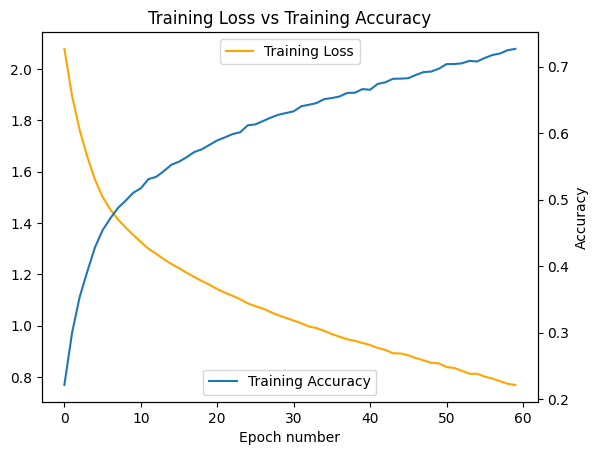

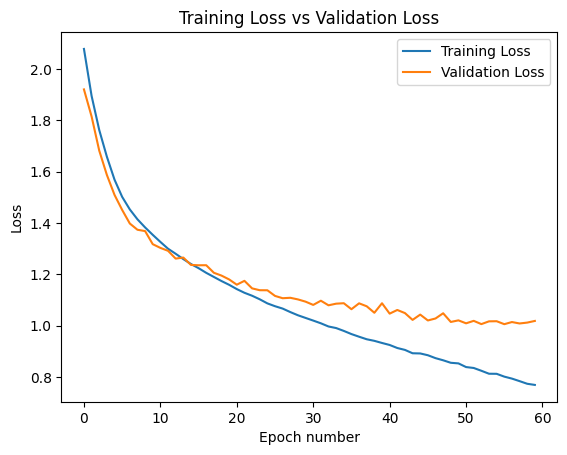

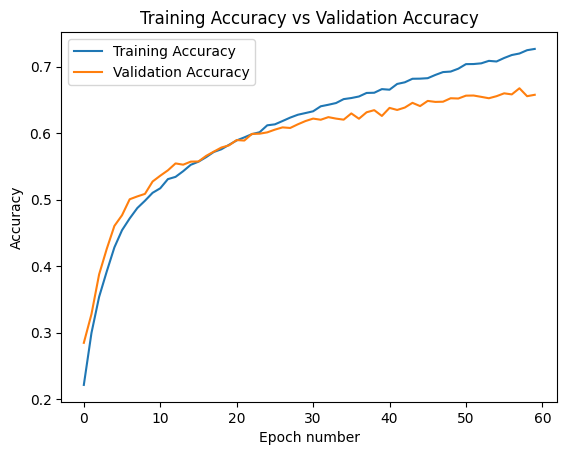

In [17]:
config_data = default_config_data.copy()
config_data['use_final_cls_token'] = True
vit_model_e, train_loss_data_e, valid_loss_data_e, train_acc_data_e, valid_acc_data_e = train_test_model(train_dataset, test_dataset, config_data)

In [20]:
# Visualizing attention weights.
from torchvision.utils import save_image
import cv2
from PIL import Image
model = ViT(
        default_config_data['image_size'],
        default_config_data['in_channels'],
        default_config_data['patch_size'],
        default_config_data['embed_dim'],
        default_config_data['num_of_encoders'],
        default_config_data['num_of_heads'],
        default_config_data['mlp_size'],
        default_config_data['mlp_drop'],
        default_config_data['attn_drop'],
        default_config_data['proj_drop'],
        default_config_data['embed_drop'],
        default_config_data['include_bias'],
        default_config_data['num_of_classes'],
        default_config_data['overlap_patches'],
        default_config_data['use_final_cls_token'],
    )
device = 'cuda'
model.load_state_dict(torch.load('my_vit_model.pth'))
model.eval()
model = model.to(device)

In [131]:
# Reference from :- https://github.com/jacobgil/vit-explain/blob/main/vit_rollout.py based on the blog https://jacobgil.github.io/deeplearning/vision-transformer-explainability
def rollout(attention_data, discard_ratio, fusion_type):
    device = 'cuda'
    # Attention_Rollout for the first layer is I.
    result = torch.eye(attention_data[0].size(-1)).to(device)
    with torch.no_grad():
        for attention in attention_data:
            # attention shape is (B =  1, num_of_heads, num_of_patches with class token , num_of_patches with class token)
            if fusion_type == "mean":
                attention_heads_fused = attention.mean(axis=1)
            elif fusion_type == "max":
                attention_heads_fused = attention.max(axis=1)[0]
            elif fusion_type == "min":
                attention_heads_fused = attention.min(axis=1)[0]

            # Drop the lowest attentions, but
            # don't drop the class token
            # discarding few attention information based on the ratio supplied.
            # discarding has good affect in visualization so better to drop all the low attention values.
            flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)
            _, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
            indices = indices[indices != 0]
            flat[0, indices] = 0
            I = torch.eye(attention_heads_fused.size(-1)).to(device)
            # (A_L + I)
            a = (attention_heads_fused + 1.0*I)/2
            a = a / a.sum(dim=-1)
            a = a.to(device)
			# Attention_rollout current layer = (Attention_matrix + I) Attention_rollout previous layer
            result = torch.matmul(a, result)
    
    # Look at the total attention between the class token,
    # and the image patches
    mask = result[0, 0 , 1 :]
    # (8, 8)
    width = int(mask.size(-1)**0.5)
    mask = mask.reshape(width, width).cpu().detach().numpy()
    mask = mask / np.max(mask)
    return mask

In [132]:
def show_mask_on_image(img, mask):
    # normalize
    img = np.float32(img) / 255
	# generate heatmap based on the mask.
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
	# normalize the heatmap
    heatmap = np.float32(heatmap) / 255
	# combine heatmap and image and normalize it.
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    # convert back to pixel range.
    return np.uint8(255 * cam)

In [133]:
image_indexes = [11, 4441]

images_data = []
actual_labels = []
pred_labels = []
attention_mask_data = []

for image_index in image_indexes:
    image_data, actual_label = test_dataset[image_index]
    image_data_gpu = image_data.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image_data_gpu)
        # get prediciton.
        pred_label = torch.argmax(torch.softmax(output, dim=1), dim=1).item()
        actual_labels.append(actual_label)
        pred_labels.append(pred_label)
        print(f'{pred_label = } {actual_label = }')
		# loop through the encoder layers and grab the attention weights.
        attn_weights = []
        for index in range(default_config_data['num_of_encoders']):
            attn_weights.append(model.transformer_blocks[index].attn.attn_scores)
		# calculate the attention mask for the image based on the weights.
        mask = rollout(attn_weights,0.9, 'max')
		# below code if used for resizing image to 224, 224 to get better look of the image.
        save_image(image_data, 'new.png')
        img = Image.open('new.png')
        img = img.resize((224, 224))
        image_numpy = np.array(img)
        mask = cv2.resize(mask, (224, 224))
        # applying mask on the image.
        mask_img = show_mask_on_image(image_numpy, mask)
        images_data.append(image_numpy)
        attention_mask_data.append(mask_img)

pred_label = 9 actual_label = 9
pred_label = 9 actual_label = 1


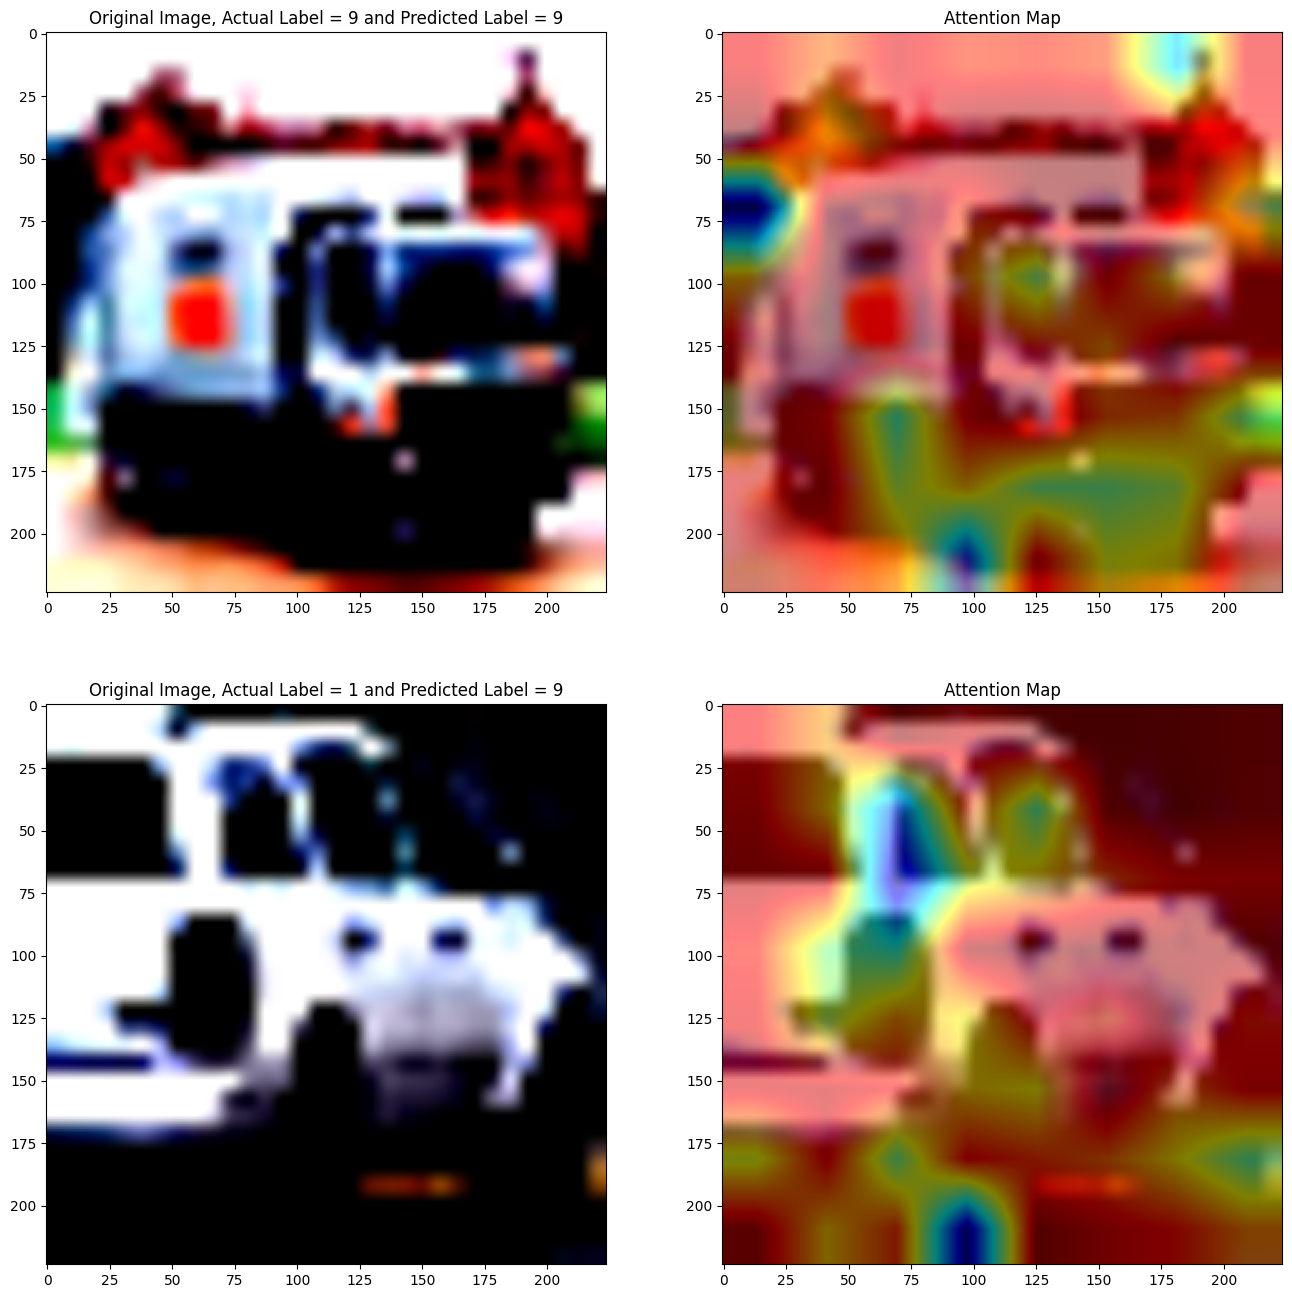

In [134]:
num_of_images = 2
fig, axs = plt.subplots(nrows = num_of_images, ncols=num_of_images, figsize=(16, 16))
for row_index in range(num_of_images):
    for col_index in range(num_of_images):
        if col_index == 0:
            axs[row_index, col_index].set_title(f'Original Image, Actual Label = {actual_labels[row_index]} and Predicted Label = {pred_labels[row_index]}')
            axs[row_index, col_index].imshow(images_data[row_index])
        else:		
            axs[row_index, col_index].set_title('Attention Map')
            axs[row_index, col_index].imshow(attention_mask_data[row_index])
        